# Importing modules # 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from sklearn.metrics import silhouette_score
import re

from pandas.io.formats.style_render import DataFrame
from tqdm import tqdm
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns

# Loading the dataset #

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp /content/drive/Shareddrives/DM_Project/dataset/users_extended.csv /content/

In [ ]:
users = pd.read_csv("/content/users_extended.csv")
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      11508 non-null  int64  
 1   name                    11508 non-null  object 
 2   lang                    11508 non-null  object 
 3   bot                     11508 non-null  int64  
 4   created_at              11508 non-null  object 
 5   statuses_count          11508 non-null  int64  
 6   num_tweets              11508 non-null  int64  
 7   retweet_count_total     11508 non-null  int64  
 8   reply_count_total       11508 non-null  int64  
 9   favorite_count_total    11508 non-null  int64  
 10  num_hashtags_total      11508 non-null  int64  
 11  num_urls_total          11508 non-null  int64  
 12  num_mentions_total      11508 non-null  int64  
 13  retweet_count_avg       11508 non-null  float64
 14  reply_count_avg         11508 non-null

# Define functions to plot distributions and detect outliers

In [ ]:
def mad(col):
  data = users[col]
  median = data.median()
  devs = []
  for val in data:
    dev = abs(val-median)
    devs.append(dev)
  return np.median(devs)


def get_stats(col):
  data = users[col]
  print(f"Mean: {data.mean()}")
  print(f"Median: {data.median()}")
  print(f"Mode: {data.mode().to_list()}")
  print(f"Standard deviation: {data.std()}")
  print(f"Median absolute deviation: {mad(col)}")
  print(f"1st quantile: {data.quantile(0.25)}")
  print(f"3rd quantile: {data.quantile(0.75)}")
  print(f"Minimum: {data.min()}")
  print(f"Maximum: {data.max()}")

def visualize_distribution(col):

  data = users[col].copy()
  data_log = data.apply(lambda x: np.log10(x+1))

  data_real = users[users["bot"] == 0][col].copy()
  data_real_log = data_real.apply(lambda x: np.log10(x+1))

  data_bot = users[users["bot"] == 1][col].copy()
  data_bot_log = data_bot.apply(lambda x: np.log10(x+1))

  print(f"\n{col} all users normal scale:")
  fig, ax = plt.subplots(1, 2, figsize=(10,4))
  fig.tight_layout()
  ax[0].hist(data, bins=10)
  ax[1].boxplot(data)
  plt.show()

  print(f"\n{col} all users log scale:")
  fig, ax = plt.subplots(1, 2, figsize=(10,4))
  fig.tight_layout()
  ax[0].hist(data_log, bins=10)
  ax[1].boxplot(data_log)
  plt.show()


  print(f"\n{col} real users normal scale:")
  fig, ax = plt.subplots(1, 2, figsize=(10,4))
  fig.tight_layout()
  ax[0].hist(data_real, bins=10)
  ax[1].boxplot(data_real)
  plt.show()

  print(f"\n{col} real users log scale:")
  fig, ax = plt.subplots(1, 2, figsize=(10,4))
  fig.tight_layout()
  ax[0].hist(data_real_log, bins=10)
  ax[1].boxplot(data_real_log)
  plt.show()


  print(f"\n{col} bot users normal scale:")
  fig, ax = plt.subplots(1, 2, figsize=(10,4))
  fig.tight_layout()
  ax[0].hist(data_bot, bins=10)
  ax[1].boxplot(data_bot)
  plt.show()

  print(f"\n{col} bot users log scale:")
  fig, ax = plt.subplots(1, 2, figsize=(10,4))
  fig.tight_layout()
  ax[0].hist(data_bot_log, bins=10)
  ax[1].boxplot(data_bot_log)
  plt.show()

  del data
  del data_real
  del data_bot
  del data_log
  del data_real_log
  del data_bot_log




def fix_outliers_log(col, upp_real=0.99, low_real = 0, upp_bot=0.99, low_bot=0):

  reals = users[users.bot == 0][col].copy()
  bots = users[users.bot == 1][col].copy()

  if upp_real != -1:
    out_upp_real = reals.quantile(upp_real)
  else:
    out_upp_real = np.inf

  if low_real != -1:
    out_low_real = reals.quantile(low_real)
  else:
    out_low_real = 0

  if upp_bot != -1:
    out_upp_bot = bots.quantile(upp_bot)
  else:
    out_upp_bot = np.inf

  if low_bot != -1:
    out_low_bot = bots.quantile(low_bot) 
  else:
    out_low_bot = 0

  reals_fixed = reals.copy()
  bots_fixed  = bots.copy()

  reals_fixed[reals_fixed > out_upp_real] = np.nan
  reals_fixed[reals_fixed < out_low_real] = np.nan

  bots_fixed[bots_fixed > out_upp_bot] = np.nan
  bots_fixed[bots_fixed < out_low_bot] = np.nan


  print(f"\n\nReal users theshold {out_upp_real}, {out_low_real}")
  fig, ax = plt.subplots(2, 2, figsize=(9,7))
  fig.tight_layout()
  ax[0,0].boxplot(reals)
  ax[0,1].boxplot(reals.apply(lambda x: np.log10(x+1)))
  ax[1,0].boxplot(reals_fixed.dropna())
  ax[1,1].boxplot(reals_fixed.dropna().apply(lambda x: np.log10(x+1)))
  plt.show()

  print(f"\nBot users theshold {out_upp_bot}, {out_low_bot}")
  fig, ax = plt.subplots(2, 2, figsize=(9,7))
  fig.tight_layout()
  ax[0,0].boxplot(bots)
  ax[0,1].boxplot(bots.apply(lambda x: np.log10(x+1)))
  ax[1,0].boxplot(bots_fixed.dropna())
  ax[1,1].boxplot(bots_fixed.dropna().apply(lambda x: np.log10(x+1)))
  plt.show()

  del reals
  del bots

  reals_fixed.fillna(np.nanmedian(reals_fixed), inplace=True)
  bots_fixed.fillna(np.nanmedian(bots_fixed), inplace=True)

  return reals_fixed, bots_fixed


def fix_outliers(col, upp_real=0.99, low_real = 0, upp_bot=0.99, low_bot=0):

  reals = users[users.bot == 0][col].copy()
  bots = users[users.bot == 1][col].copy()

  if upp_real != -1:
    out_upp_real = reals.quantile(upp_real)
  else:
    out_upp_real = np.inf

  if low_real != -1:
    out_low_real = reals.quantile(low_real)
  else:
    out_low_real = 0

  if upp_bot != -1:
    out_upp_bot = bots.quantile(upp_bot)
  else:
    out_upp_bot = np.inf

  if low_bot != -1:
    out_low_bot = bots.quantile(low_bot) 
  else:
    out_low_bot = 0

  reals_fixed = reals.copy()
  bots_fixed  = bots.copy()

  reals_fixed[reals_fixed > out_upp_real] = np.nan
  reals_fixed[reals_fixed < out_low_real] = np.nan

  bots_fixed[bots_fixed > out_upp_bot] = np.nan
  bots_fixed[bots_fixed < out_low_bot] = np.nan


  print(f"\n\nReal users theshold {out_upp_real}, {out_low_real}")
  fig, ax = plt.subplots(1, 2, figsize=(10,4))
  fig.tight_layout()
  ax[0].boxplot(reals)
  ax[1].boxplot(reals_fixed.dropna())
  plt.show()

  print(f"\nBot users theshold {out_upp_bot}, {out_low_bot}")
  fig, ax = plt.subplots(1, 2, figsize=(10,4))
  fig.tight_layout()
  ax[0].boxplot(bots)
  ax[1].boxplot(bots_fixed.dropna())
  plt.show()

  del reals
  del bots

  reals_fixed.fillna(np.nanmedian(reals_fixed), inplace=True)
  bots_fixed.fillna(np.nanmedian(bots_fixed), inplace=True)

  return reals_fixed, bots_fixed




def fix_outliers_boxplot_log(col):

  reals = users[users.bot == 0][col].copy()
  bots = users[users.bot == 1][col].copy()

  reals_log = reals.apply(lambda x: np.log10(x+1))
  bots_log = bots.apply(lambda x: np.log10(x+1))

  q1_reals = reals_log.quantile(0.25)
  q3_reals = reals_log.quantile(0.75)
  iqr_reals = q3_reals - q1_reals
  low_reals = q1_reals - iqr_reals*1.5
  upp_reals = q3_reals + iqr_reals*1.5


  q1_bots = bots_log.quantile(0.25)
  q3_bots = bots_log.quantile(0.75)
  iqr_bots = q3_bots - q1_bots
  low_bots = q1_bots - iqr_bots*1.5
  upp_bots = q3_bots + iqr_bots*1.5


  mask_out_reals = ((reals_log > upp_reals) | (reals_log < low_reals))
  mask_out_bots = ((bots_log > upp_bots) | (bots_log < low_bots))

  reals_fixed = reals.copy()
  bots_fixed = bots.copy()

  reals_log_fixed = reals_log.copy()
  bots_log_fixed  = bots_log.copy()

  reals_fixed[mask_out_reals] = np.nan
  bots_fixed[mask_out_bots] = np.nan

  reals_log_fixed[mask_out_reals] = np.nan
  bots_log_fixed[mask_out_bots] = np.nan


  print(f"\n\nReal users theshold log scale {upp_reals}, {low_reals}")
  print(f"Real users theshold normal scale {10**upp_reals - 1}, {10**low_reals - 1}")

  fig, ax = plt.subplots(1, 2, figsize=(10,4))
  fig.tight_layout()
  ax[0].boxplot(reals)
  ax[1].boxplot(reals_fixed.dropna())
  plt.show()

  fig, ax = plt.subplots(1, 2, figsize=(10,4))
  fig.tight_layout()
  ax[0].boxplot(reals_log)
  ax[1].boxplot(reals_log_fixed.dropna())
  plt.show()

  
  print(f"\n\nBot users theshold log scale {upp_bots}, {low_bots}")
  print(f"Bot users theshold normal scale {10**upp_bots - 1}, {10**low_bots - 1}")

  fig, ax = plt.subplots(1, 2, figsize=(10,4))
  fig.tight_layout()
  ax[0].boxplot(bots)
  ax[1].boxplot(bots_fixed.dropna())
  plt.show()

  fig, ax = plt.subplots(1, 2, figsize=(10,4))
  fig.tight_layout()
  ax[0].boxplot(bots_log)
  ax[1].boxplot(bots_log_fixed.dropna())
  plt.show()

  del reals
  del bots

  reals_fixed.fillna(np.nanmedian(reals_fixed), inplace=True)
  bots_fixed.fillna(np.nanmedian(bots_fixed), inplace=True)

  return reals_fixed, bots_fixed


def fix_outliers_boxplot(col):

  reals = users[users.bot == 0][col].copy()
  bots = users[users.bot == 1][col].copy()

  q1_reals = reals.quantile(0.25)
  q3_reals = reals.quantile(0.75)
  iqr_reals = q3_reals - q1_reals
  low_reals = q1_reals - iqr_reals*1.5
  upp_reals = q3_reals + iqr_reals*1.5


  q1_bots = bots.quantile(0.25)
  q3_bots = bots.quantile(0.75)
  iqr_bots = q3_bots - q1_bots
  low_bots = q1_bots - iqr_bots*1.5
  upp_bots = q3_bots + iqr_bots*1.5


  mask_out_reals = ((reals > upp_reals) | (reals < low_reals))
  mask_out_bots = ((bots > upp_bots) | (bots < low_bots))

  reals_fixed = reals.copy()
  bots_fixed = bots.copy()

  reals_fixed[mask_out_reals] = np.nan
  bots_fixed[mask_out_bots] = np.nan


  print(f"\n\nReal users theshold log scale {upp_reals}, {low_reals}")

  fig, ax = plt.subplots(1, 2, figsize=(10,4))
  fig.tight_layout()
  ax[0].boxplot(reals)
  ax[1].boxplot(reals_fixed.dropna())
  plt.show()


  
  print(f"\n\nReal users theshold log scale {upp_bots}, {low_bots}")

  fig, ax = plt.subplots(1, 2, figsize=(10,4))
  fig.tight_layout()
  ax[0].boxplot(bots)
  ax[1].boxplot(bots_fixed.dropna())
  plt.show()

  del reals
  del bots

  reals_fixed.fillna(np.nanmedian(reals_fixed), inplace=True)
  bots_fixed.fillna(np.nanmedian(bots_fixed), inplace=True)

  return reals_fixed, bots_fixed

# Statuses count

In [ ]:
col = "statuses_count"
get_stats(col)

Mean: 5171.501737921446
Median: 64.0
Mode: [48]
Standard deviation: 18491.085251172775
Median absolute deviation: 43.0
1st quantile: 42.0
3rd quantile: 2041.0
Minimum: 0
Maximum: 399555



statuses_count all users normal scale:


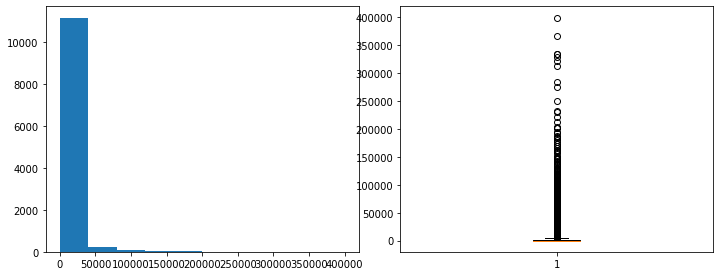


statuses_count all users log scale:


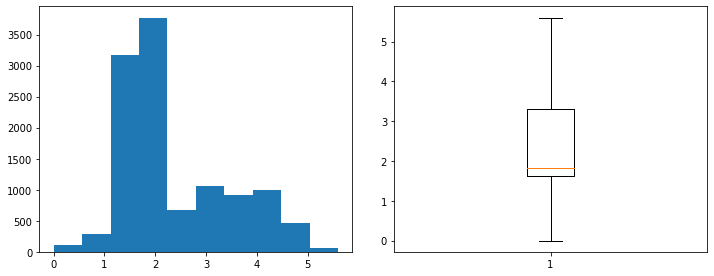


statuses_count real users normal scale:


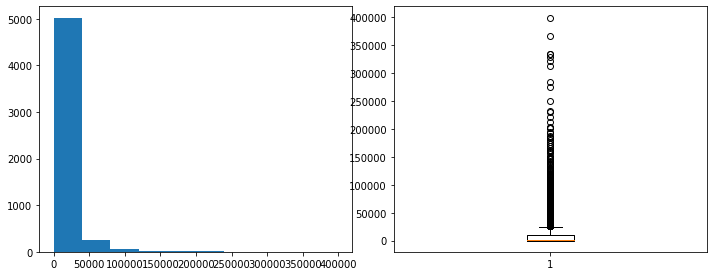


statuses_count real users log scale:


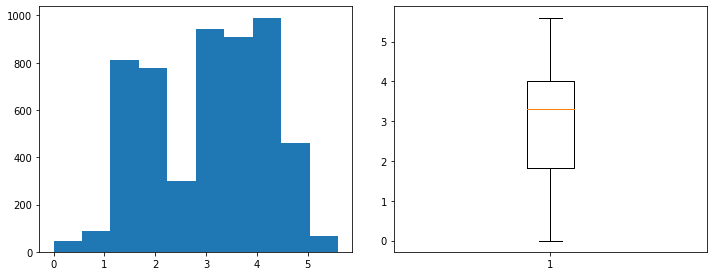


statuses_count bot users normal scale:


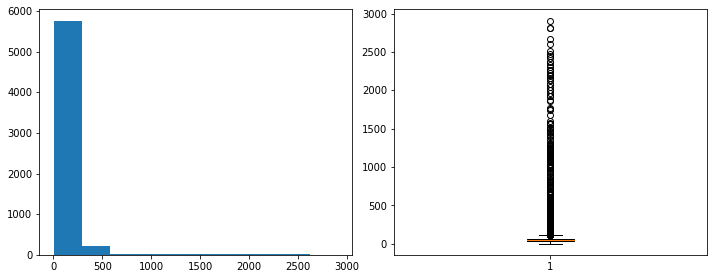


statuses_count bot users log scale:


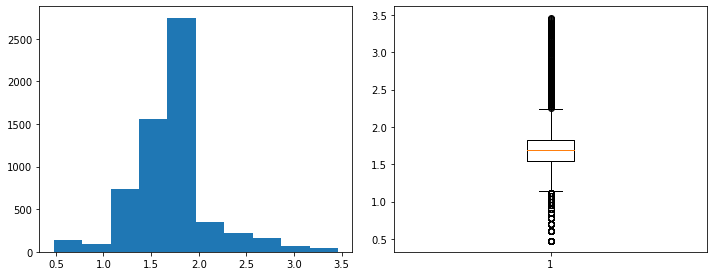

In [ ]:
visualize_distribution(col)

# Number of tweets

In [ ]:
col = "num_tweets"
get_stats(col)

Mean: 888.9826207855405
Median: 124.0
Mode: [21]
Standard deviation: 1161.2913321934025
Median absolute deviation: 105.0
1st quantile: 62.0
3rd quantile: 1606.0
Minimum: 1
Maximum: 3929



num_tweets all users normal scale:


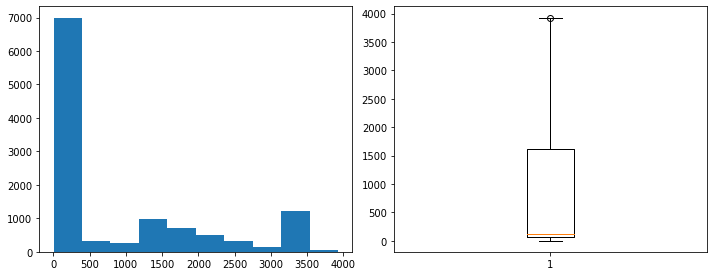


num_tweets all users log scale:


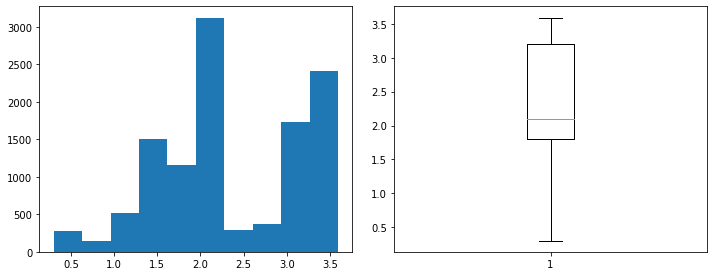


num_tweets real users normal scale:


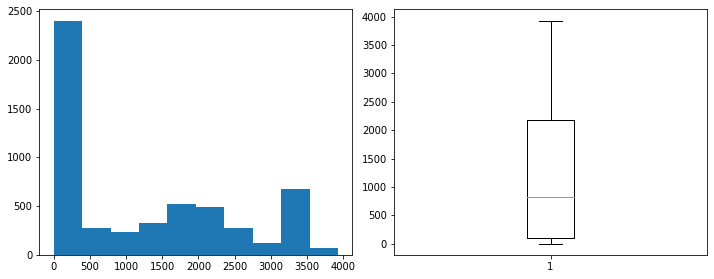


num_tweets real users log scale:


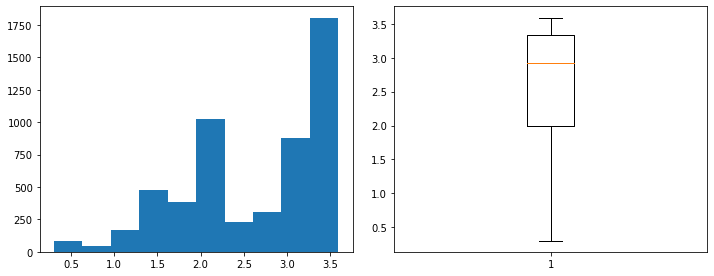


num_tweets bot users normal scale:


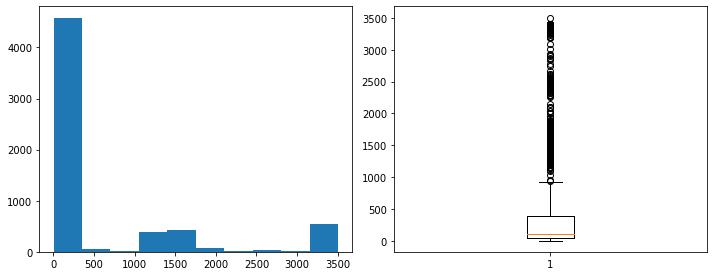


num_tweets bot users log scale:


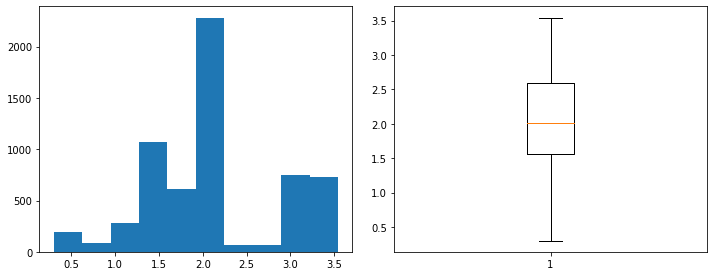

In [ ]:
visualize_distribution(col)

# Retweet count total

In [ ]:
col = "retweet_count_total"
get_stats(col)

Mean: 425997.76181786583
Median: 62117.5
Mode: [0]
Standard deviation: 591349.228887359
Median absolute deviation: 62055.5
1st quantile: 7973.25
3rd quantile: 759979.0
Minimum: 0
Maximum: 3094742



retweet_count_total all users normal scale:


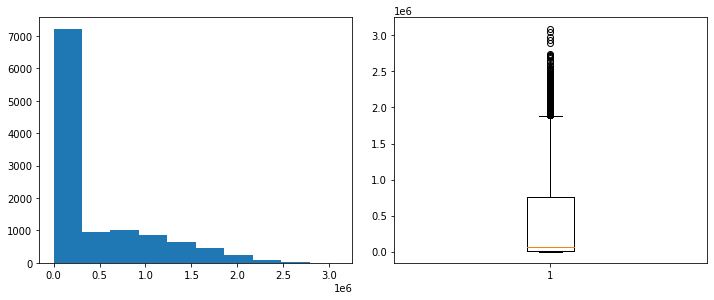


retweet_count_total all users log scale:


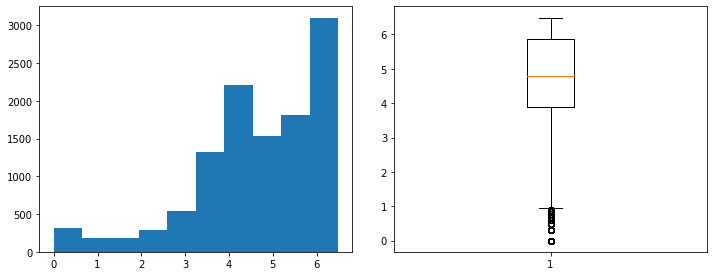


retweet_count_total real users normal scale:


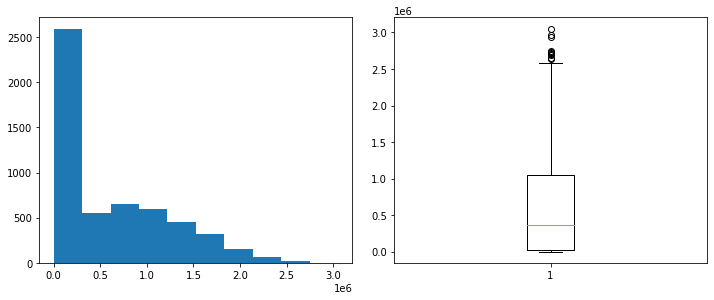


retweet_count_total real users log scale:


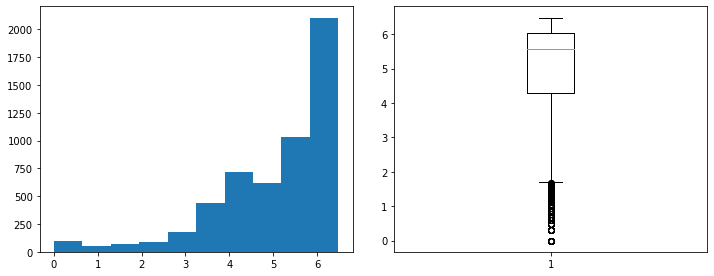


retweet_count_total bot users normal scale:


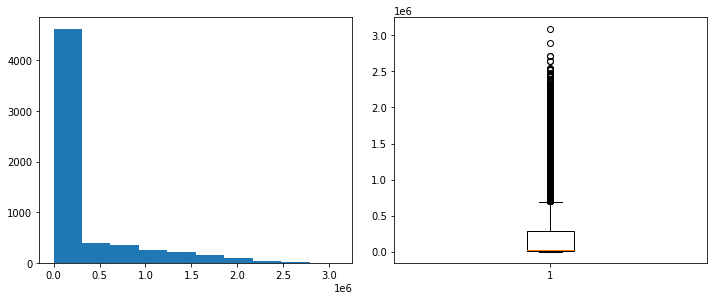


retweet_count_total bot users log scale:


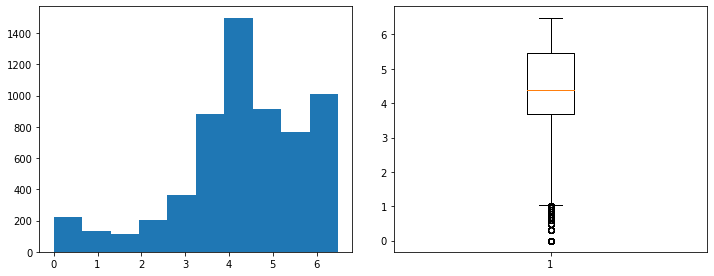

In [ ]:
visualize_distribution(col)



Real users theshold log scale 8.627320789547175, 1.6835975816374797
Real users theshold normal scale 423956002.5029242, 47.261140584642845


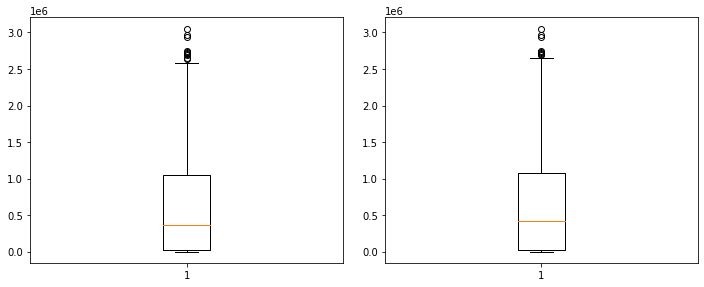

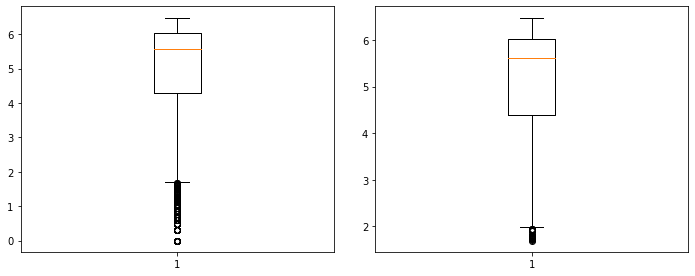



Bot users theshold log scale 8.1020601919861, 1.0223872222175192
Bot users theshold normal scale 126491163.84974268, 9.529002340291916


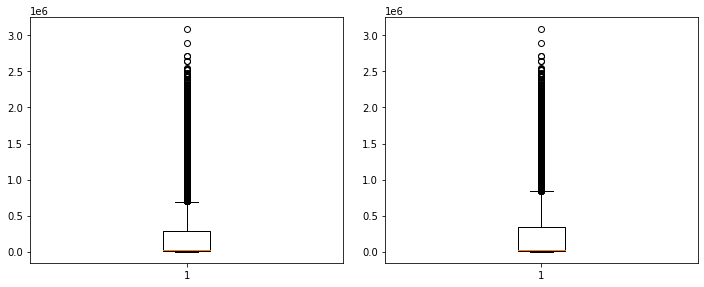

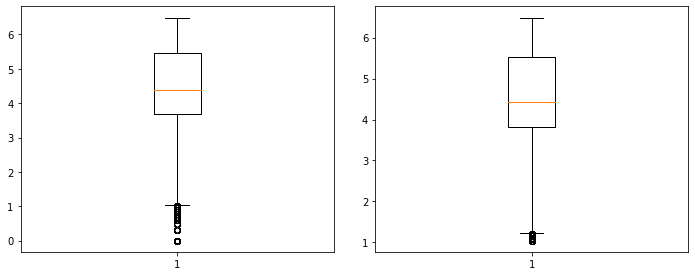

In [ ]:
#reals, bots = fix_outliers_log(col, upp_real=-1, low_real = 0.035, upp_bot=-1, low_bot=0.05)
reals, bots = fix_outliers_boxplot_log(col)

users.loc[reals.index.tolist(), col] = reals
users.loc[bots.index.tolist(), col] = bots

# Reply count total

In [ ]:
col = "reply_count_total"
get_stats(col)

Mean: 15.322297532151547
Median: 0.0
Mode: [0]
Standard deviation: 84.7786343472687
Median absolute deviation: 0.0
1st quantile: 0.0
3rd quantile: 3.0
Minimum: 0
Maximum: 1638



reply_count_total all users normal scale:


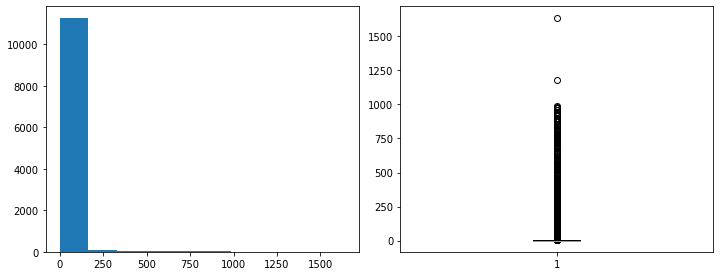


reply_count_total all users log scale:


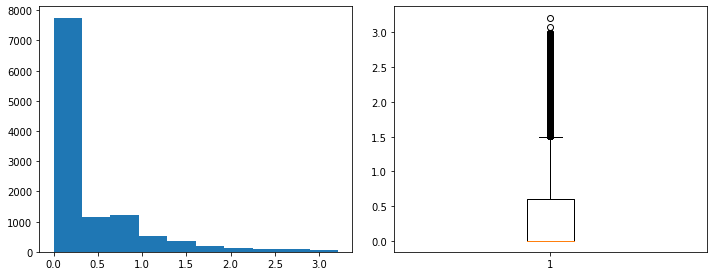


reply_count_total real users normal scale:


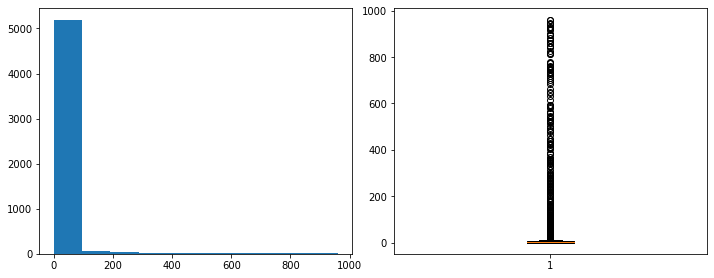


reply_count_total real users log scale:


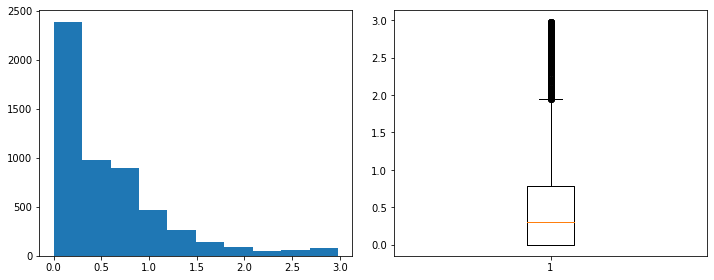


reply_count_total bot users normal scale:


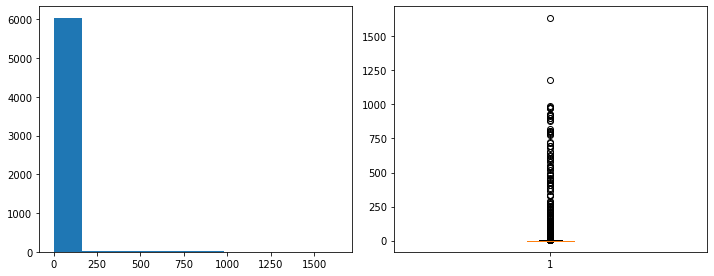


reply_count_total bot users log scale:


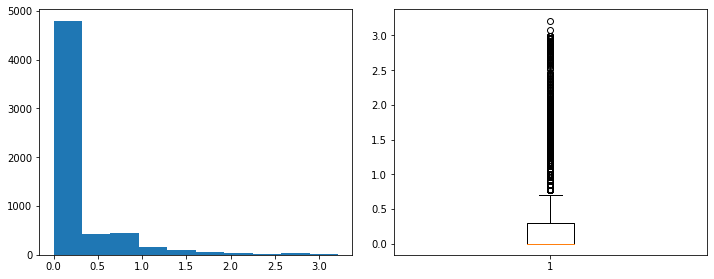

In [ ]:
visualize_distribution(col)



Real users theshold log scale 1.945378125959109, -1.1672268755754653
Real users theshold normal scale 87.1816307401944, -0.9319586182560228


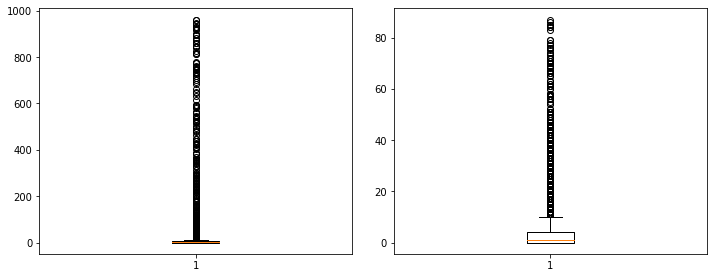

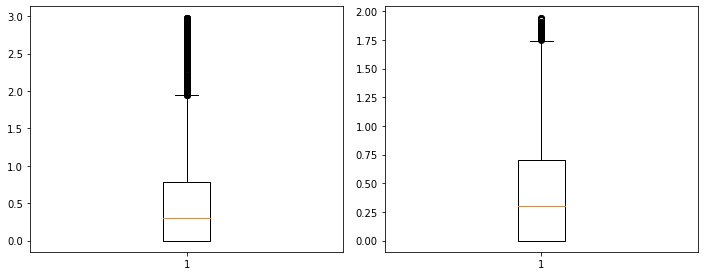



Bot users theshold log scale 0.7525749891599529, -0.45154499349597177
Bot users theshold normal scale 4.656854249492379, -0.6464466094067263


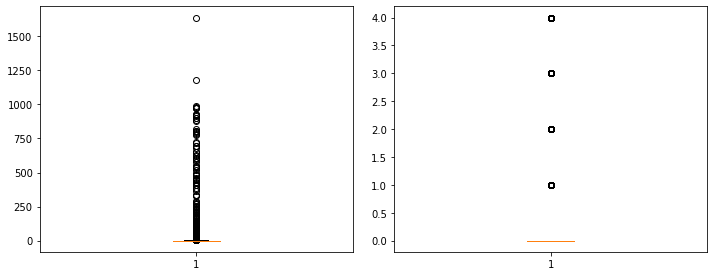

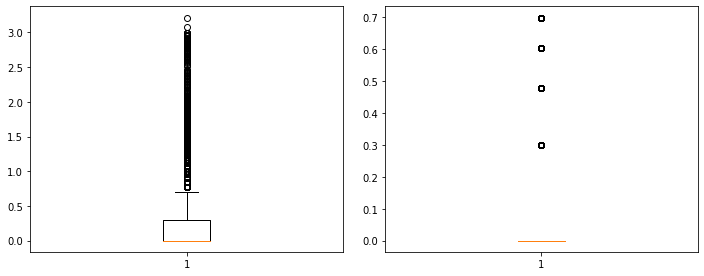

In [ ]:
# reals, bots = fix_outliers_log(col, upp_real=0.985, low_real = -1, upp_bot=0.95, low_bot=-1)
reals, bots = fix_outliers_boxplot_log(col)
# reals, bots = fix_outliers_log(col, upp_real = 0.975, low_real = -1, upp_bot=0.975, low_bot=-1)

users.loc[reals.index.tolist(), col] = reals
users.loc[bots.index.tolist(), col] = bots

# Favorite count total

In [ ]:
col = "favorite_count_total"
get_stats(col)

Mean: 907.0275460549183
Median: 64.0
Mode: [0]
Standard deviation: 1872.936660971233
Median absolute deviation: 60.0
1st quantile: 23.0
3rd quantile: 965.0
Minimum: 0
Maximum: 20066



favorite_count_total all users normal scale:


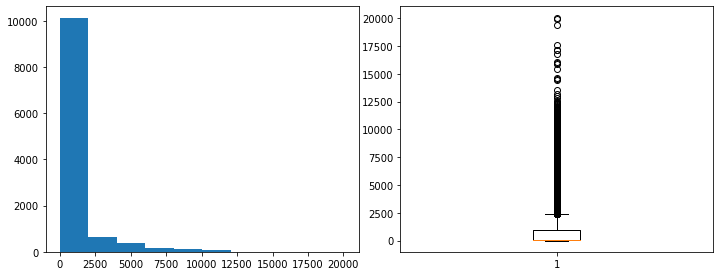


favorite_count_total all users log scale:


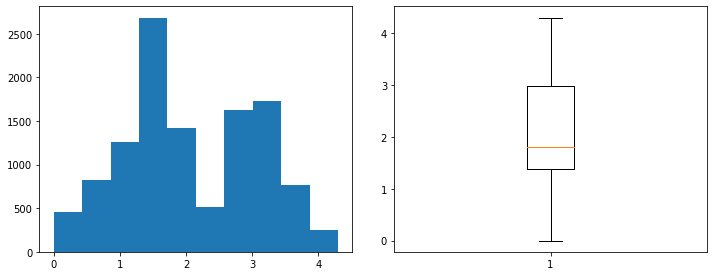


favorite_count_total real users normal scale:


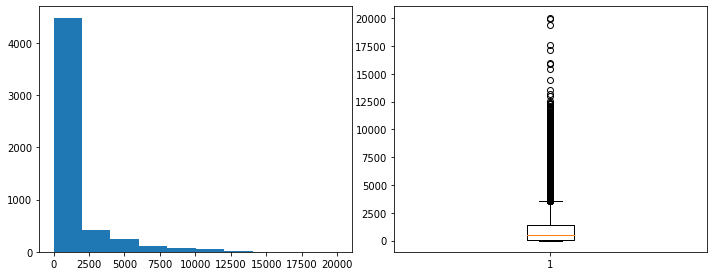


favorite_count_total real users log scale:


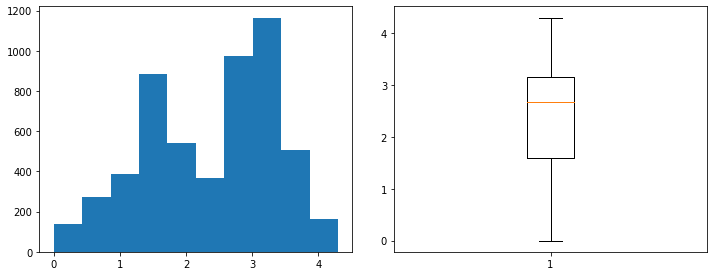


favorite_count_total bot users normal scale:


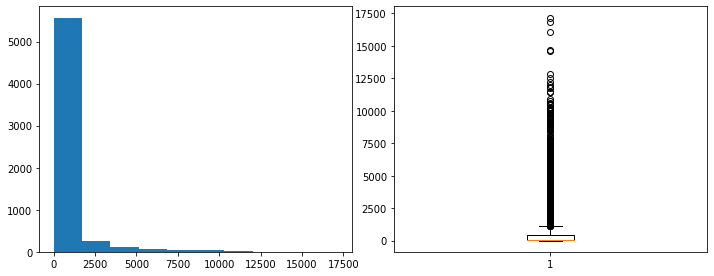


favorite_count_total bot users log scale:


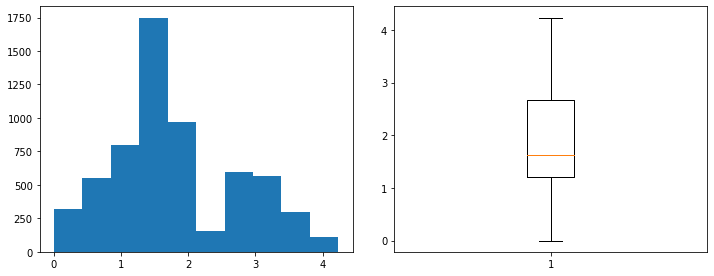

In [ ]:
visualize_distribution(col)

# Number of hashtags total

In [ ]:
col = "num_hashtags_total"
get_stats(col)

Mean: 140.63303788668753
Median: 21.0
Mode: [0]
Standard deviation: 184.6713195041781
Median absolute deviation: 19.0
1st quantile: 8.0
3rd quantile: 256.0
Minimum: 0
Maximum: 678



num_hashtags_total all users normal scale:


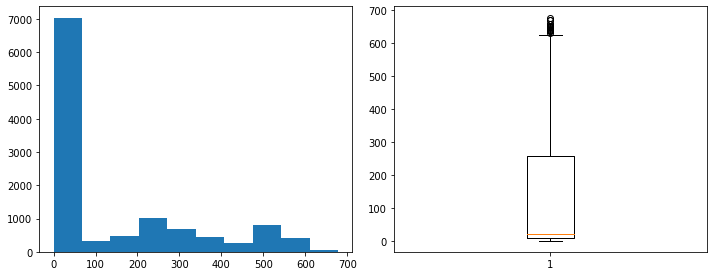


num_hashtags_total all users log scale:


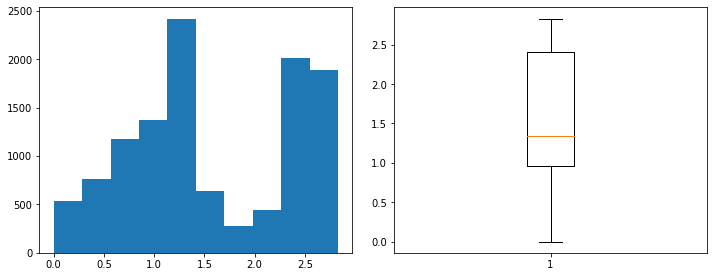


num_hashtags_total real users normal scale:


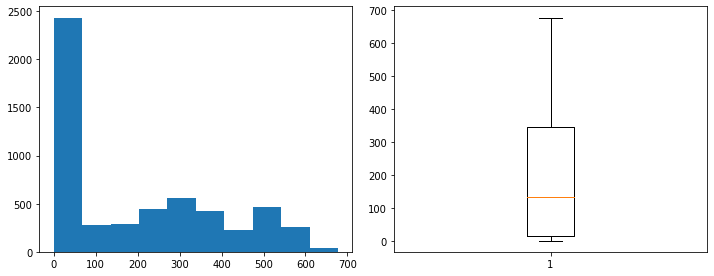


num_hashtags_total real users log scale:


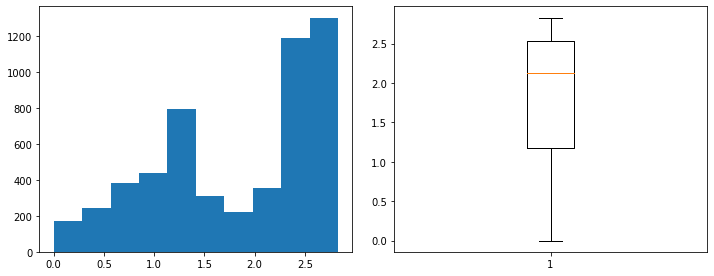


num_hashtags_total bot users normal scale:


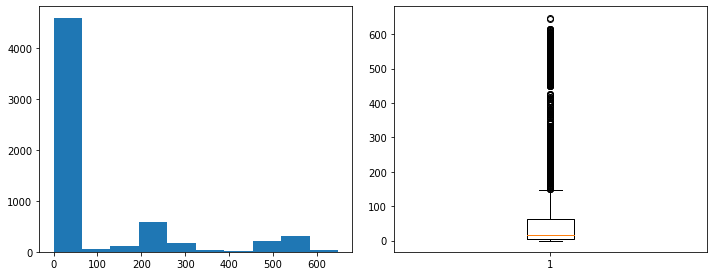


num_hashtags_total bot users log scale:


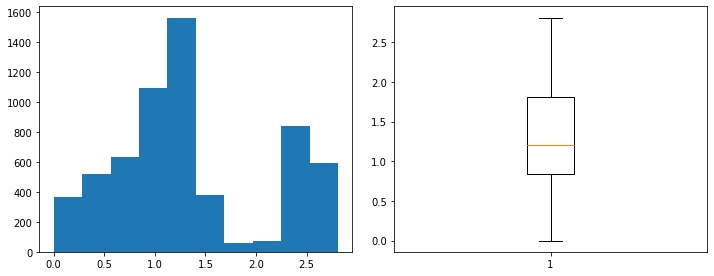

In [ ]:
visualize_distribution(col)

# Number of URLs total

In [ ]:
col = "num_urls_total"
get_stats(col)

Mean: 131.19169273548835
Median: 19.0
Mode: [3]
Standard deviation: 171.94909552227293
Median absolute deviation: 17.0
1st quantile: 8.0
3rd quantile: 238.0
Minimum: 0
Maximum: 635



num_urls_total all users normal scale:


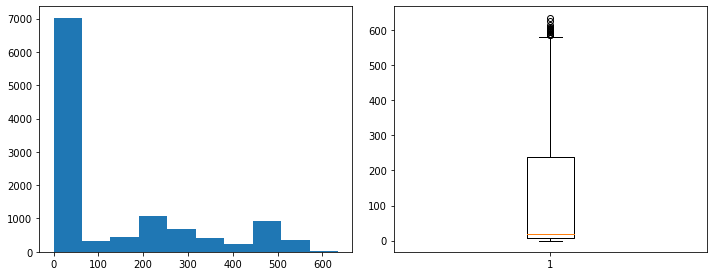


num_urls_total all users log scale:


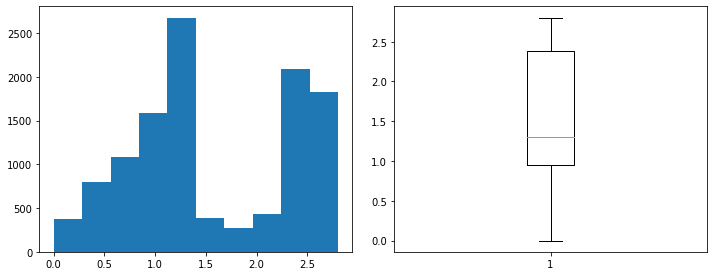


num_urls_total real users normal scale:


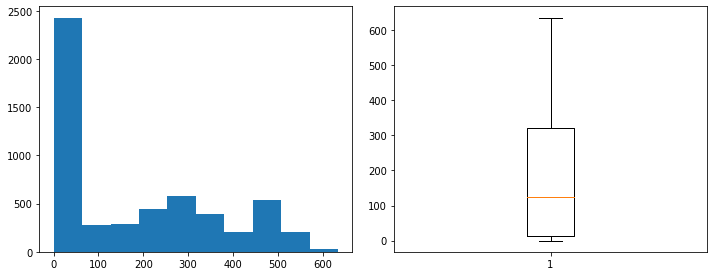


num_urls_total real users log scale:


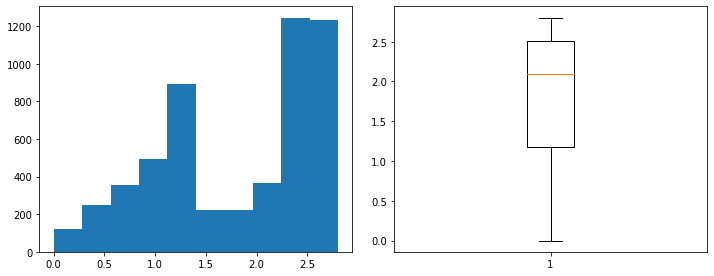


num_urls_total bot users normal scale:


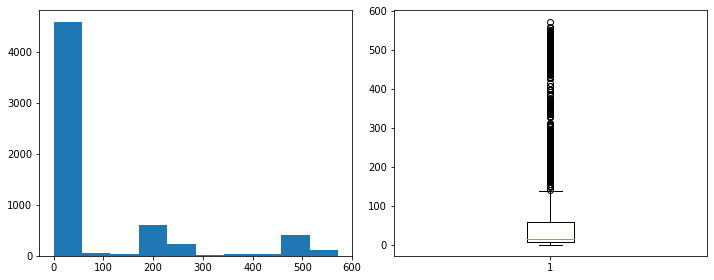


num_urls_total bot users log scale:


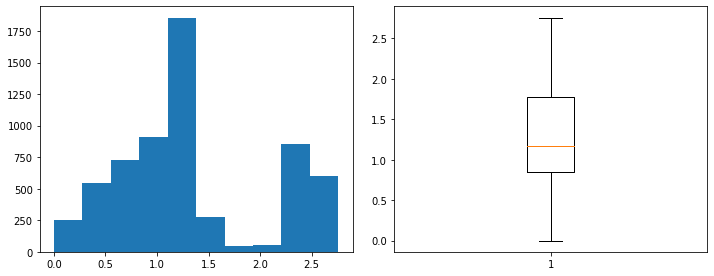

In [ ]:
visualize_distribution(col)

# Number of mentions total

In [ ]:
col = "num_mentions_total"
get_stats(col)

Mean: 433.8705248522767
Median: 62.0
Mode: [11]
Standard deviation: 567.1515995878859
Median absolute deviation: 54.0
1st quantile: 30.0
3rd quantile: 782.0
Minimum: 0
Maximum: 2002



num_mentions_total all users normal scale:


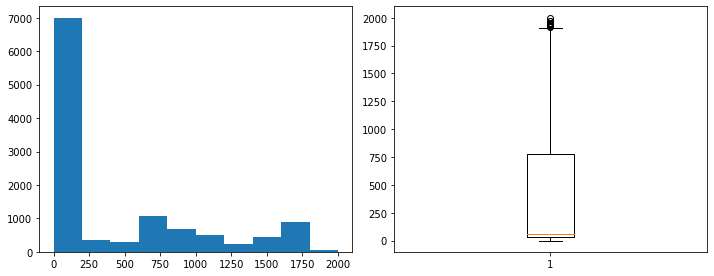


num_mentions_total all users log scale:


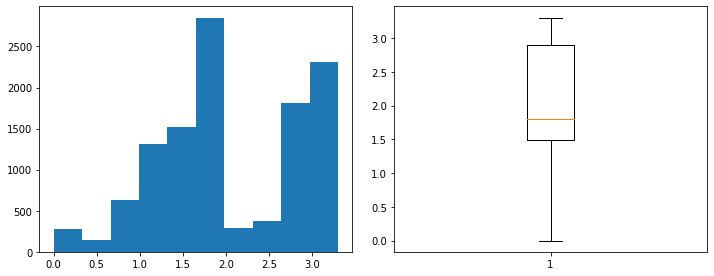


num_mentions_total real users normal scale:


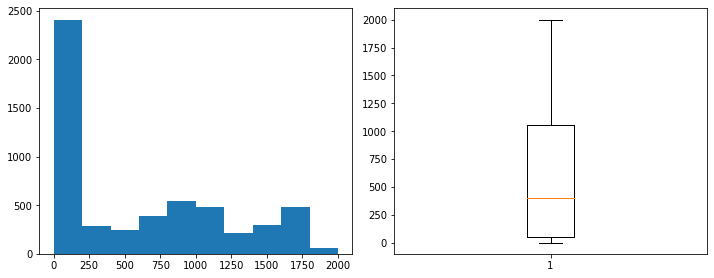


num_mentions_total real users log scale:


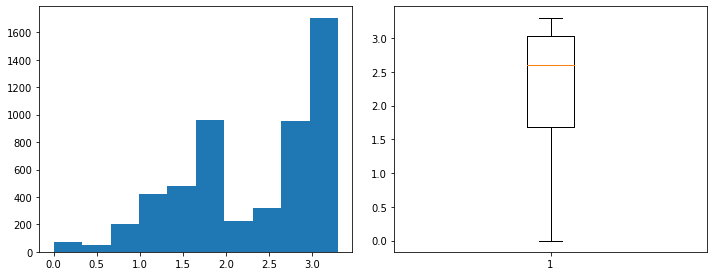


num_mentions_total bot users normal scale:


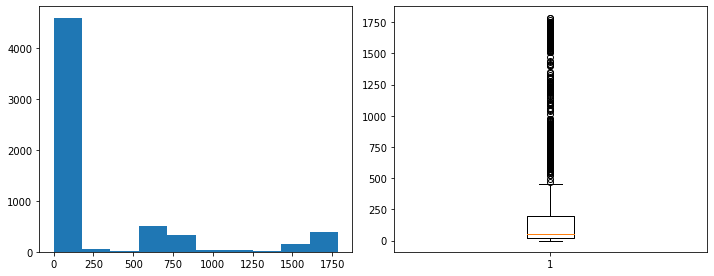


num_mentions_total bot users log scale:


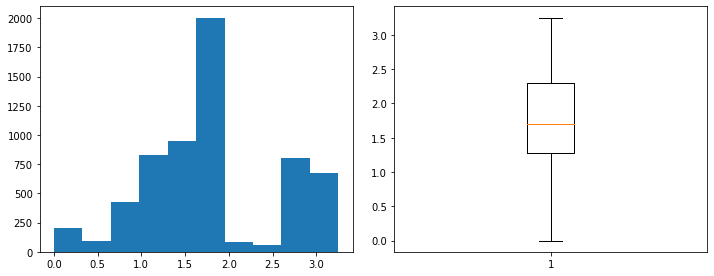

In [ ]:
visualize_distribution(col)

# Retweet count average

In [ ]:
col = "retweet_count_avg"
get_stats(col)

Mean: 481.4998076497854
Median: 342.0880586288416
Mode: [0.0]
Standard deviation: 1033.8400094219319
Median absolute deviation: 213.18603494029193
1st quantile: 119.32177835051546
3rd quantile: 540.8504129129128
Minimum: 0.0
Maximum: 40212.0



retweet_count_avg all users normal scale:


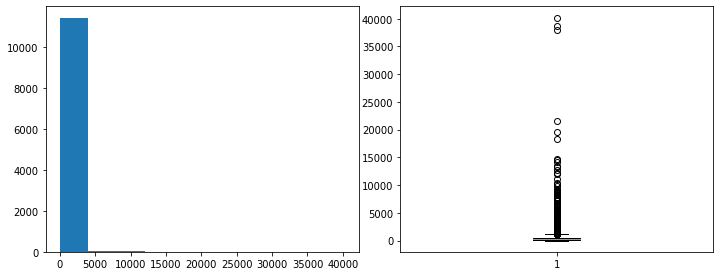


retweet_count_avg all users log scale:


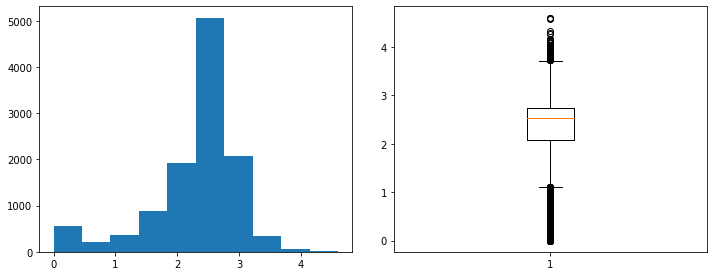


retweet_count_avg real users normal scale:


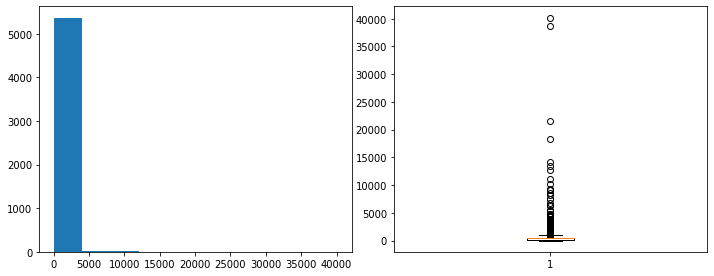


retweet_count_avg real users log scale:


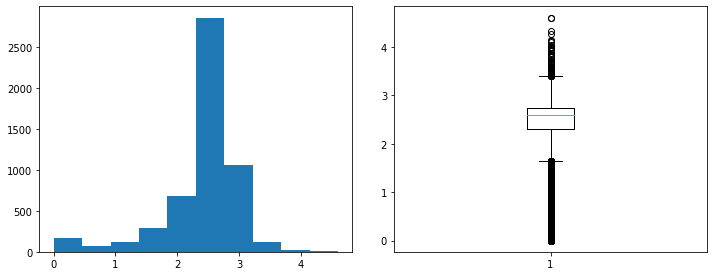


retweet_count_avg bot users normal scale:


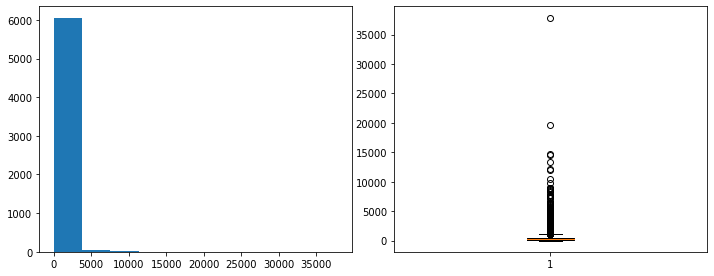


retweet_count_avg bot users log scale:


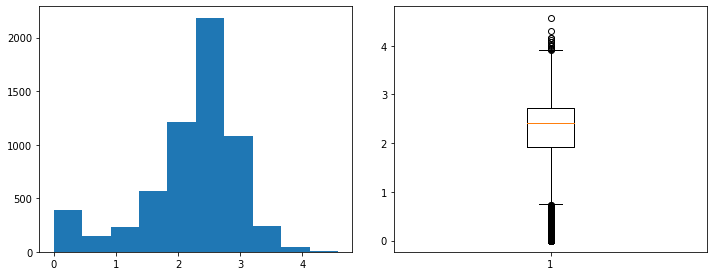

In [ ]:
visualize_distribution(col)



Real users theshold log scale 3.39849259765605, 1.6523818601530704
Real users theshold normal scale 2502.1829824500524, 43.91401297861551


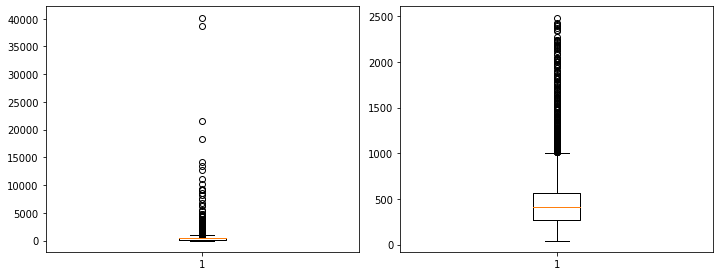

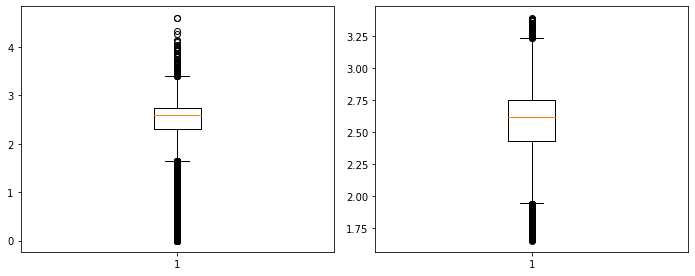



Bot users theshold log scale 3.9196488201442925, 0.728660650710877
Bot users theshold normal scale 8309.914608927233, 4.3537815991612


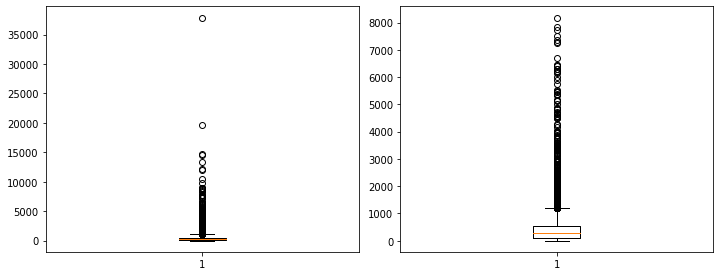

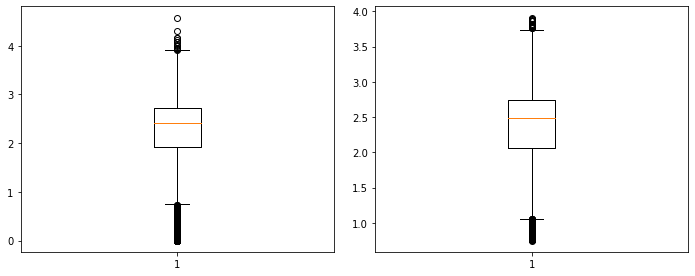

In [ ]:
# reals, bots = fix_outliers_log(col, upp_real=0.95, low_real = 0.05, upp_bot=0.95, low_bot=0.05)
# reals, bots = fix_outliers_boxplot_log(col)
reals, bots = fix_outliers_boxplot_log(col)

users.loc[reals.index.tolist(), col] = reals
users.loc[bots.index.tolist(), col] = bots

# Reply count average

In [ ]:
col = "reply_count_avg"
get_stats(col)

Mean: 0.03557888880405254
Median: 0.0
Mode: [0.0]
Standard deviation: 2.0892155007328643
Median absolute deviation: 0.0
1st quantile: 0.0
3rd quantile: 0.002201431152452575
Minimum: 0.0
Maximum: 222.25



reply_count_avg all users normal scale:


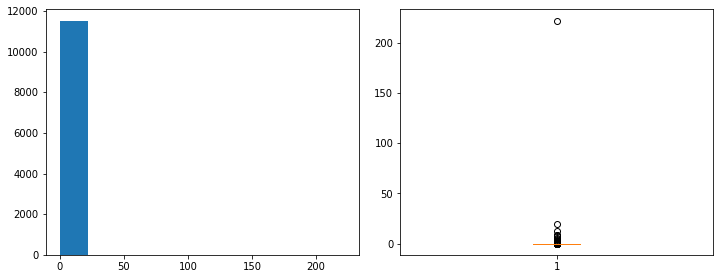


reply_count_avg all users log scale:


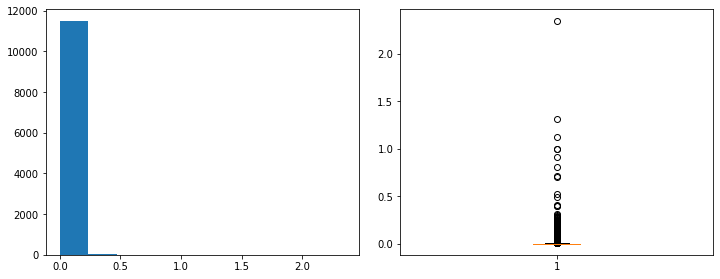


reply_count_avg real users normal scale:


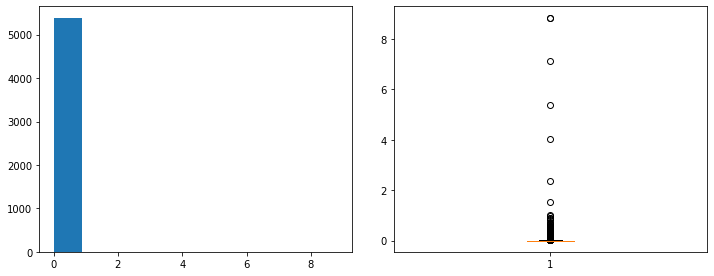


reply_count_avg real users log scale:


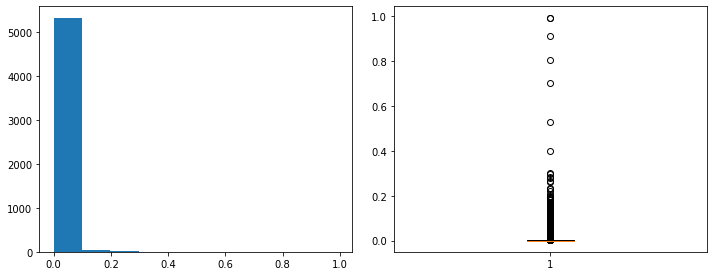


reply_count_avg bot users normal scale:


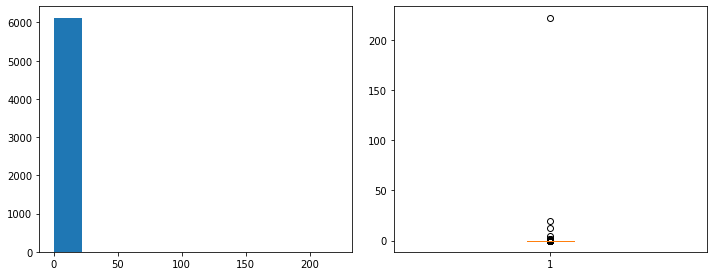


reply_count_avg bot users log scale:


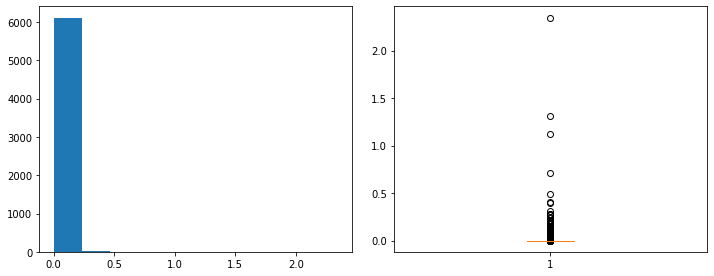

In [ ]:
visualize_distribution(col)



Real users theshold 0.440416884107423, 0


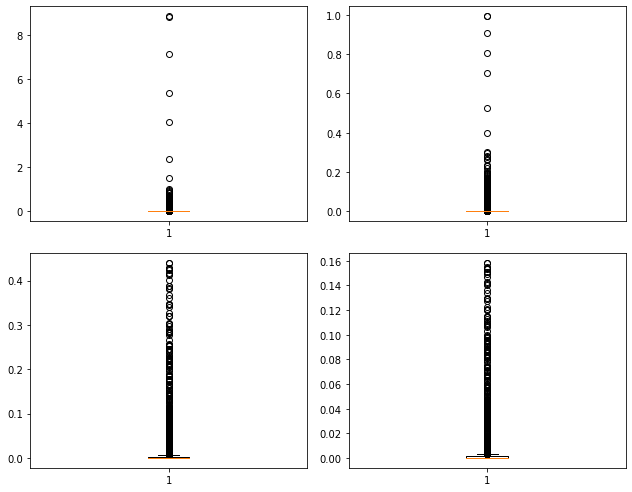


Bot users theshold 0.40088674412793845, 0


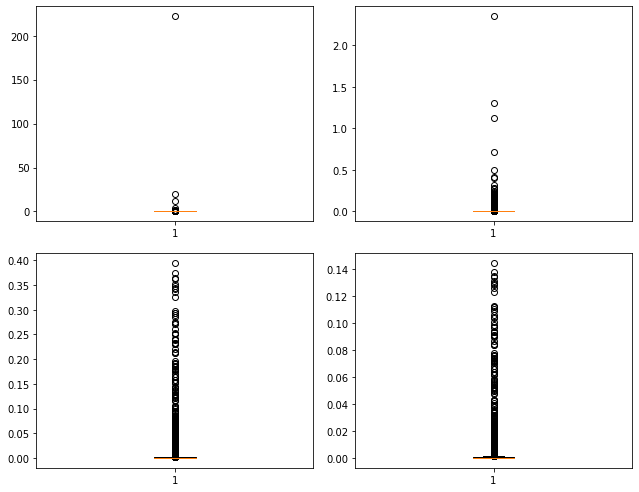

In [ ]:
reals, bots = fix_outliers_log(col, upp_real=0.995, low_real = -1, upp_bot=0.995, low_bot=-1)

users.loc[reals.index.tolist(), col] = reals
users.loc[bots.index.tolist(), col] = bots

# Favorite count average

In [ ]:
col = "favorite_count_avg"
get_stats(col)

Mean: 1.022269480482787
Median: 0.45244618964899075
Mode: [0.0]
Standard deviation: 5.721568024331929
Median absolute deviation: 0.1426534045198567
1st quantile: 0.3333333333333333
3rd quantile: 0.6596619597474016
Minimum: 0.0
Maximum: 364.1875



favorite_count_avg all users normal scale:


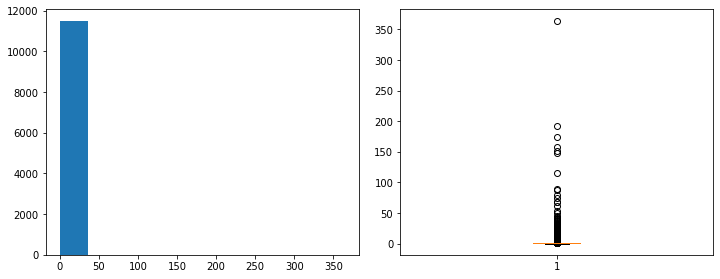


favorite_count_avg all users log scale:


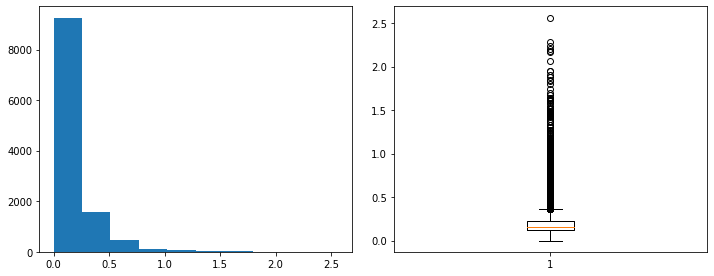


favorite_count_avg real users normal scale:


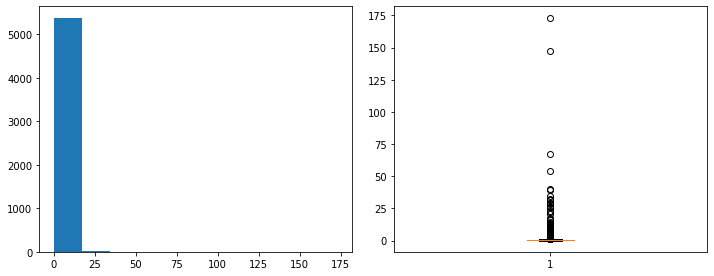


favorite_count_avg real users log scale:


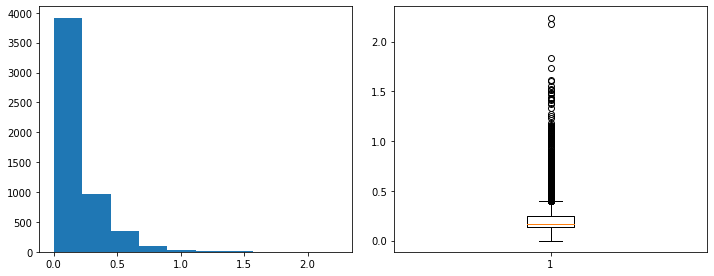


favorite_count_avg bot users normal scale:


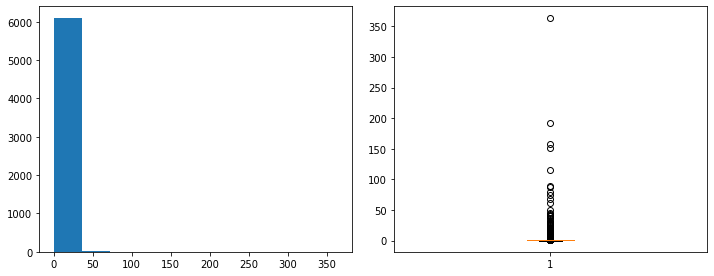


favorite_count_avg bot users log scale:


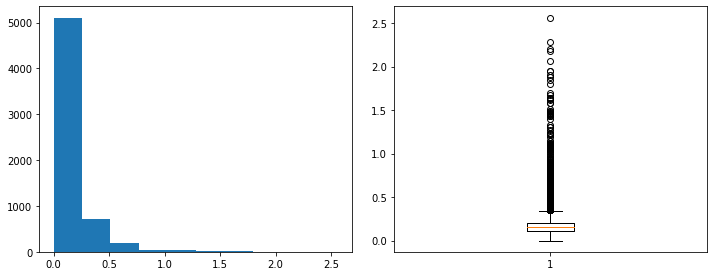

In [ ]:
visualize_distribution(col)



Real users theshold 13.15041786826152, 0


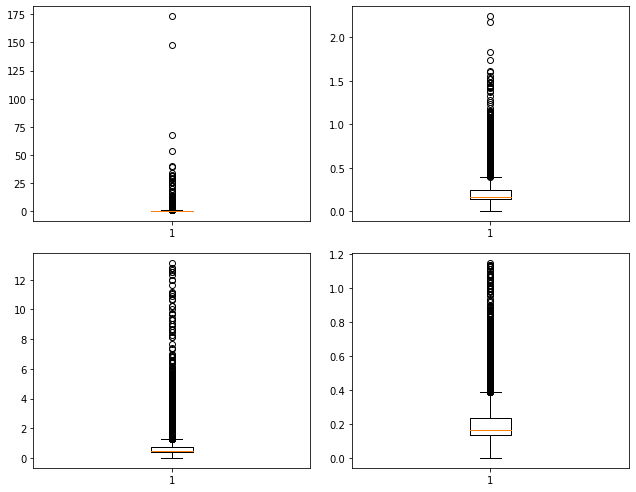


Bot users theshold 12.983024570024542, 0


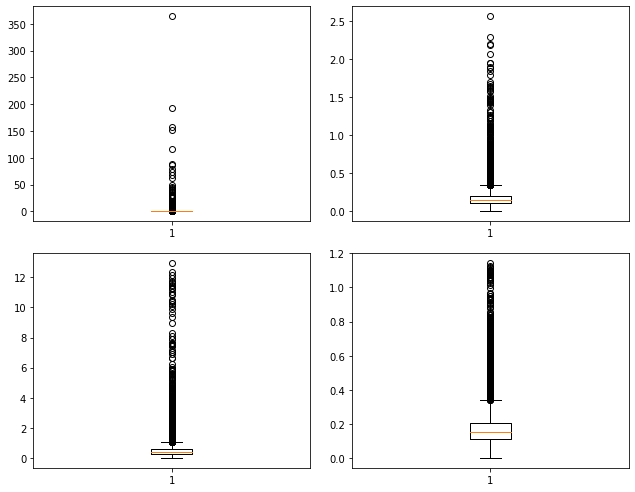

In [ ]:
# reals, bots = fix_outliers_log(col, upp_real=0.95, low_real = 0.12, upp_bot=0.95, low_bot=0.1)
# reals, bots = fix_outliers_boxplot_log(col)
reals, bots = fix_outliers_log(col, upp_real=0.995, low_real = -1, upp_bot=0.993, low_bot= -1)

users.loc[reals.index.tolist(), col] = reals
users.loc[bots.index.tolist(), col] = bots

# Number of hashtags average

In [ ]:
col = "num_hashtags_avg"
get_stats(col)

Mean: 0.15742116578287277
Median: 0.1549295774647887
Mode: [0.0]
Standard deviation: 0.10230121368911413
Median absolute deviation: 0.022489777373920994
1st quantile: 0.1276595744680851
3rd quantile: 0.17428854294422969
Minimum: 0.0
Maximum: 4.0



num_hashtags_avg all users normal scale:


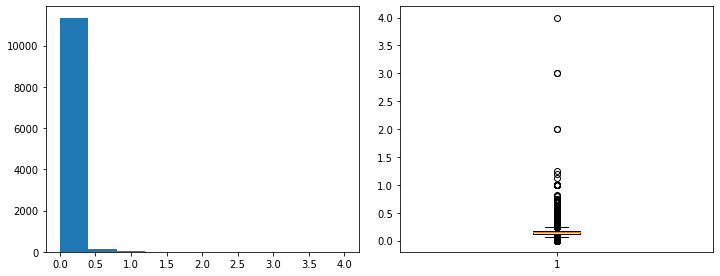


num_hashtags_avg all users log scale:


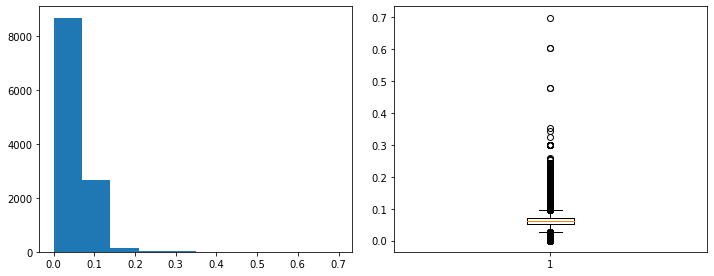


num_hashtags_avg real users normal scale:


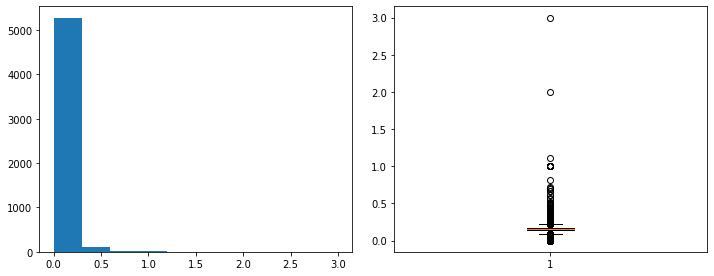


num_hashtags_avg real users log scale:


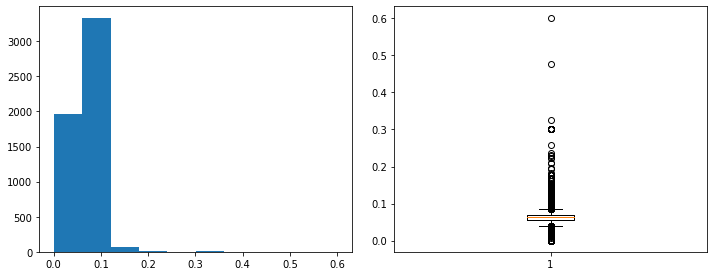


num_hashtags_avg bot users normal scale:


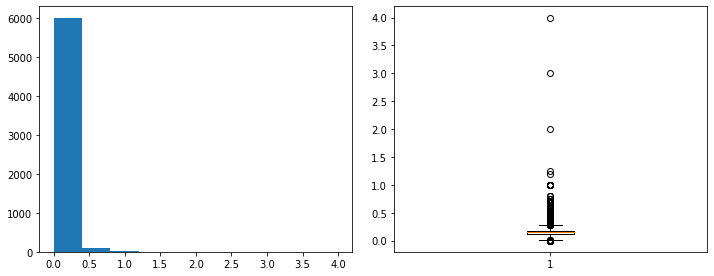


num_hashtags_avg bot users log scale:


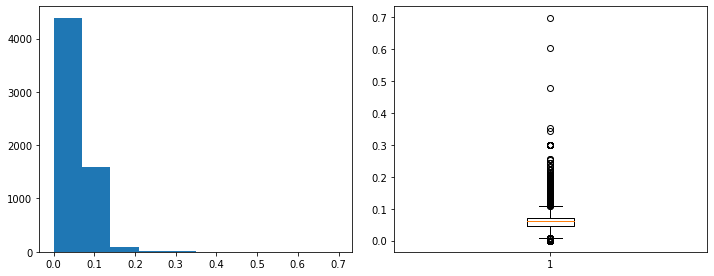

In [ ]:
visualize_distribution(col)



Real users theshold 0.5, 0.0952380952380952


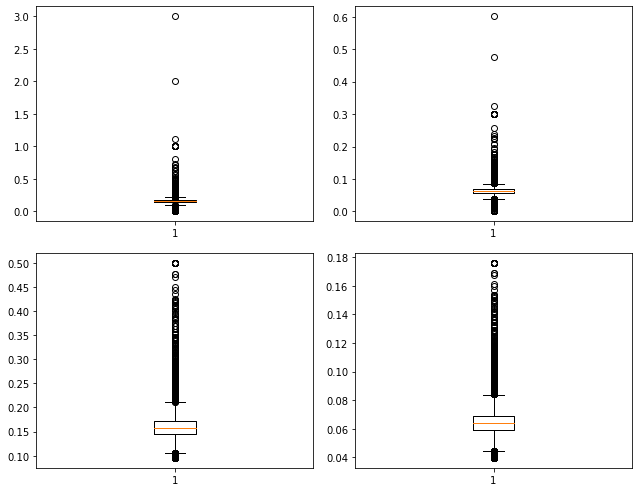


Bot users theshold 0.6666666666666666, 0.0581395348837209


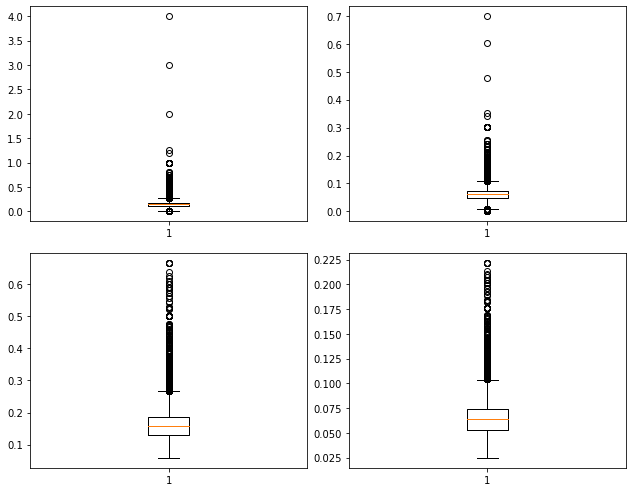

In [ ]:
reals, bots = fix_outliers_log(col, upp_real=0.995, low_real = 0.1, upp_bot=0.995, low_bot=0.1)

users.loc[reals.index.tolist(), col] = reals
users.loc[bots.index.tolist(), col] = bots

# Number of URLs average

In [ ]:
col = "num_urls_avg"
get_stats(col)

Mean: 0.14610401738127715
Median: 0.14627148363701695
Mode: [0.0]
Standard deviation: 0.06270545430406915
Median absolute deviation: 0.014196011938903741
1st quantile: 0.1304347826086956
3rd quantile: 0.15929745792122157
Minimum: 0.0
Maximum: 1.5



num_urls_avg all users normal scale:


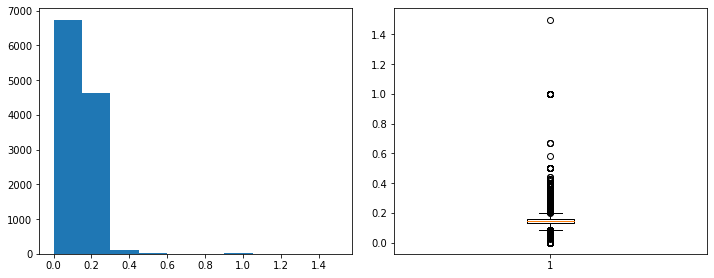


num_urls_avg all users log scale:


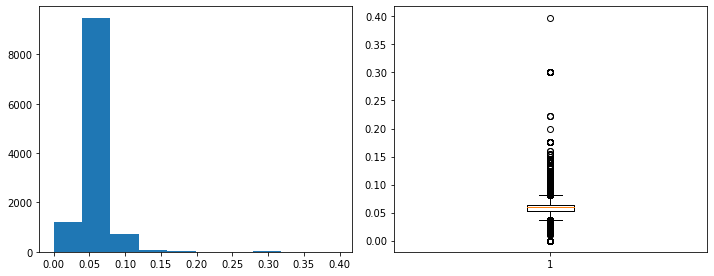


num_urls_avg real users normal scale:


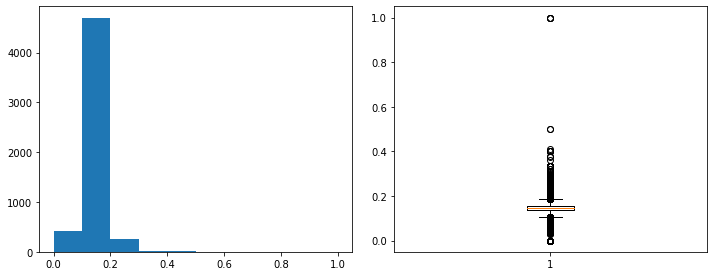


num_urls_avg real users log scale:


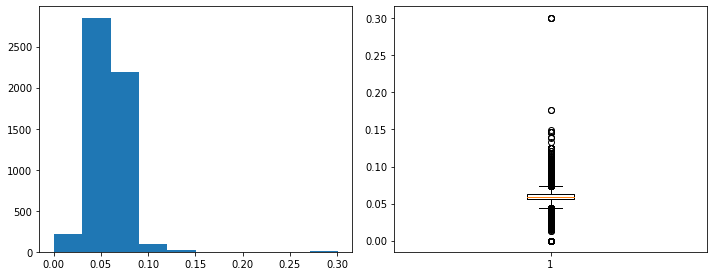


num_urls_avg bot users normal scale:


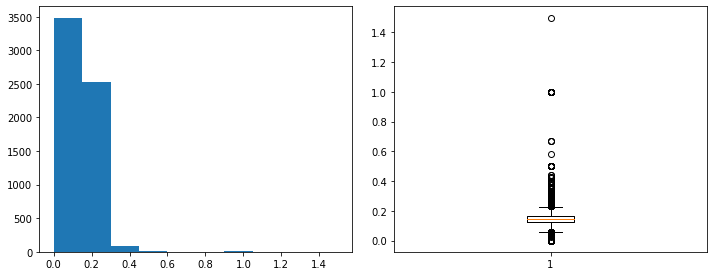


num_urls_avg bot users log scale:


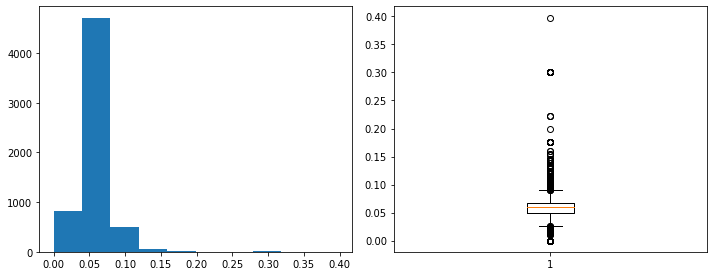

In [ ]:
visualize_distribution(col)



Real users theshold 0.3333333333333333, 0.10925682773109244


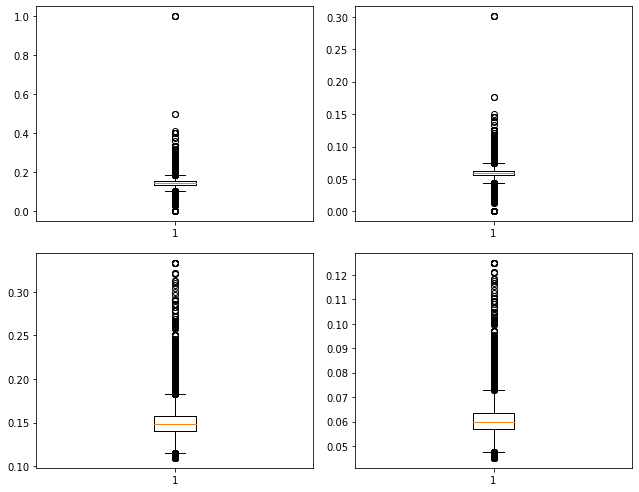


Bot users theshold 0.38922101449275537, 0.045120320855614925


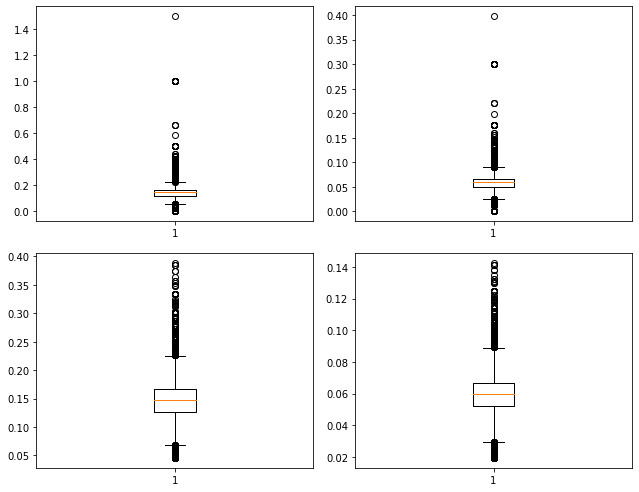

In [ ]:
reals, bots = fix_outliers_log(col, upp_real=0.995, low_real=0.1, upp_bot=0.9925, low_bot=0.05)
# reals, bots = fix_outliers_log_sigma(col, 2,2)
# reals, bots = fix_outliers_boxplot_log(col)

users.loc[reals.index.tolist(), col] = reals
users.loc[bots.index.tolist(), col] = bots

# Number of mentions average

In [ ]:
col = "num_mentions_avg"
get_stats(col)

Mean: 0.49040201828893787
Median: 0.4866713417484806
Mode: [0.5]
Standard deviation: 0.13736189567927265
Median absolute deviation: 0.03057003756186427
1st quantile: 0.4538881206642109
3rd quantile: 0.5151515151515151
Minimum: 0.0
Maximum: 4.0



num_mentions_avg all users normal scale:


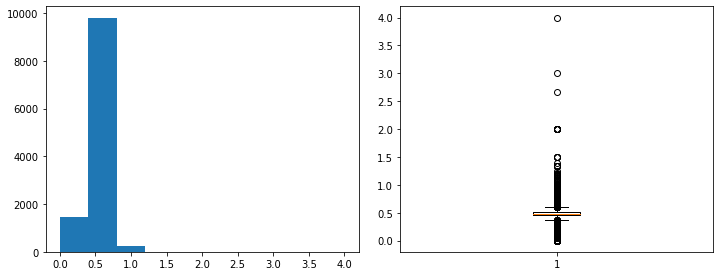


num_mentions_avg all users log scale:


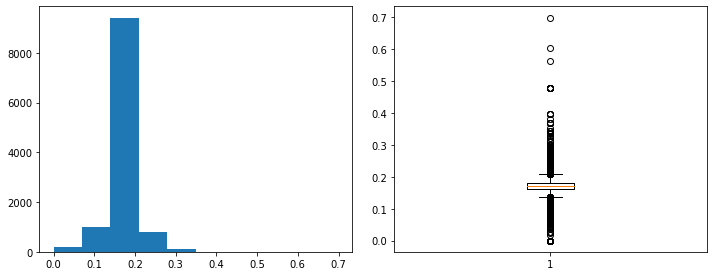


num_mentions_avg real users normal scale:


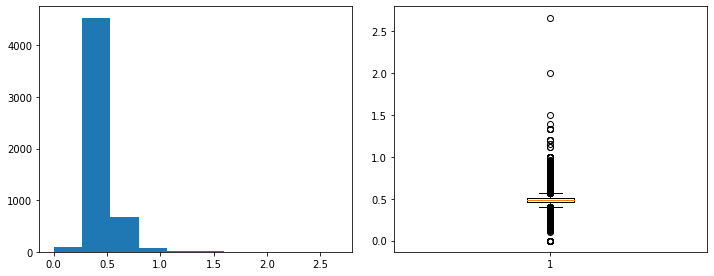


num_mentions_avg real users log scale:


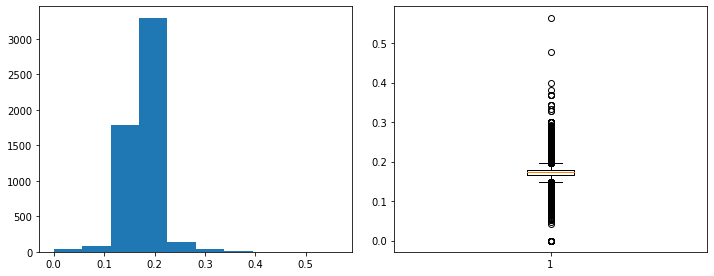


num_mentions_avg bot users normal scale:


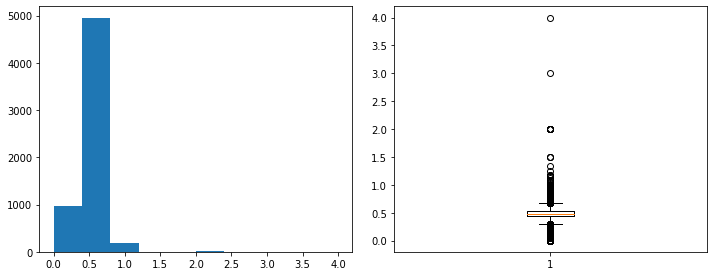


num_mentions_avg bot users log scale:


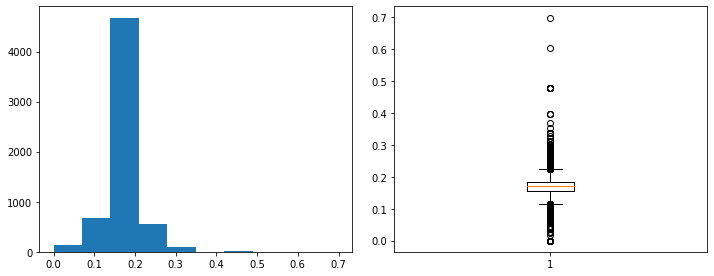

In [ ]:
visualize_distribution(col)



Real users theshold log scale 0.5704709882381434, 0.4019034535687418


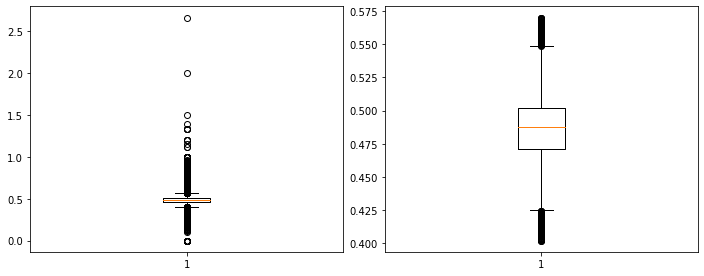



Real users theshold log scale 0.6666981870786219, 0.2956332616658702


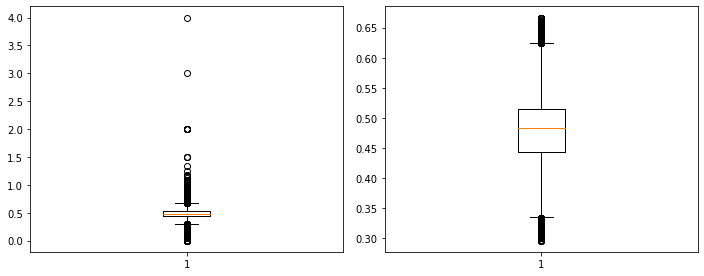

In [ ]:
# reals, bots = fix_outliers_log(col, upp_real=0.9, low_real = 0.05, upp_bot= 0.98, low_bot=0.12)
reals, bots = fix_outliers_boxplot(col)
# reals, bots = fix_outliers_sigma(col, 1, 1)

users.loc[reals.index.tolist(), col] = reals
users.loc[bots.index.tolist(), col] = bots

# Retweet count standard deviation

In [ ]:
col = "retweet_count_std"
get_stats(col)

Mean: 4307.613695084782
Median: 2906.034034697894
Mode: [0.0]
Standard deviation: 5239.878294755846
Median absolute deviation: 2573.187938131369
1st quantile: 602.5687142814749
3rd quantile: 6490.305774484336
Minimum: 0.0
Maximum: 79408.95139892821



retweet_count_std all users normal scale:


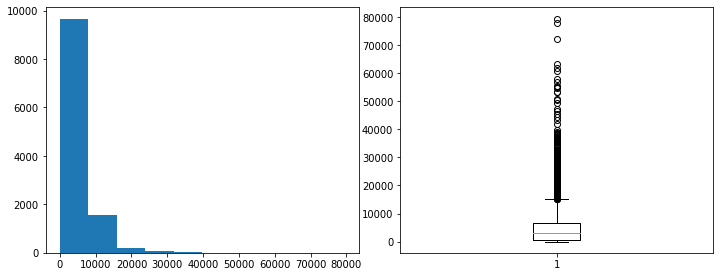


retweet_count_std all users log scale:


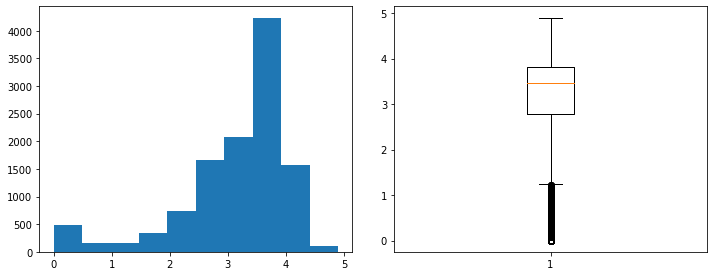


retweet_count_std real users normal scale:


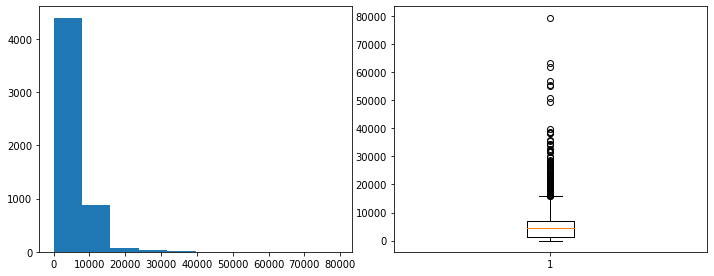


retweet_count_std real users log scale:


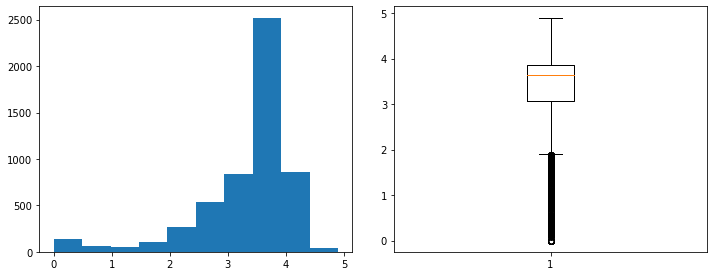


retweet_count_std bot users normal scale:


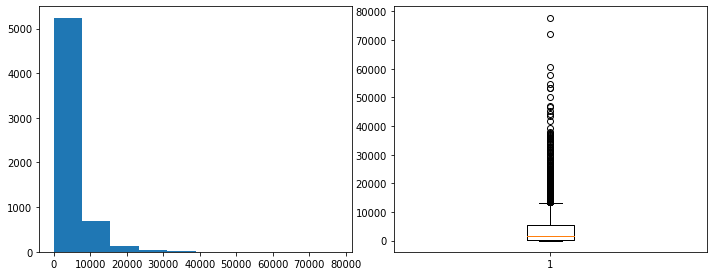


retweet_count_std bot users log scale:


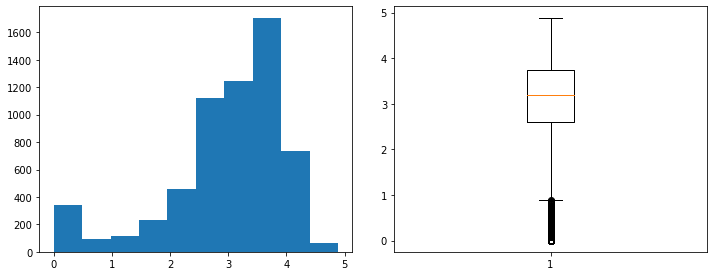

In [ ]:
visualize_distribution(col)



Real users theshold log scale 5.027177155782125, 1.8821633052380948
Real users theshold normal scale 106456.71880141088, 75.23656240642413


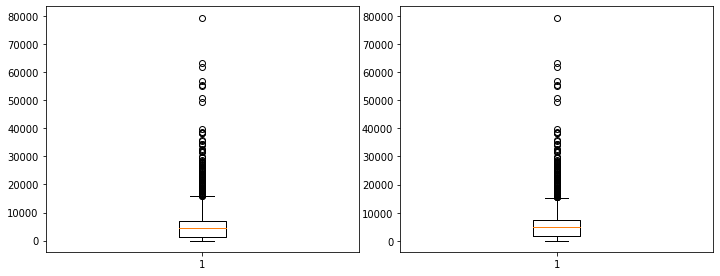

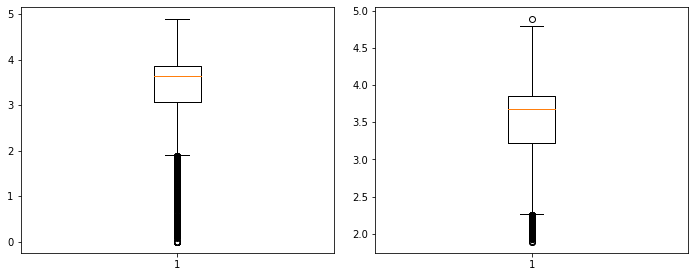



Bot users theshold log scale 5.46357935608989, 0.8811522381652166
Bot users theshold normal scale 290788.92543209734, 6.605928494440021


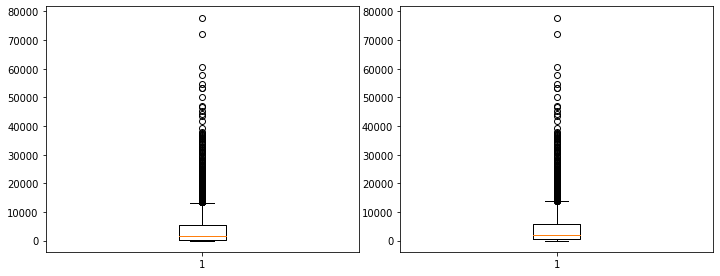

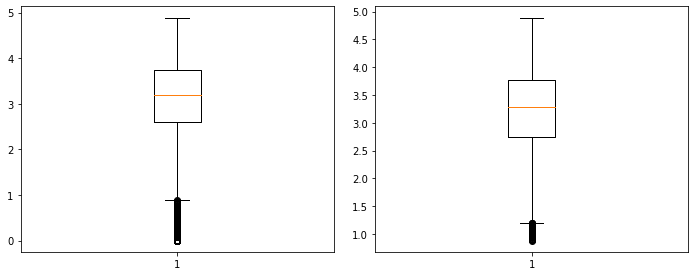

In [ ]:
# reals, bots = fix_outliers_log(col, upp_real=-1, low_real=-1, upp_bot=0.9999, low_bot=-1)
reals, bots = fix_outliers_boxplot_log(col)

users.loc[reals.index.tolist(), col] = reals
users.loc[bots.index.tolist(), col] = bots

# Reply count standard deviation

In [ ]:
col = "reply_count_std"
get_stats(col)

Mean: 0.3899373809028552
Median: 0.0
Mode: [0.0]
Standard deviation: 4.350341727950033
Median absolute deviation: 0.0
1st quantile: 0.0
3rd quantile: 0.052124514254025575
Minimum: 0.0
Maximum: 384.94829198218304



reply_count_std all users normal scale:


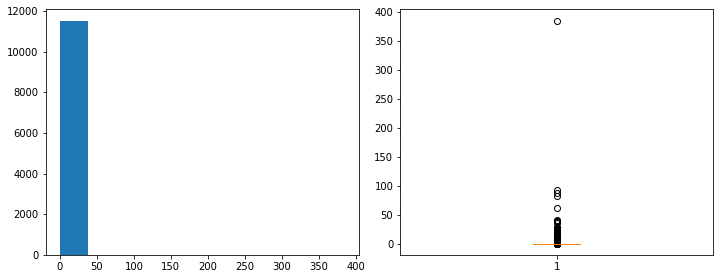


reply_count_std all users log scale:


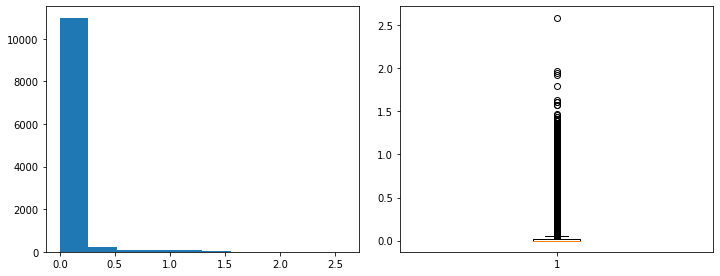


reply_count_std real users normal scale:


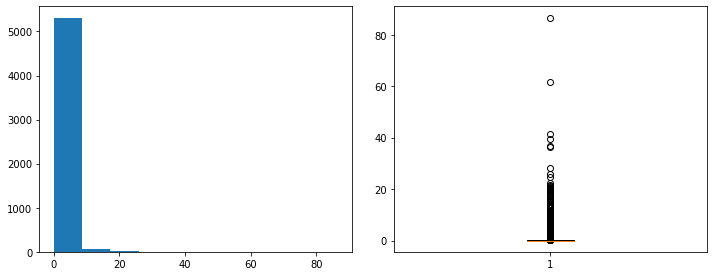


reply_count_std real users log scale:


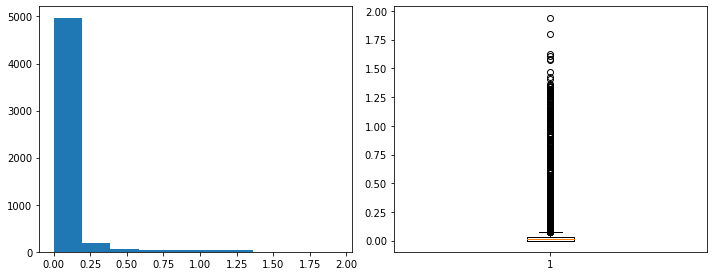


reply_count_std bot users normal scale:


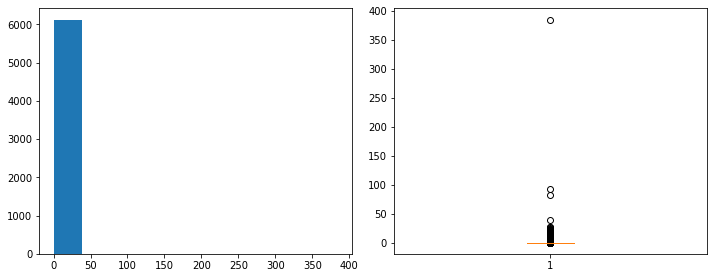


reply_count_std bot users log scale:


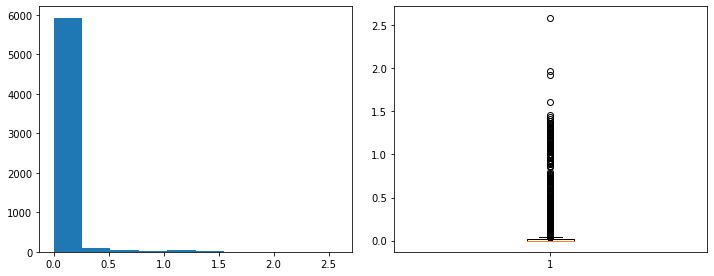

In [ ]:
visualize_distribution(col)



Real users theshold 17.780518690539626, 0


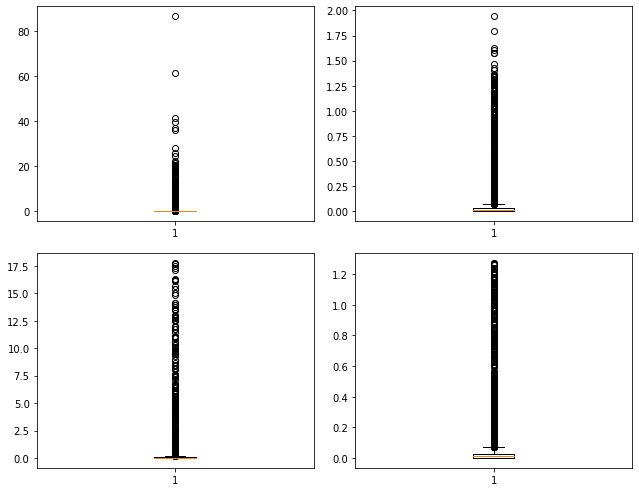


Bot users theshold 13.963276714885653, 0


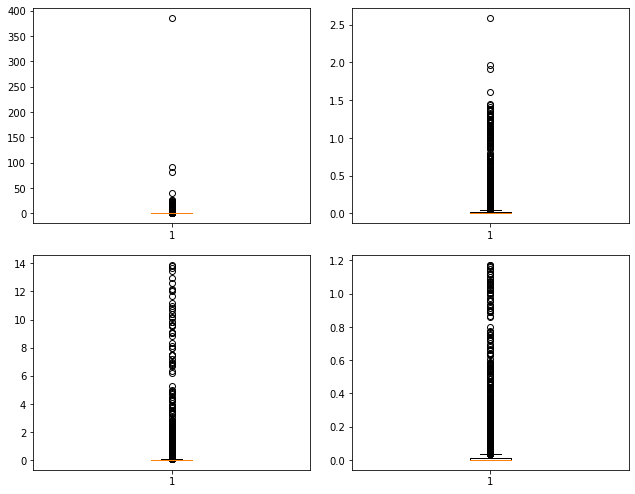

In [ ]:
reals, bots = fix_outliers_log(col, upp_real=0.995, low_real = -1, upp_bot=0.995, low_bot=-1)
# users.loc[reals.index.tolist(), col] = reals
# users.loc[bots.index.tolist(), col] = bots

# Favorite count standard deviation

In [ ]:
col = "favorite_count_std"
get_stats(col)

Mean: 13.49122109551476
Median: 1.7093962717951425
Mode: [0.0]
Standard deviation: 45.428246864731754
Median absolute deviation: 0.9650261706465658
1st quantile: 0.9427980840941841
3rd quantile: 3.8649596711526786
Minimum: 0.0
Maximum: 1410.2339441893143



favorite_count_std all users normal scale:


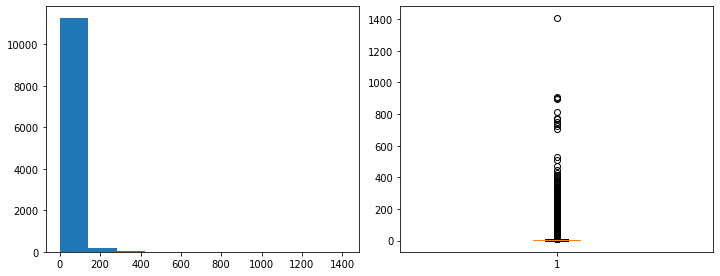


favorite_count_std all users log scale:


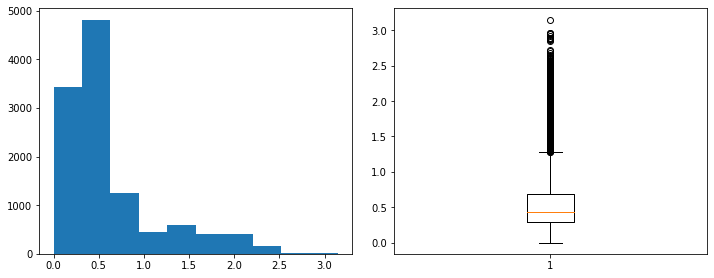


favorite_count_std real users normal scale:


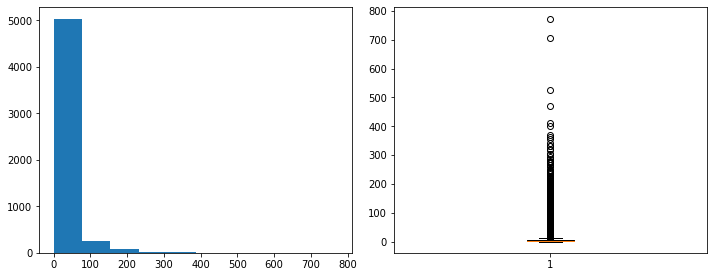


favorite_count_std real users log scale:


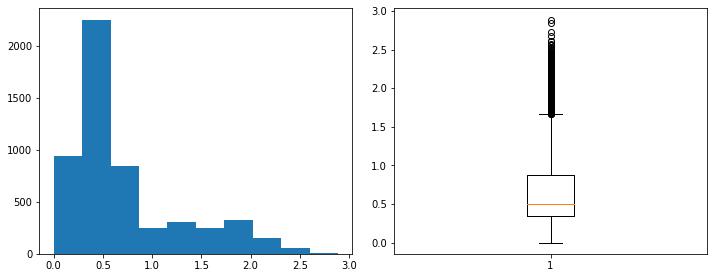


favorite_count_std bot users normal scale:


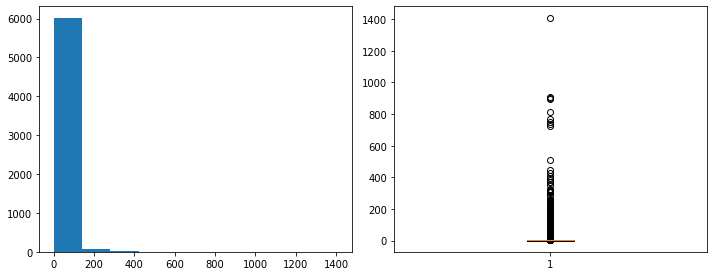


favorite_count_std bot users log scale:


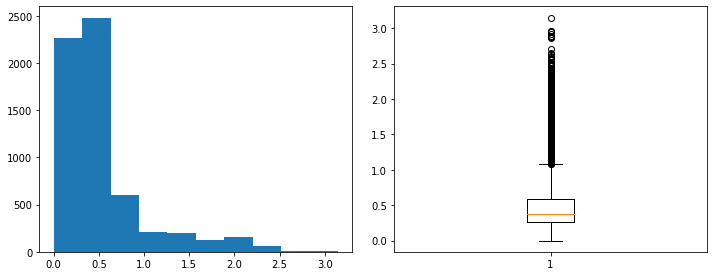

In [ ]:
visualize_distribution(col)



Real users theshold log scale 1.6629925680311026, -0.4504262068713203
Real users theshold normal scale 45.0248697397305, -0.6455346458698366


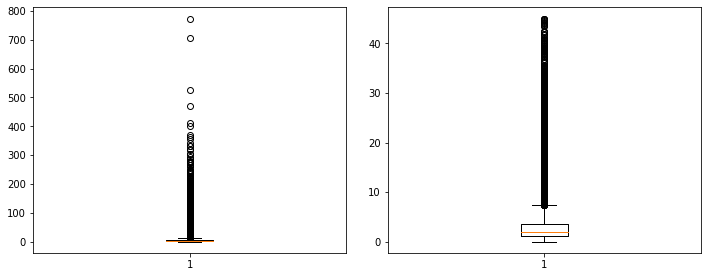

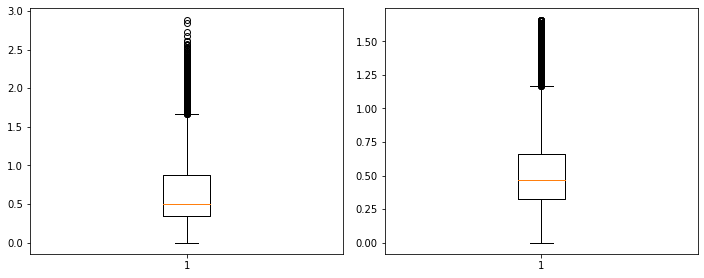



Bot users theshold log scale 1.083796575964421, -0.23443138575347805
Bot users theshold normal scale 11.128206308174978, -0.4171341454190013


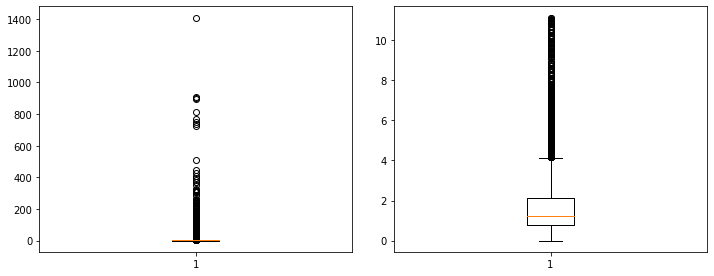

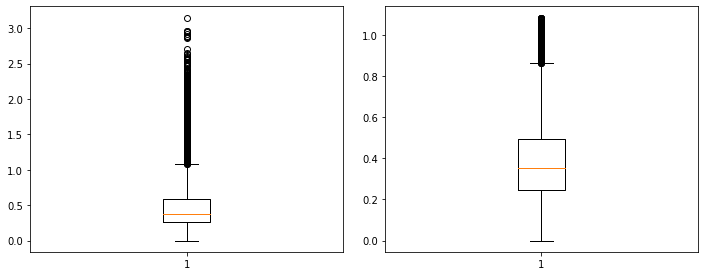

In [ ]:
# reals, bots = fix_outliers_log(col, upp_real=0.95, low_real = -1, upp_bot=0.95, low_bot=-1)
reals, bots = fix_outliers_boxplot_log(col)

users.loc[reals.index.tolist(), col] = reals
users.loc[bots.index.tolist(), col] = bots

# Number of hashtags standard deviation

In [ ]:
col = "num_hashtags_std"
get_stats(col)

Mean: 0.5317956531444484
Median: 0.5532688667929002
Mode: [0.0]
Standard deviation: 0.22257827897648502
Median absolute deviation: 0.08555497854196009
1st quantile: 0.4356975347719813
3rd quantile: 0.6213884020958983
Minimum: 0.0
Maximum: 3.755503458708792



num_hashtags_std all users normal scale:


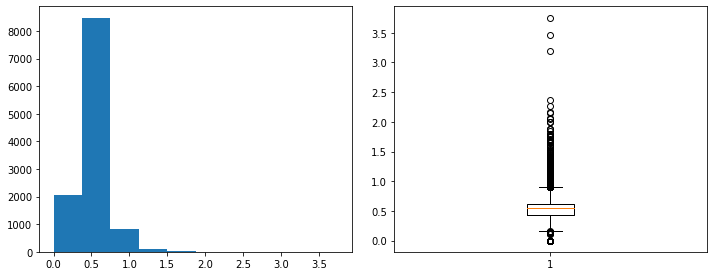


num_hashtags_std all users log scale:


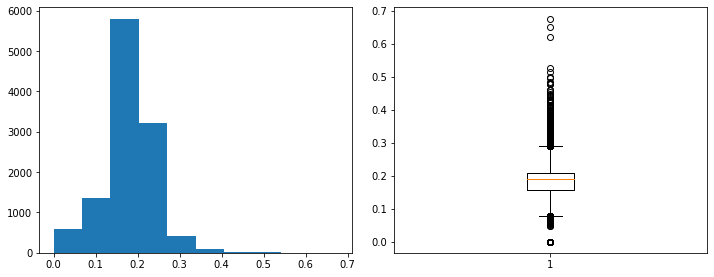


num_hashtags_std real users normal scale:


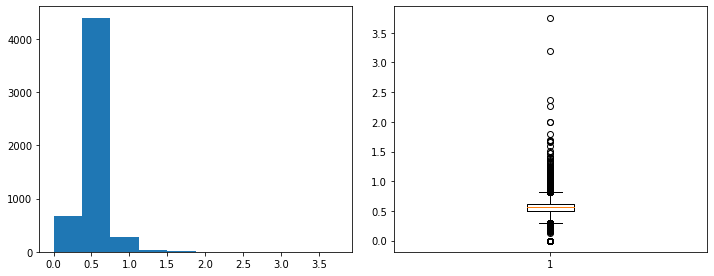


num_hashtags_std real users log scale:


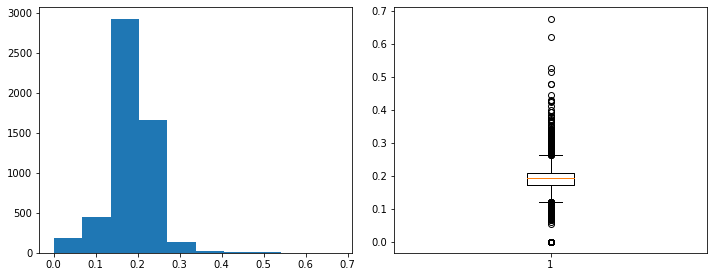


num_hashtags_std bot users normal scale:


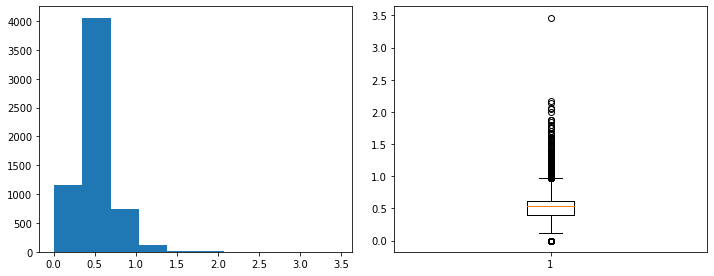


num_hashtags_std bot users log scale:


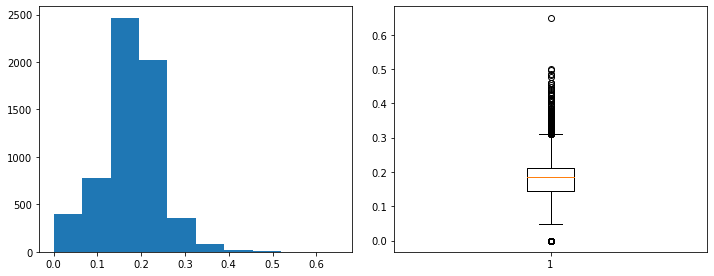

In [ ]:
visualize_distribution(col)



Real users theshold log scale 0.2635393412581981, 0.11941087360083727
Real users theshold normal scale 0.8345913489735992, 0.31646971761029774


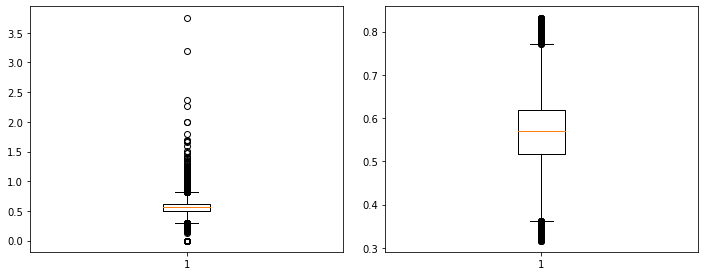

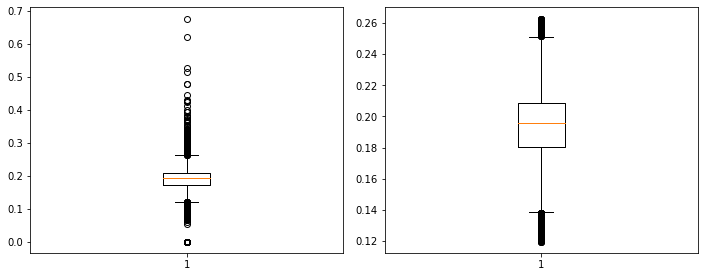



Bot users theshold log scale 0.31050200990113785, 0.04348081493217271
Bot users theshold normal scale 1.0440993960078986, 0.10530164132671205


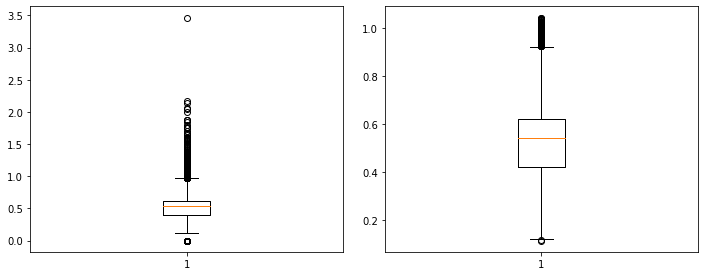

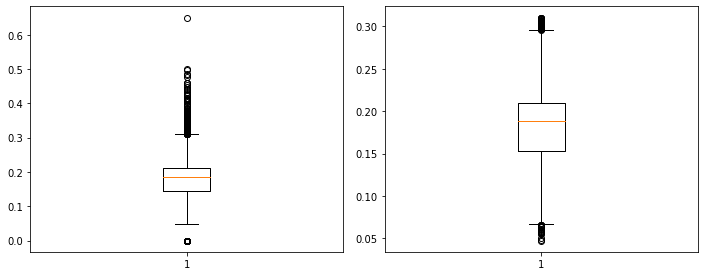

In [ ]:
# reals, bots = fix_outliers_log(col, upp_real=0.99, low_real = 0.05, upp_bot=0.99, low_bot=0.1)
reals, bots = fix_outliers_boxplot_log(col)
# reals, bots = fix_outliers_log_sigma(col, 3, 2)

users.loc[reals.index.tolist(), col] = reals
users.loc[bots.index.tolist(), col] = bots

# Number of URLs standard deviation

In [ ]:
col = "num_urls_std"
get_stats(col)

Mean: 0.34500173950494206
Median: 0.35864271346227516
Mode: [0.0]
Standard deviation: 0.07797468990617094
Median absolute deviation: 0.01570180898621204
1st quantile: 0.3392971595164746
3rd quantile: 0.3726779962499649
Minimum: 0.0
Maximum: 0.7556372504853024



num_urls_std all users normal scale:


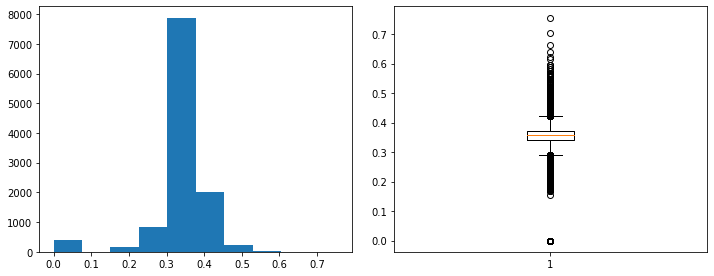


num_urls_std all users log scale:


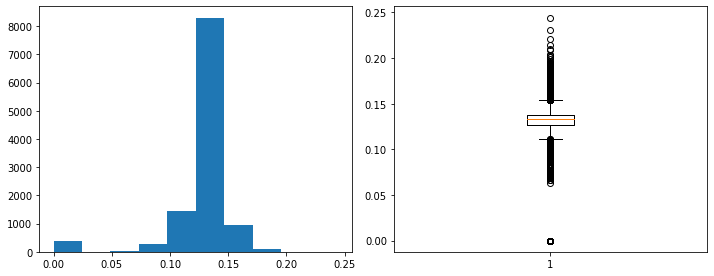


num_urls_std real users normal scale:


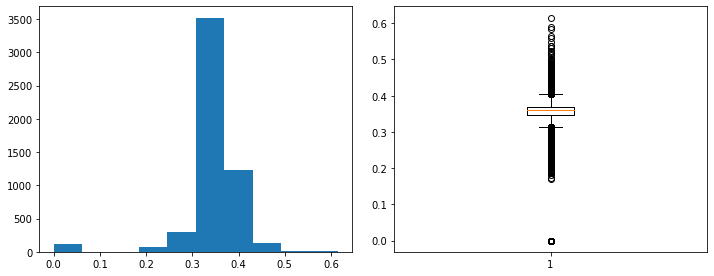


num_urls_std real users log scale:


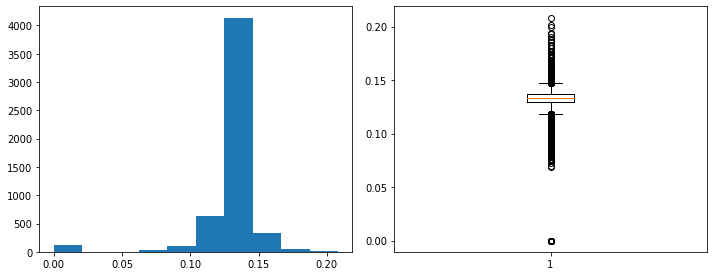


num_urls_std bot users normal scale:


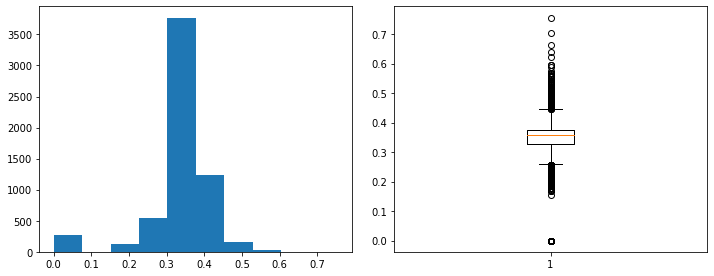


num_urls_std bot users log scale:


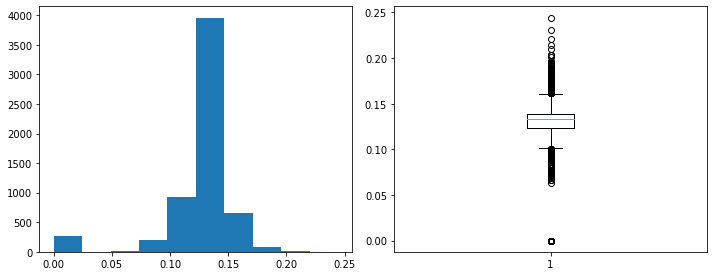

In [ ]:
visualize_distribution(col)



Real users theshold log scale 0.40382111612261845, 0.31306144866893876


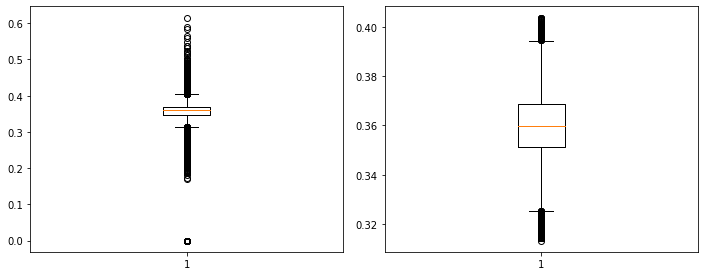



Real users theshold log scale 0.446188239098105, 0.2586754158013457


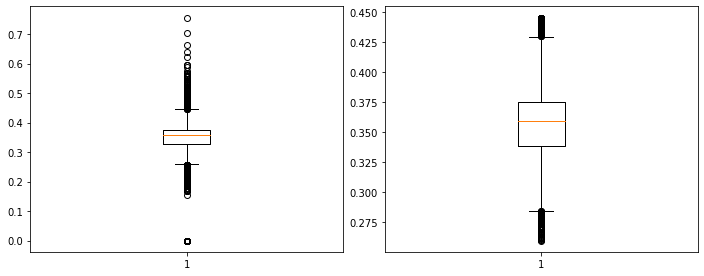

In [ ]:
# reals, bots = fix_outliers_log(col, upp_real=0.99, low_real =0.05, upp_bot=0.99, low_bot=0.05)
reals, bots = fix_outliers_boxplot(col)
# reals, bots = fix_outliers_sigma(col, 5, 5)

users.loc[reals.index.tolist(), col] = reals
users.loc[bots.index.tolist(), col] = bots

# Number of mentions standard deviation

In [ ]:
col = "num_mentions_std"
get_stats(col)

Mean: 0.7578915072700418
Median: 0.7709493570873551
Mode: [0.0]
Standard deviation: 0.19741684797331366
Median absolute deviation: 0.06992211966244372
1st quantile: 0.6771235800061483
3rd quantile: 0.8278158492981043
Minimum: 0.0
Maximum: 4.123105625617661



num_mentions_std all users normal scale:


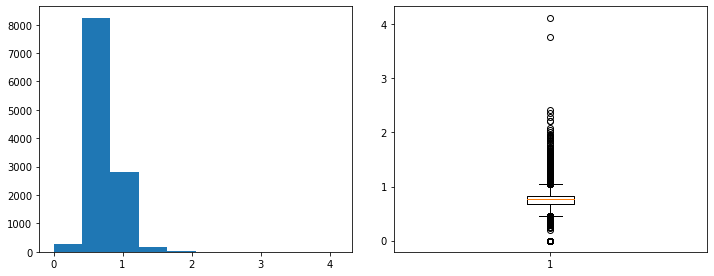


num_mentions_std all users log scale:


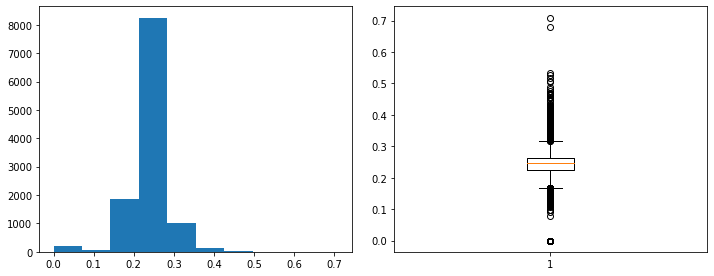


num_mentions_std real users normal scale:


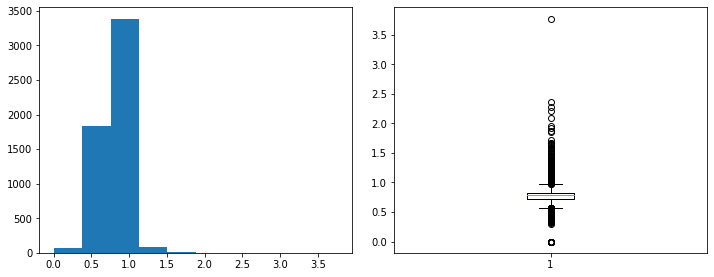


num_mentions_std real users log scale:


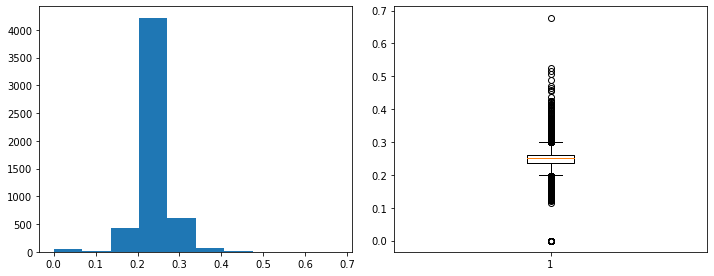


num_mentions_std bot users normal scale:


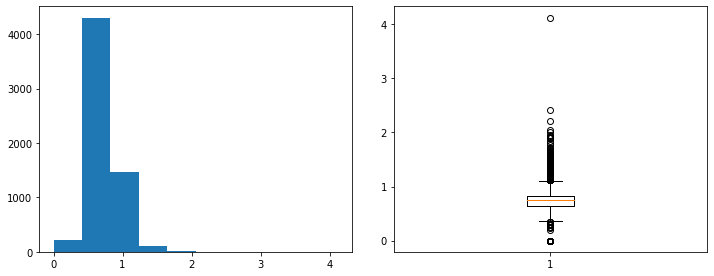


num_mentions_std bot users log scale:


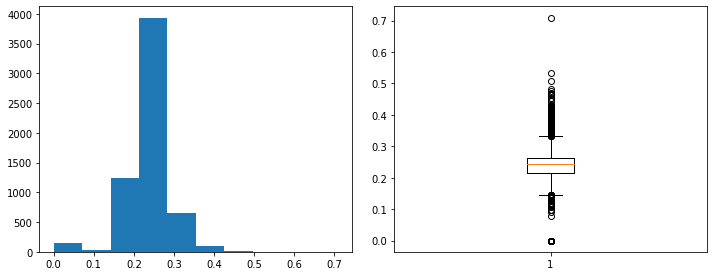

In [ ]:
visualize_distribution(col)



Real users theshold log scale 0.98103401142969, 0.5673575465767262


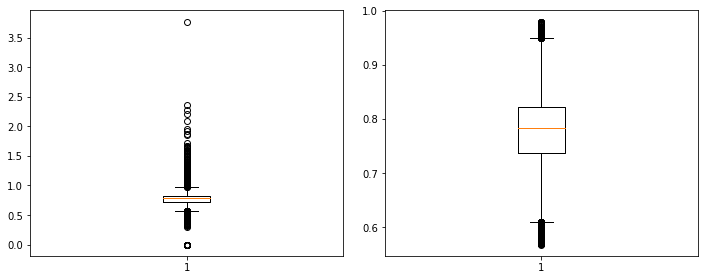



Real users theshold log scale 1.1120251719750058, 0.3600773601928092


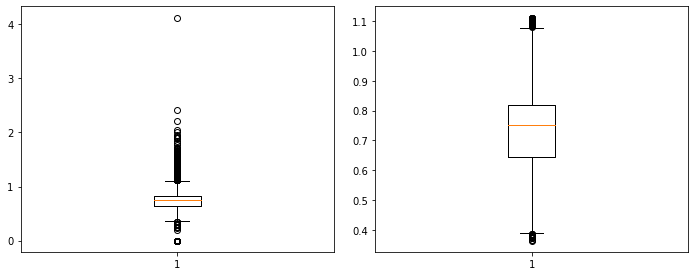

In [ ]:
# reals, bots = fix_outliers_log(col, upp_real=0.99, low_real = 0.02, upp_bot=0.999, low_bot=0.03)
reals, bots = fix_outliers_boxplot(col)


users.loc[reals.index.tolist(), col] = reals
users.loc[bots.index.tolist(), col] = bots

# Retweet count entropy

In [ ]:
col = "retweet_count_entropy"
get_stats(col)

Mean: 1.8259247162197716
Median: 1.9415692160728424
Mode: [-0.0]
Standard deviation: 0.4996569927586728
Median absolute deviation: 0.311554690197557
1st quantile: 1.5569010760354054
3rd quantile: 2.2250893702704824
Minimum: -0.0
Maximum: 3.021234342638516



retweet_count_entropy all users normal scale:


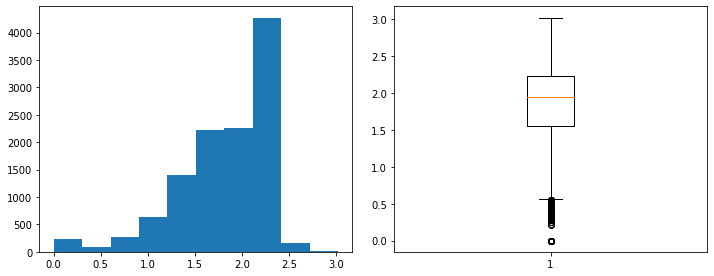


retweet_count_entropy all users log scale:


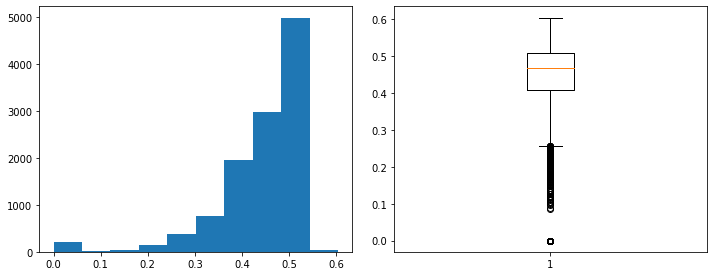


retweet_count_entropy real users normal scale:


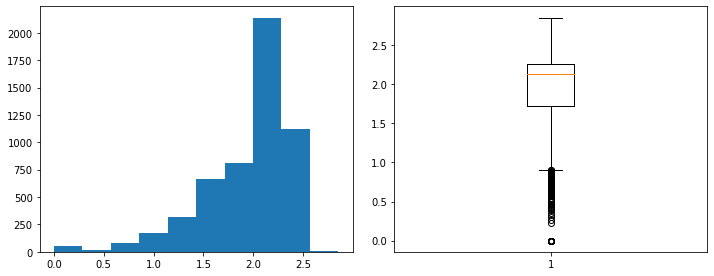


retweet_count_entropy real users log scale:


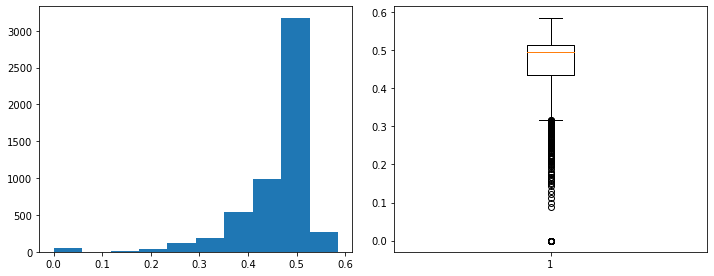


retweet_count_entropy bot users normal scale:


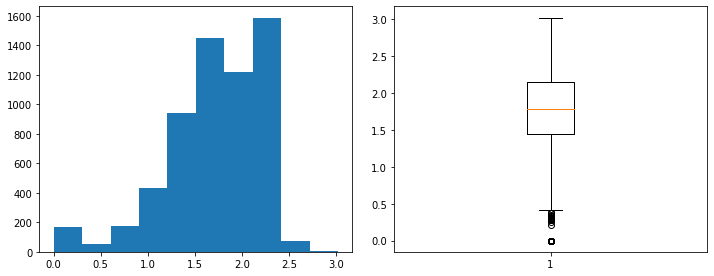


retweet_count_entropy bot users log scale:


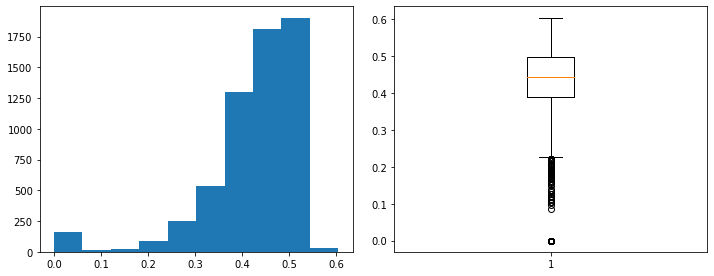

In [ ]:
visualize_distribution(col)



Real users theshold log scale 3.0793702780952437, 0.904371820300222


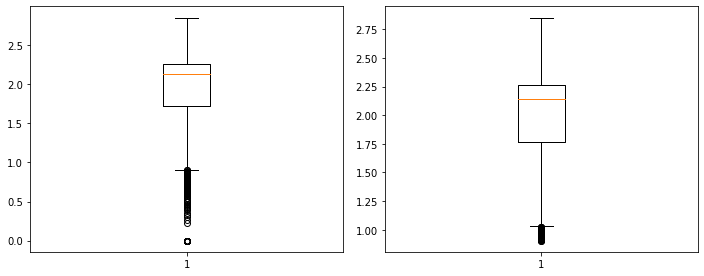



Real users theshold log scale 3.190782803539205, 0.40011698608161006


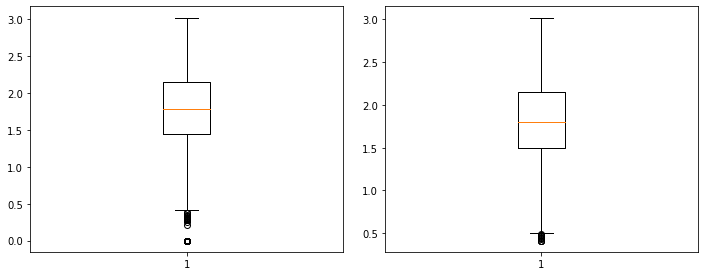

In [ ]:
reals, bots = fix_outliers_boxplot(col)

users.loc[reals.index.tolist(), col] = reals
users.loc[bots.index.tolist(), col] = bots

# Reply count entropy

In [ ]:
col = "reply_count_entropy"
get_stats(col)

Mean: 0.012886702612954219
Median: 0.0
Mode: [-0.0]
Standard deviation: 0.0300651797800416
Median absolute deviation: 0.0
1st quantile: -0.0
3rd quantile: 0.017232534946138526
Minimum: -0.0
Maximum: 1.0



reply_count_entropy all users normal scale:


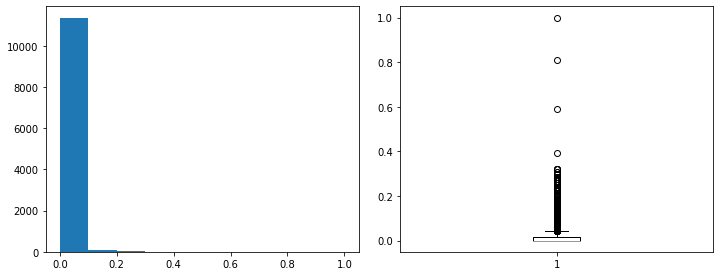


reply_count_entropy all users log scale:


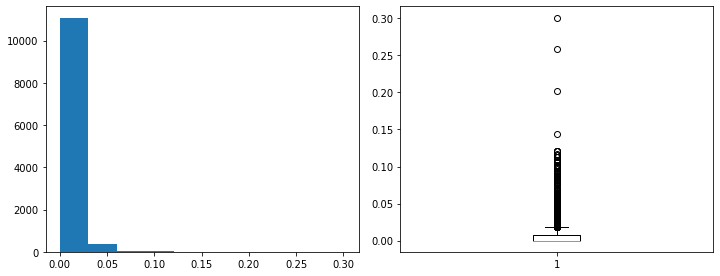


reply_count_entropy real users normal scale:


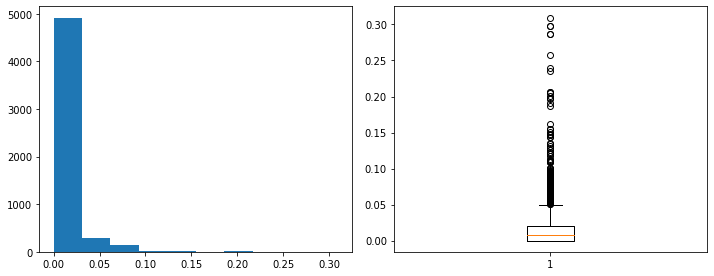


reply_count_entropy real users log scale:


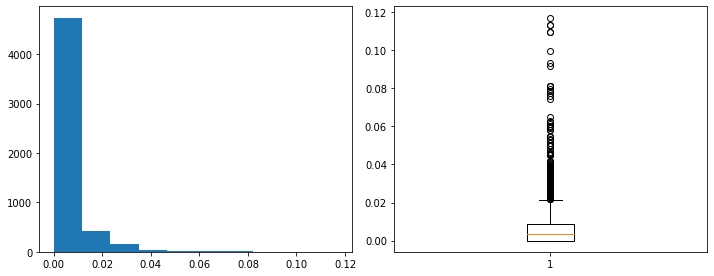


reply_count_entropy bot users normal scale:


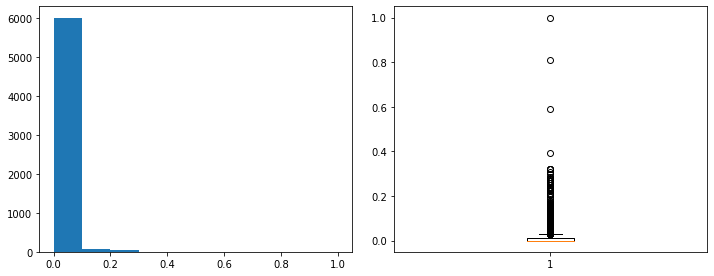


reply_count_entropy bot users log scale:


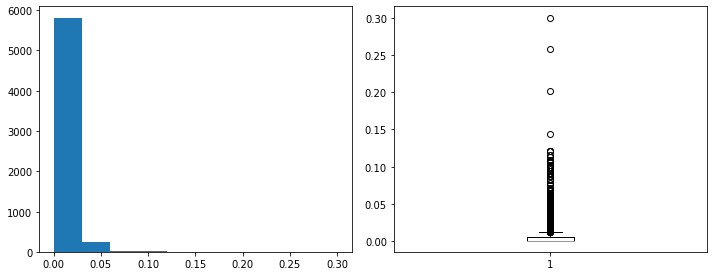

In [ ]:
visualize_distribution(col)



Real users theshold 0.10537059700784537, 0


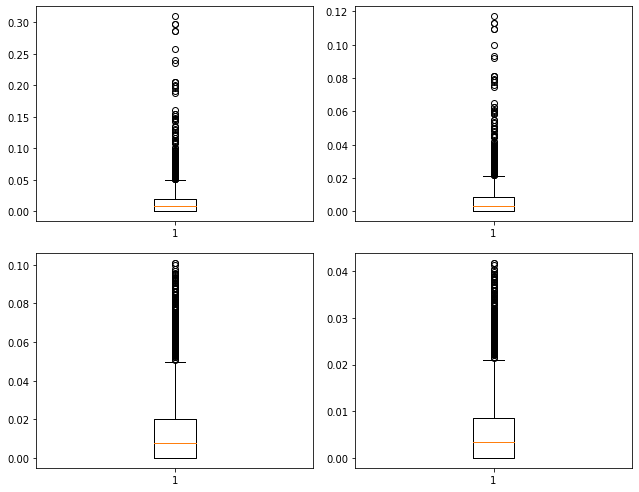


Bot users theshold 0.17505478973052763, 0


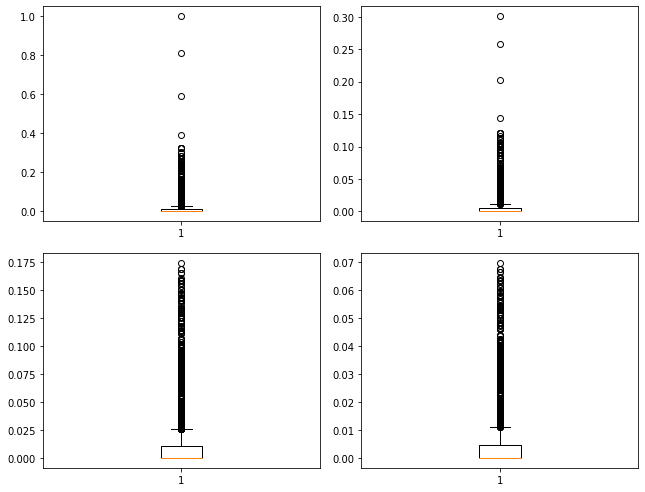

In [ ]:
reals, bots = fix_outliers_log(col, upp_real=0.9925, low_real = -1, upp_bot=0.9925, low_bot=-1)

users.loc[reals.index.tolist(), col] = reals
users.loc[bots.index.tolist(), col] = bots

# Favorite count entropy

In [ ]:
col = "favorite_count_entropy"
get_stats(col)

Mean: 0.9460965080759294
Median: 1.0091149497272456
Mode: [-0.0]
Standard deviation: 0.24391261863595526
Median absolute deviation: 0.07579155481888378
1st quantile: 0.8832499449051279
3rd quantile: 1.0646008092410983
Minimum: -0.0
Maximum: 1.9993896755123952



favorite_count_entropy all users normal scale:


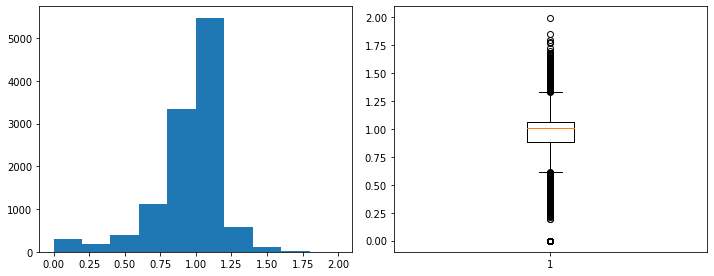


favorite_count_entropy all users log scale:


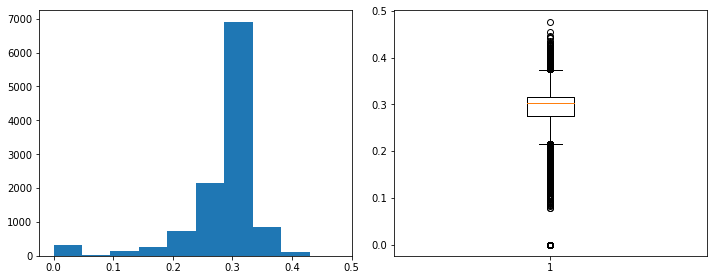


favorite_count_entropy real users normal scale:


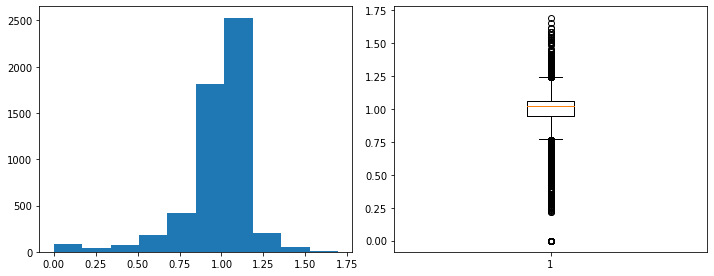


favorite_count_entropy real users log scale:


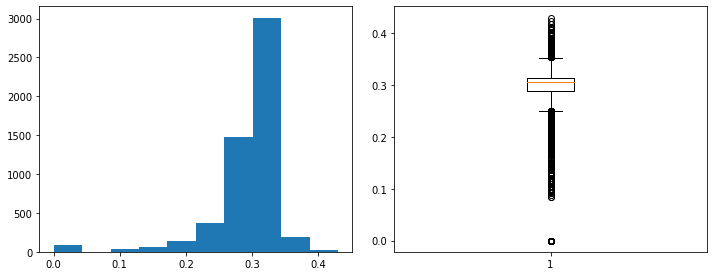


favorite_count_entropy bot users normal scale:


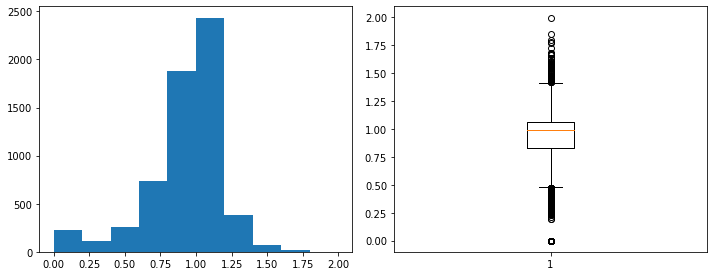


favorite_count_entropy bot users log scale:


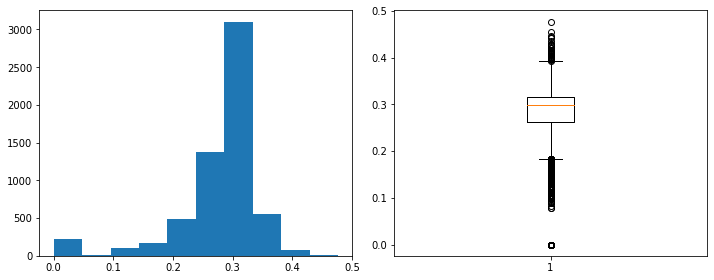

In [ ]:
visualize_distribution(col)



Real users theshold log scale 1.2428882503488234, 0.7684637473674132


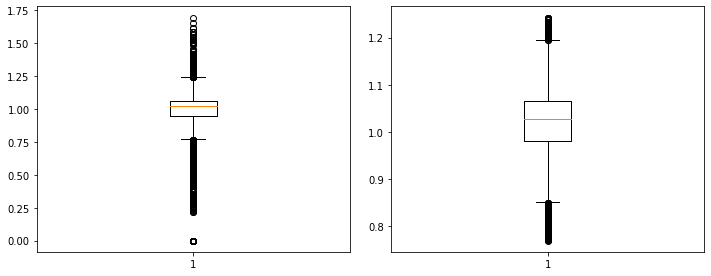



Real users theshold log scale 1.4171682947927378, 0.4766385258083396


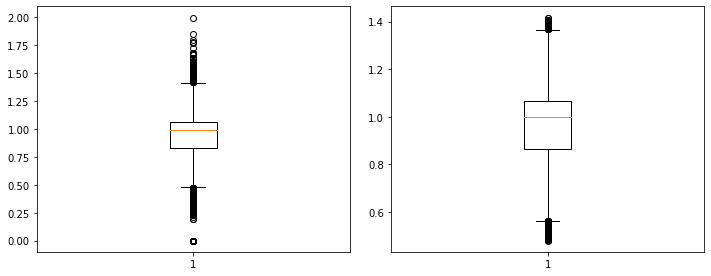

In [ ]:
reals, bots = fix_outliers_boxplot(col)

users.loc[reals.index.tolist(), col] = reals
users.loc[bots.index.tolist(), col] = bots

# Number of hashtags entropy

In [ ]:
col = "num_hashtags_entropy"
get_stats(col)

Mean: 0.564069391428565
Median: 0.6025565430646296
Mode: [-0.0]
Standard deviation: 0.18684247868234152
Median absolute deviation: 0.057921423683296336
1st quantile: 0.5153064165252602
3rd quantile: 0.6468980582372222
Minimum: -0.0
Maximum: 1.584962500721156



num_hashtags_entropy all users normal scale:


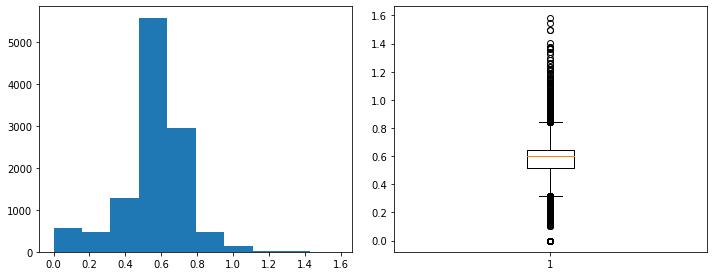


num_hashtags_entropy all users log scale:


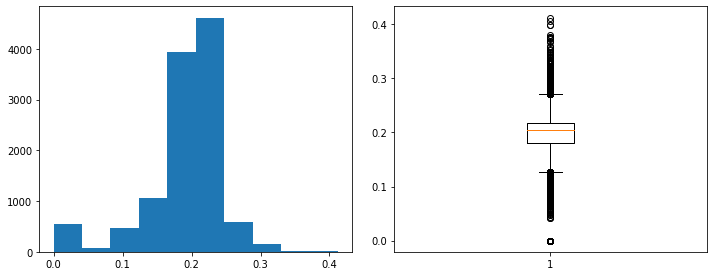


num_hashtags_entropy real users normal scale:


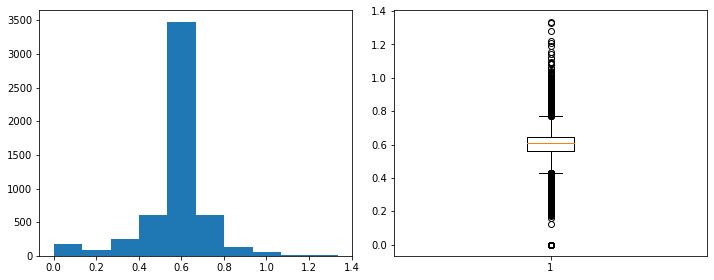


num_hashtags_entropy real users log scale:


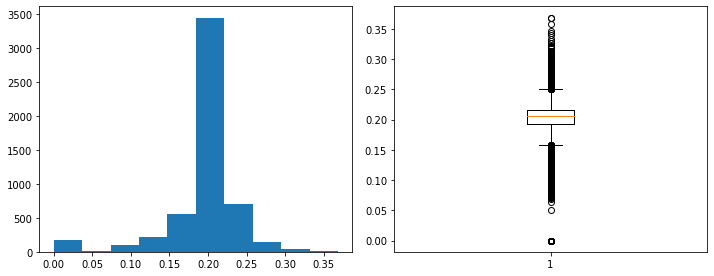


num_hashtags_entropy bot users normal scale:


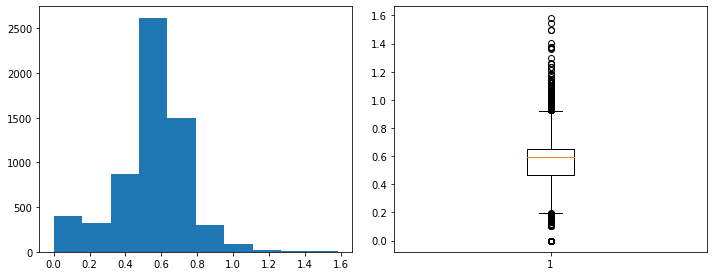


num_hashtags_entropy bot users log scale:


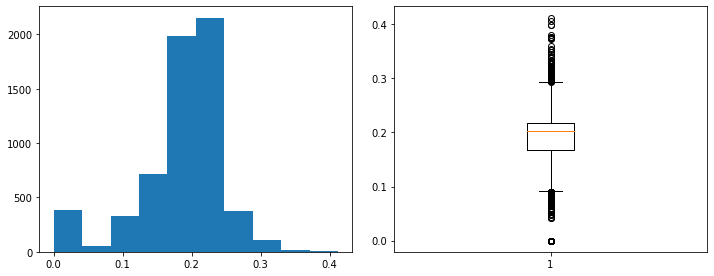

In [ ]:
visualize_distribution(col)



Real users theshold log scale 0.7727645035588061, 0.4297156775182204


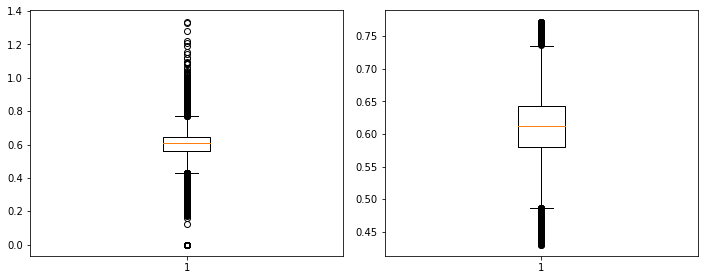



Real users theshold log scale 0.9246715411044615, 0.19559002508017304


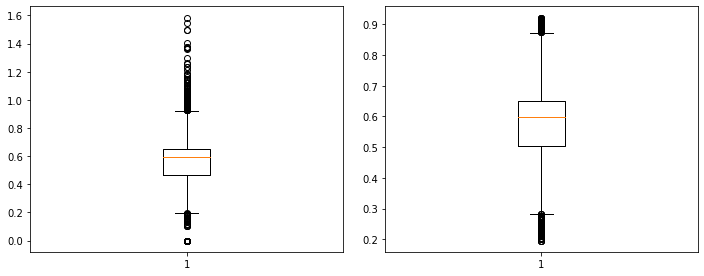

In [ ]:
reals, bots = fix_outliers_boxplot(col)

users.loc[reals.index.tolist(), col] = reals
users.loc[bots.index.tolist(), col] = bots

# Number of URLs entropy

In [ ]:
col = "num_urls_entropy"
get_stats(col)

Mean: 0.5837004817073217
Median: 0.6082677428181038
Mode: [-0.0]
Standard deviation: 0.14865166756083154
Median absolute deviation: 0.038342510991386525
1st quantile: 0.561028486340068
3rd quantile: 0.6409441847875287
Minimum: -0.0
Maximum: 1.198117421130403



num_urls_entropy all users normal scale:


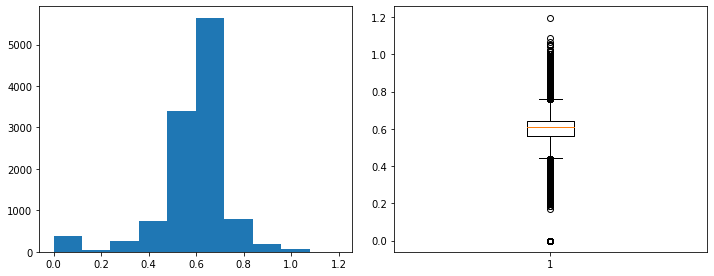


num_urls_entropy all users log scale:


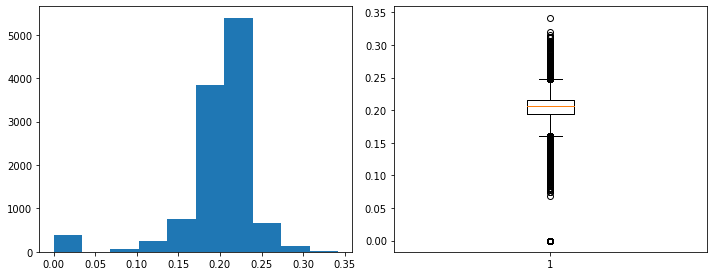


num_urls_entropy real users normal scale:


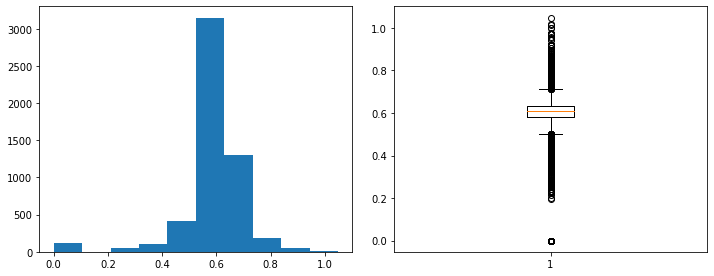


num_urls_entropy real users log scale:


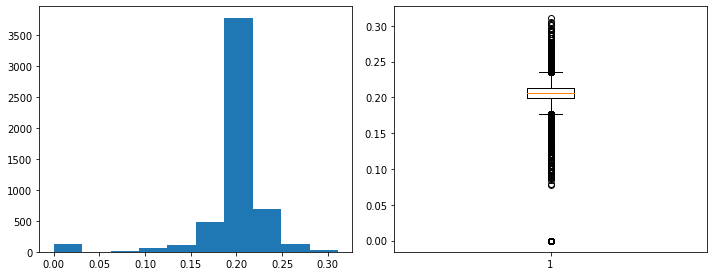


num_urls_entropy bot users normal scale:


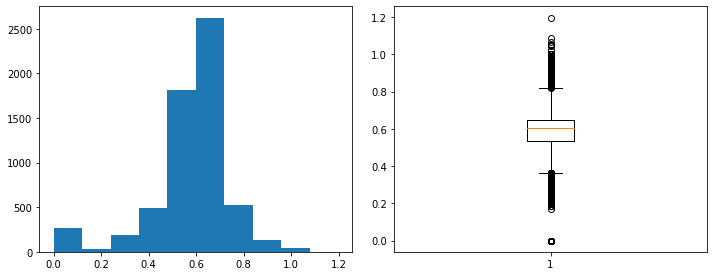


num_urls_entropy bot users log scale:


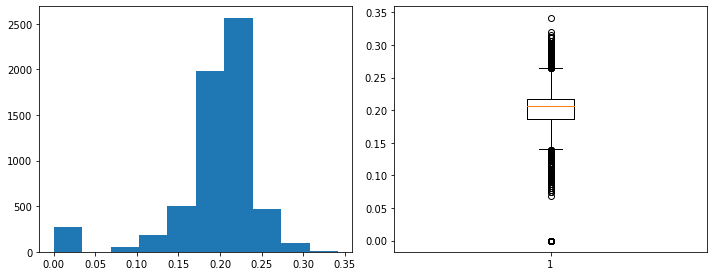

In [ ]:
visualize_distribution(col)



Real users theshold log scale 0.7144742901039132, 0.5004730972368232


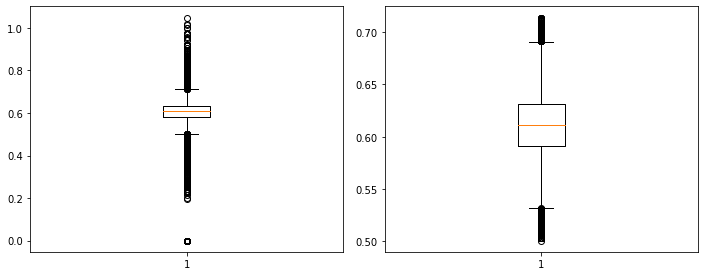



Real users theshold log scale 0.8215740120722435, 0.3641031042752052


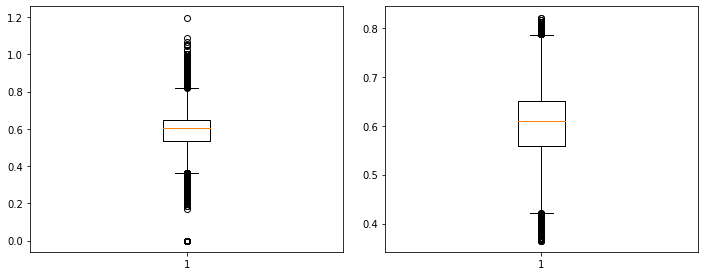

In [ ]:
reals, bots = fix_outliers_boxplot(col)

users.loc[reals.index.tolist(), col] = reals
users.loc[bots.index.tolist(), col] = bots

# Number of mentions entropy

In [ ]:
col = "num_mentions_entropy"
get_stats(col)

Mean: 1.250721939888336
Median: 1.3058090453650126
Mode: [-0.0]
Standard deviation: 0.2202563683526123
Median absolute deviation: 0.05136130693609775
1st quantile: 1.2179741025033863
3rd quantile: 1.342277035077732
Minimum: -0.0
Maximum: 2.019240704636849



num_mentions_entropy all users normal scale:


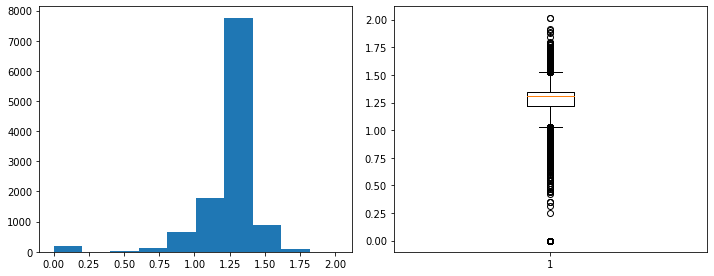


num_mentions_entropy all users log scale:


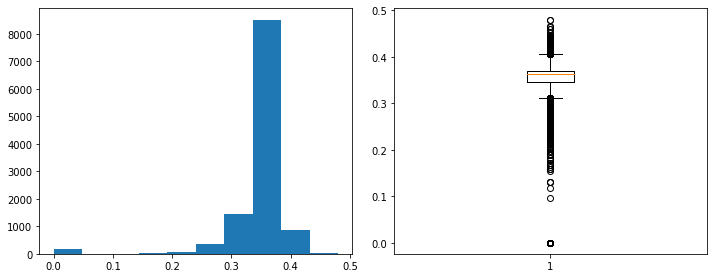


num_mentions_entropy real users normal scale:


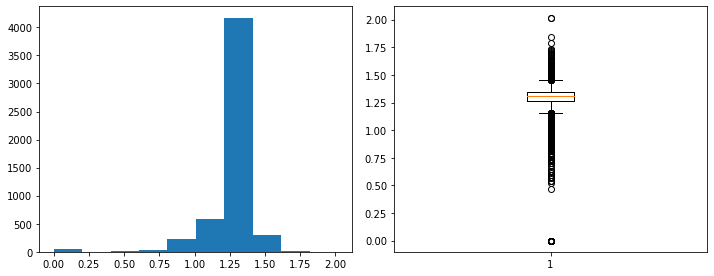


num_mentions_entropy real users log scale:


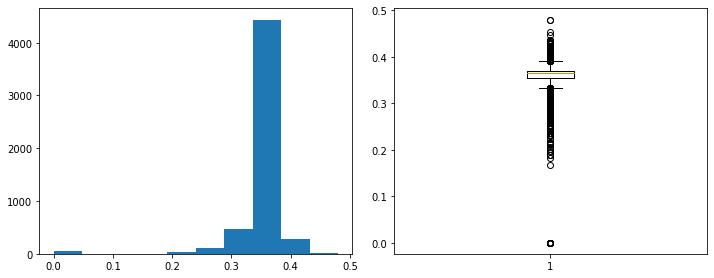


num_mentions_entropy bot users normal scale:


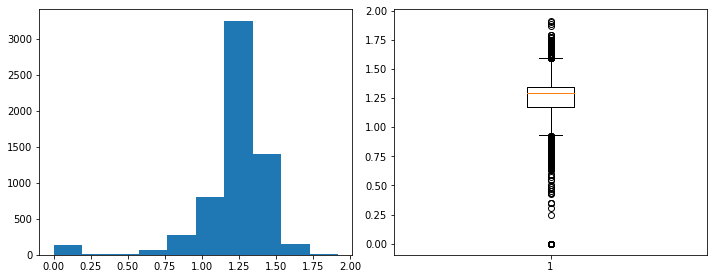


num_mentions_entropy bot users log scale:


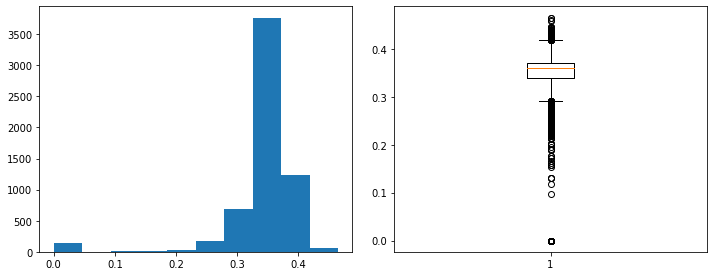

In [ ]:
visualize_distribution(col)



Real users theshold log scale 1.4547787013874733, 1.1517676477251848


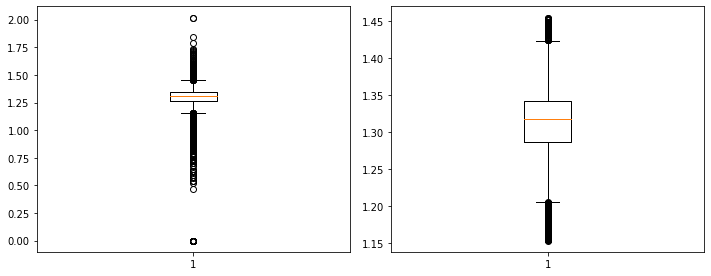



Real users theshold log scale 1.592966653092416, 0.9303487425755248


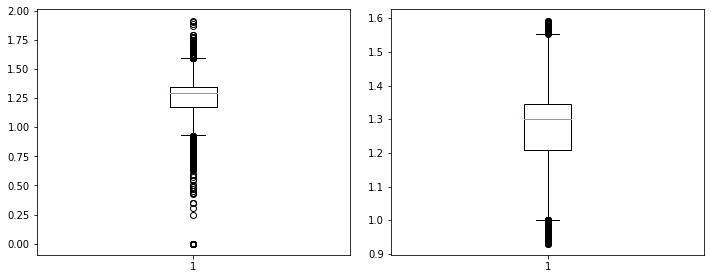

In [ ]:
reals, bots = fix_outliers_boxplot(col)
# reals, bots = fix_outliers_sigma(col, 2, 2)


users.loc[reals.index.tolist(), col] = reals
users.loc[bots.index.tolist(), col] = bots

# Retweet count per day

In [ ]:
col = "retweet_count_per_day"
get_stats(col)

Mean: 566.0219733072865
Median: 114.9894422981416
Mode: [0.0]
Standard deviation: 1861.1971661086823
Median absolute deviation: 114.75718371977912
1st quantile: 12.66873929106875
3rd quantile: 634.4896187882914
Minimum: 0.0
Maximum: 102721.88235294116



retweet_count_per_day all users normal scale:


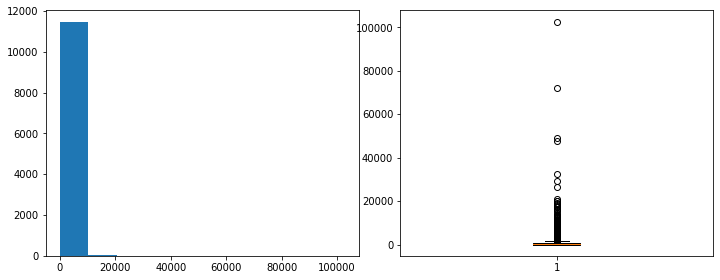


retweet_count_per_day all users log scale:


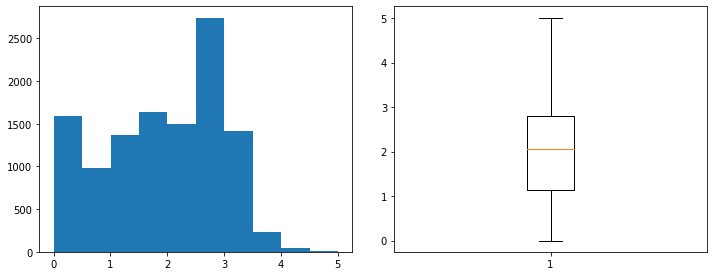


retweet_count_per_day real users normal scale:


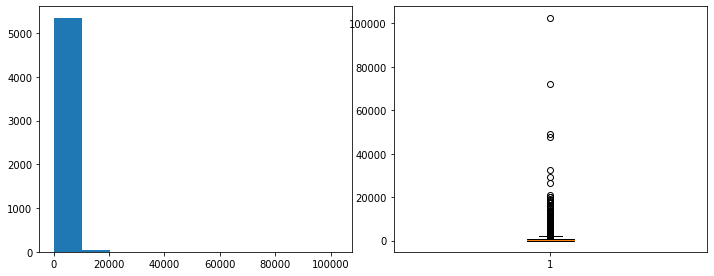


retweet_count_per_day real users log scale:


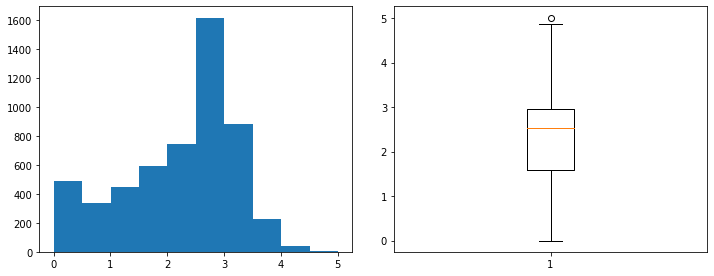


retweet_count_per_day bot users normal scale:


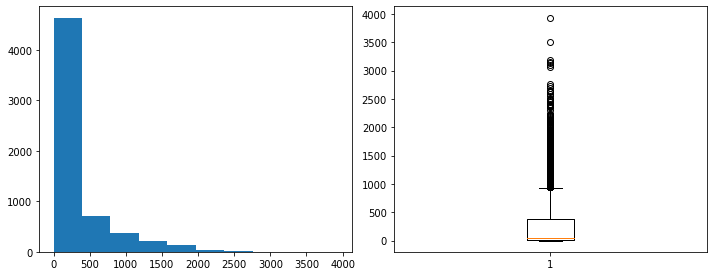


retweet_count_per_day bot users log scale:


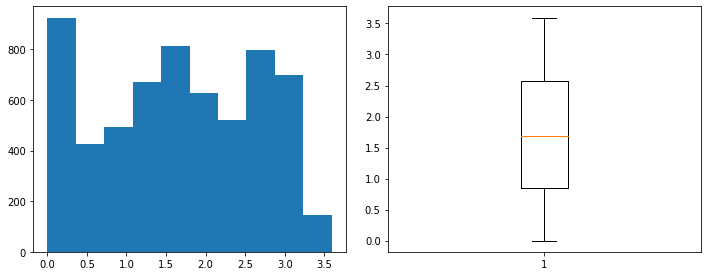

In [ ]:
visualize_distribution(col)

# Reply count per day

In [ ]:
col = "reply_count_per_day"
get_stats(col)

Mean: 0.01974830059754923
Median: 0.0
Mode: [0.0]
Standard deviation: 0.19092552756869227
Median absolute deviation: 0.0
1st quantile: 0.0
3rd quantile: 0.0026548672566371
Minimum: 0.0
Maximum: 12.951219512195122



reply_count_per_day all users normal scale:


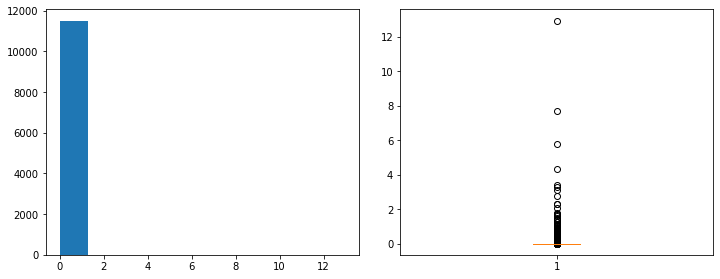


reply_count_per_day all users log scale:


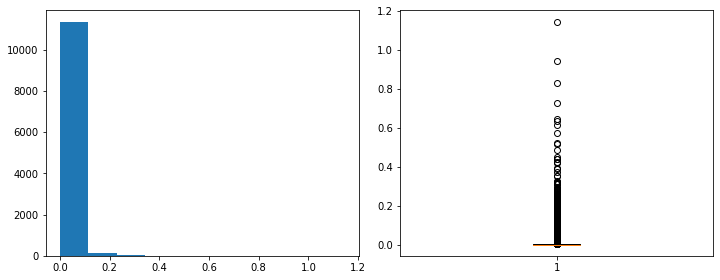


reply_count_per_day real users normal scale:


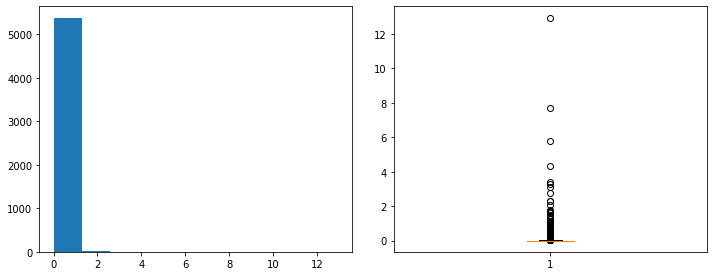


reply_count_per_day real users log scale:


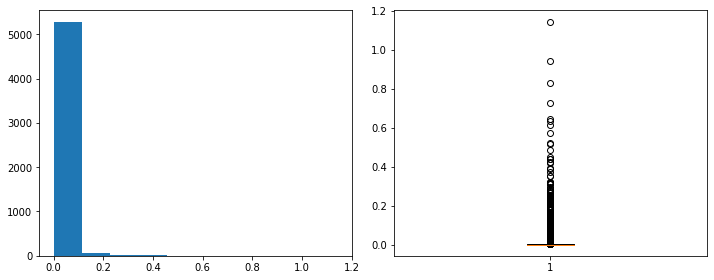


reply_count_per_day bot users normal scale:


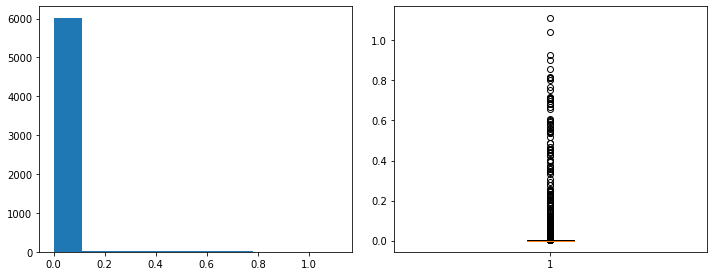


reply_count_per_day bot users log scale:


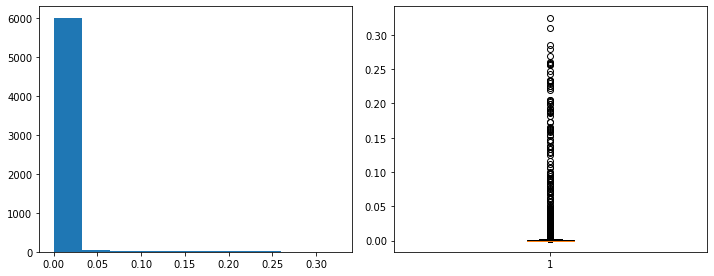

In [ ]:
visualize_distribution(col)



Real users theshold 0.971963247488055, 0


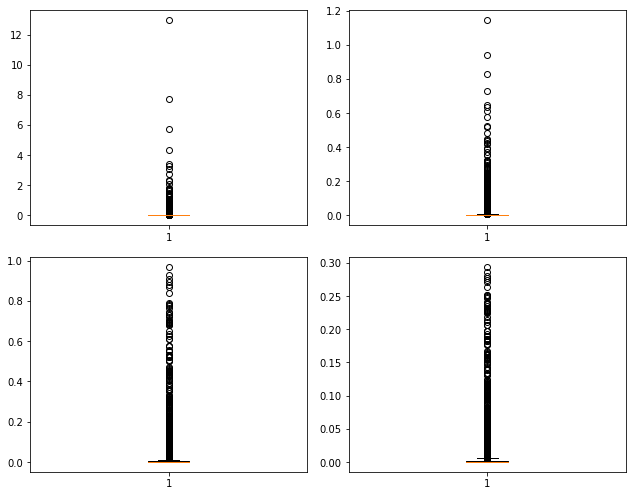


Bot users theshold 0.5506078926882044, 0


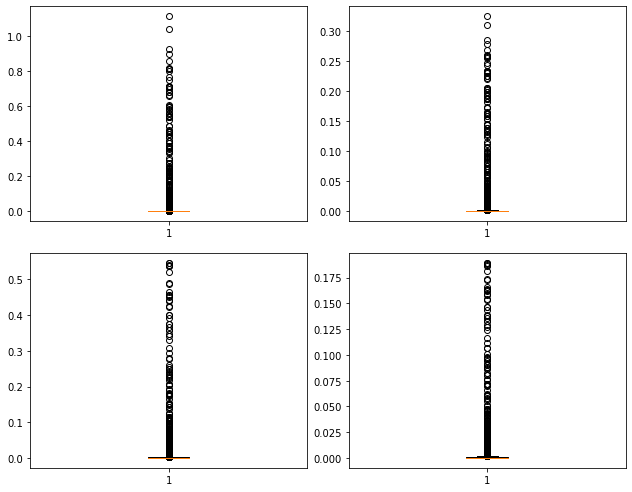

In [ ]:
# reals, bots = fix_outliers_log(col, upp_real=0.98, low_real = -1, upp_bot=0.995, low_bot=-1)
reals, bots = fix_outliers_log(col, upp_real=0.995, low_real = -1, upp_bot=0.995, low_bot=-1)

users.loc[reals.index.tolist(), col] = reals
users.loc[bots.index.tolist(), col] = bots

# Favorite count per day

In [ ]:
col = "favorite_count_per_day"
get_stats(col)

Mean: 1.2751907528348418
Median: 0.1338432122370937
Mode: [0.0]
Standard deviation: 6.6869319573678245
Median absolute deviation: 0.1288927171875888
1st quantile: 0.030697723898163824
3rd quantile: 0.8322514972564823
Minimum: 0.0
Maximum: 359.6923076923077



favorite_count_per_day all users normal scale:


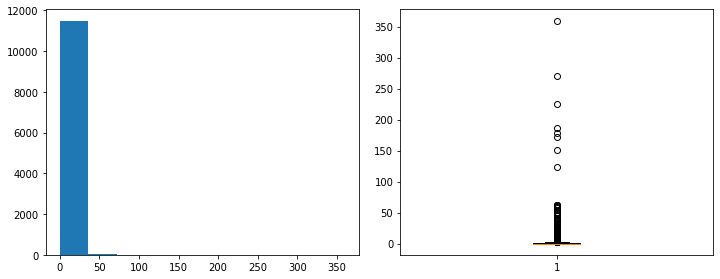


favorite_count_per_day all users log scale:


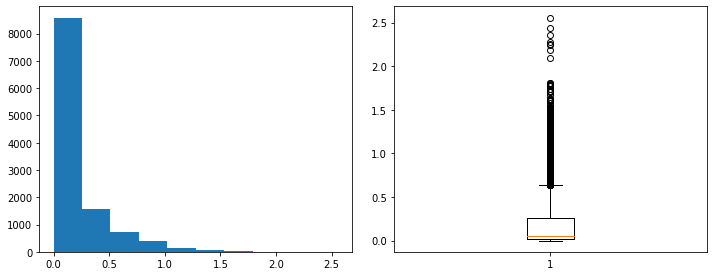


favorite_count_per_day real users normal scale:


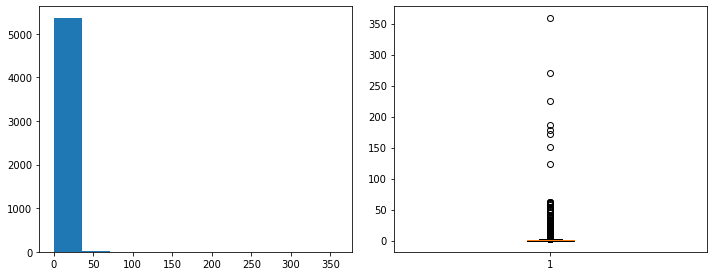


favorite_count_per_day real users log scale:


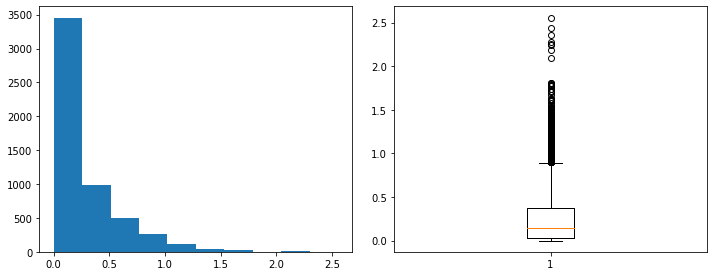


favorite_count_per_day bot users normal scale:


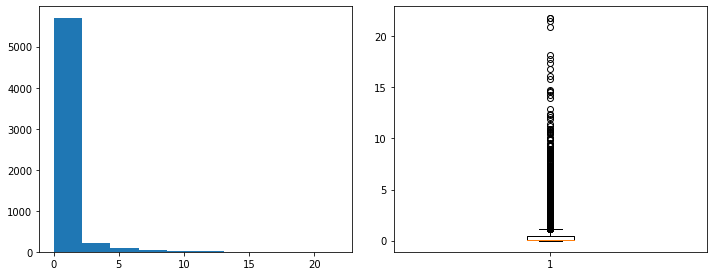


favorite_count_per_day bot users log scale:


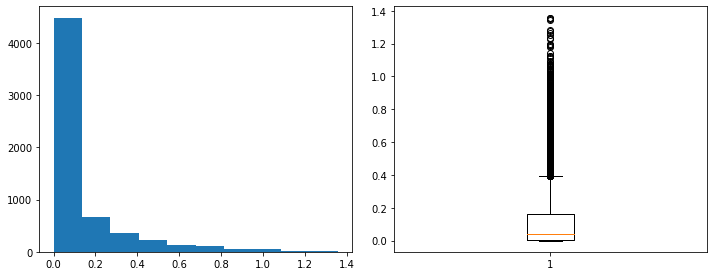

In [ ]:
visualize_distribution(col)



Real users theshold 106.89754722985097, 0


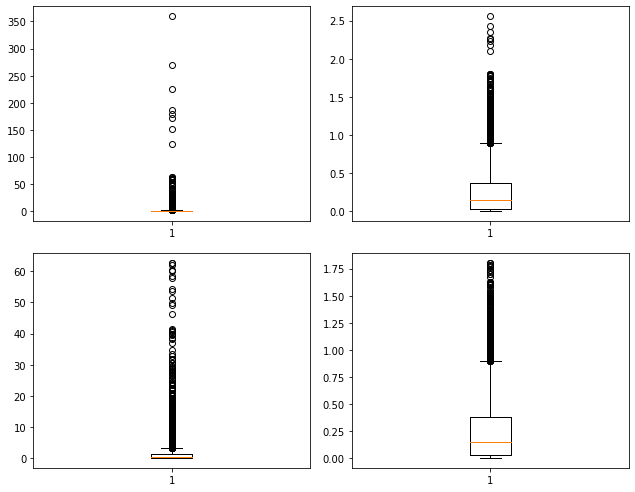


Bot users theshold 11.105038474672497, 0


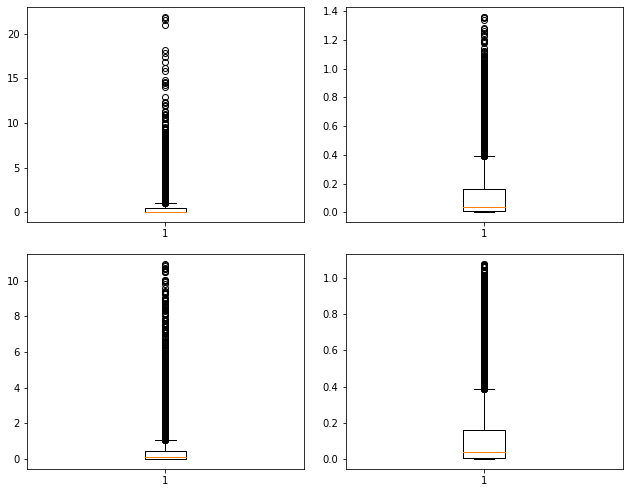

In [ ]:
reals, bots = fix_outliers_log(col, upp_real=0.99865, low_real=-1, upp_bot=0.9965, low_bot=-1)
# reals, bots = fix_outliers_boxplot_log(col)

users.loc[reals.index.tolist(), col] = reals
users.loc[bots.index.tolist(), col] = bots

# Number of hashtags per day

In [ ]:
col = "num_hashtags_per_day"
get_stats(col)

Mean: 0.1866932035861058
Median: 0.0462962962962962
Mode: [0.0]
Standard deviation: 0.5547769887649613
Median absolute deviation: 0.043817981550323494
1st quantile: 0.010493442090143676
3rd quantile: 0.20296942022969416
Minimum: 0.0
Maximum: 28.294117647058822



num_hashtags_per_day all users normal scale:


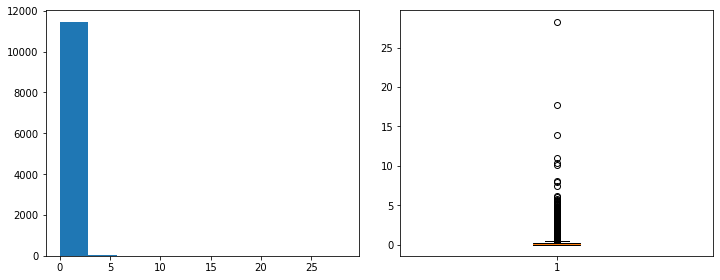


num_hashtags_per_day all users log scale:


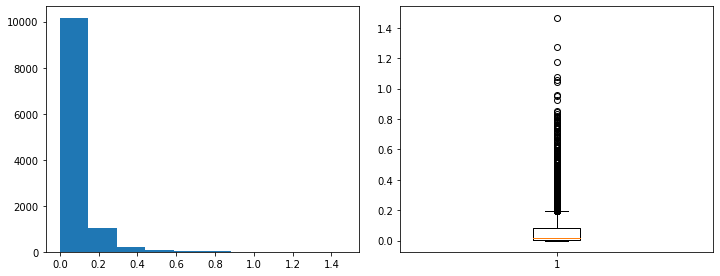


num_hashtags_per_day real users normal scale:


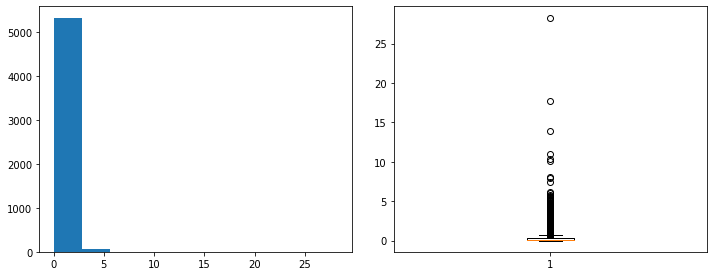


num_hashtags_per_day real users log scale:


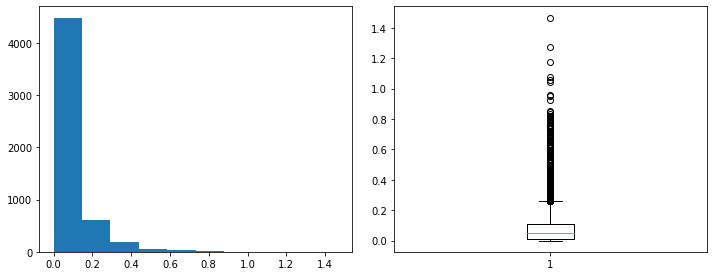


num_hashtags_per_day bot users normal scale:


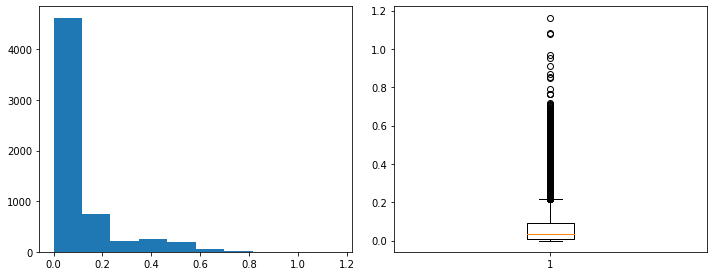


num_hashtags_per_day bot users log scale:


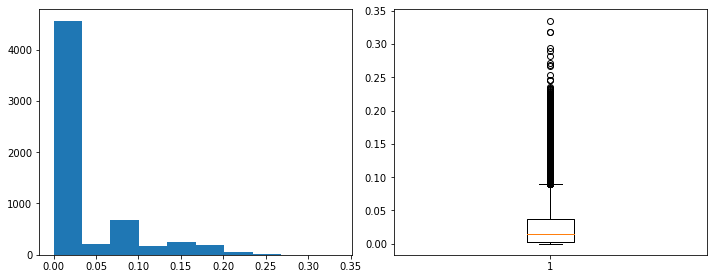

In [ ]:
visualize_distribution(col)



Real users theshold 5.507969252873563, 0


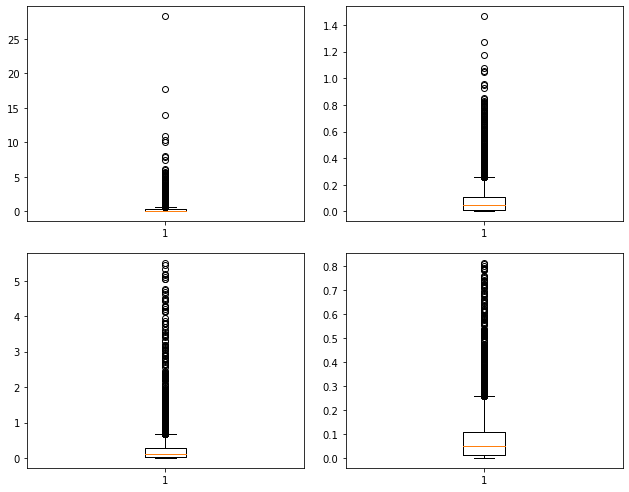


Bot users theshold 0.7090633074430114, 0


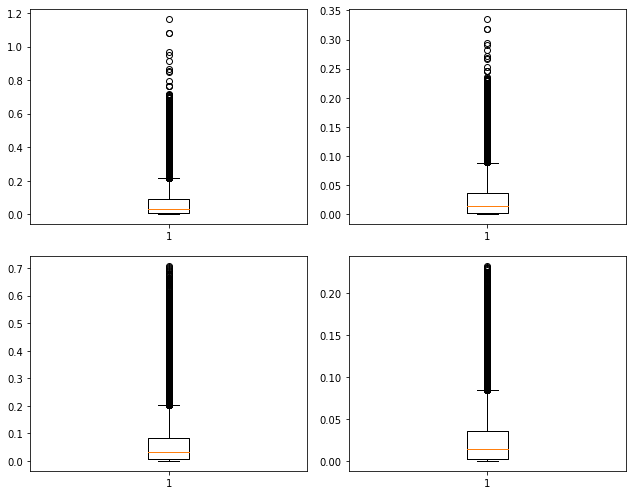

In [ ]:
reals, bots = fix_outliers_log(col, upp_real=0.9975, low_real=-1, upp_bot=0.9975, low_bot=-1)
# reals, bots = fix_outliers_boxplot_log(col)

users.loc[reals.index.tolist(), col] = reals
users.loc[bots.index.tolist(), col] = bots

# Number of URLs per day

In [ ]:
col = "num_urls_per_day"
get_stats(col)

Mean: 0.1744240721043212
Median: 0.041860465116279
Mode: [0.0]
Standard deviation: 0.5234652735529958
Median absolute deviation: 0.0389786207358756
1st quantile: 0.0086633663366336
3rd quantile: 0.18636810184442865
Minimum: 0.0
Maximum: 28.058823529411764



num_urls_per_day all users normal scale:


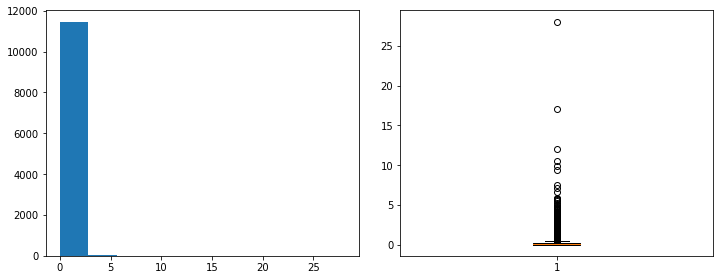


num_urls_per_day all users log scale:


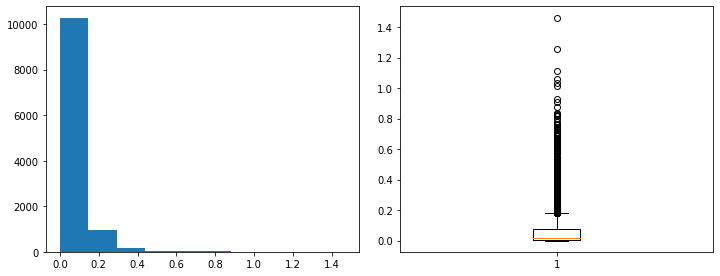


num_urls_per_day real users normal scale:


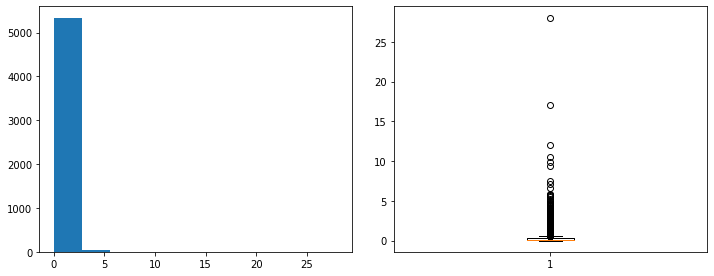


num_urls_per_day real users log scale:


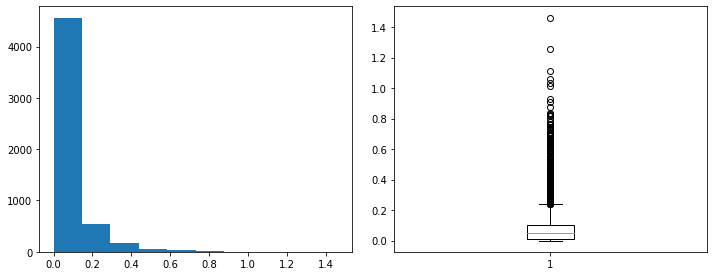


num_urls_per_day bot users normal scale:


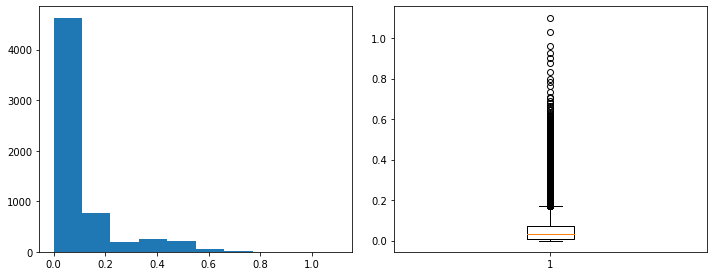


num_urls_per_day bot users log scale:


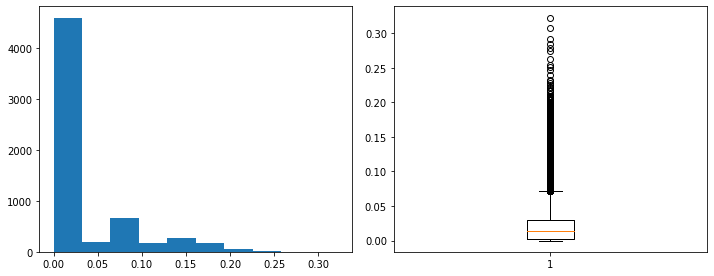

In [ ]:
visualize_distribution(col)



Real users theshold 5.409901270604404, 0


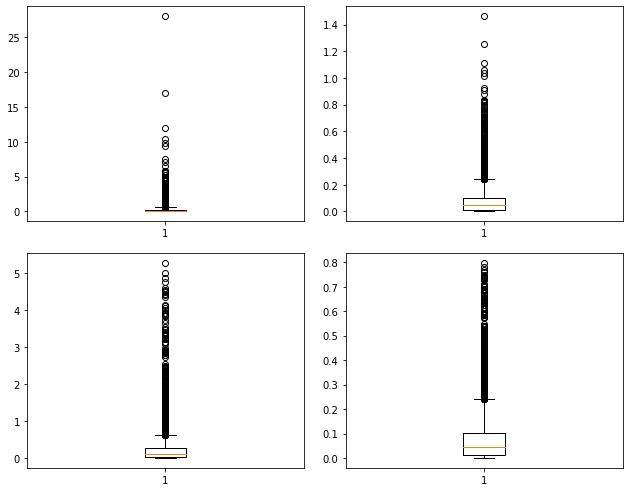


Bot users theshold 0.6655374986988662, 0


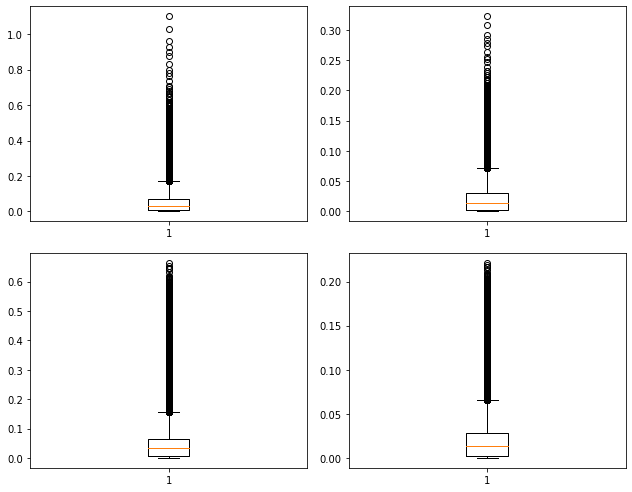

In [ ]:
reals, bots = fix_outliers_log(col, upp_real=0.9975, low_real=-1, upp_bot=0.9975, low_bot=-1)
# reals, bots = fix_outliers_boxplot_log(col)

users.loc[reals.index.tolist(), col] = reals
users.loc[bots.index.tolist(), col] = bots

# Number of mentions per day

In [ ]:
col = "num_mentions_per_day"
get_stats(col)

Mean: 0.577200164215908
Median: 0.13874215228033293
Mode: [0.0]
Standard deviation: 1.7355974306790354
Median absolute deviation: 0.12760353841894684
1st quantile: 0.028811529590070002
3rd quantile: 0.615
Minimum: 0.0
Maximum: 94.58823529411764



num_mentions_per_day all users normal scale:


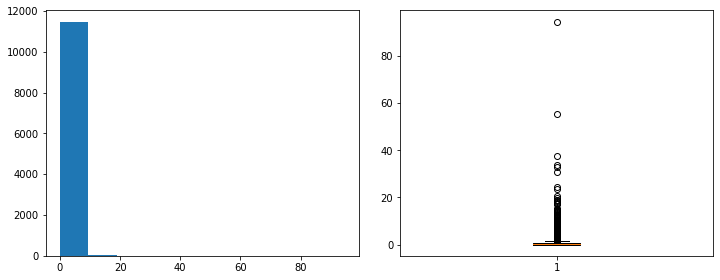


num_mentions_per_day all users log scale:


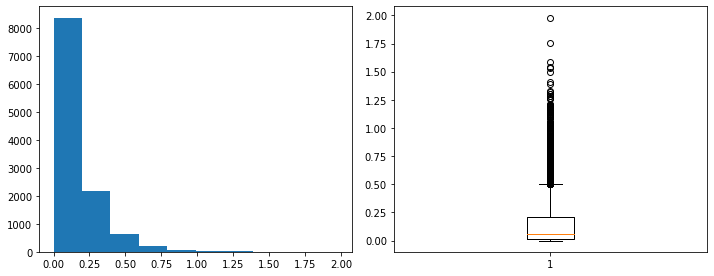


num_mentions_per_day real users normal scale:


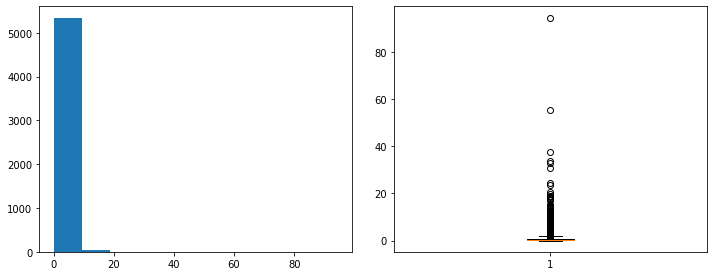


num_mentions_per_day real users log scale:


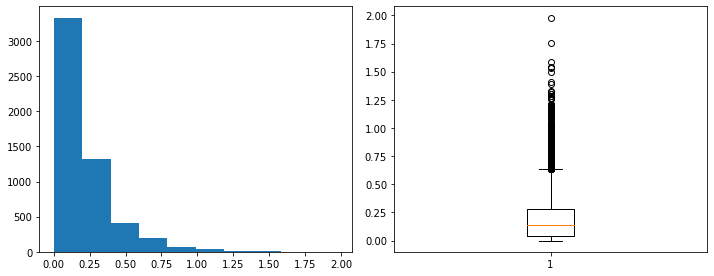


num_mentions_per_day bot users normal scale:


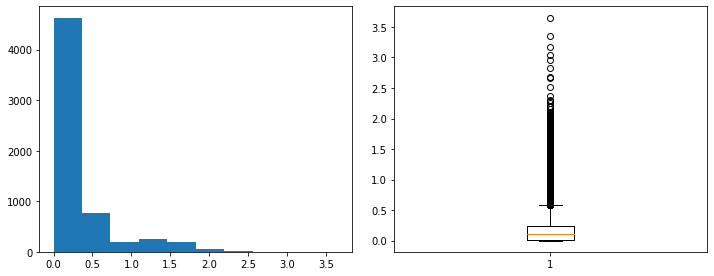


num_mentions_per_day bot users log scale:


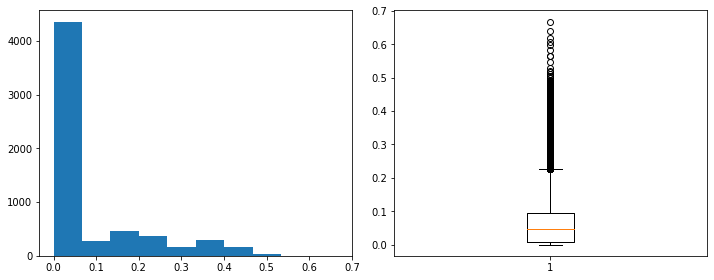

In [ ]:
visualize_distribution(col)



Real users theshold 15.077110505365185, 0


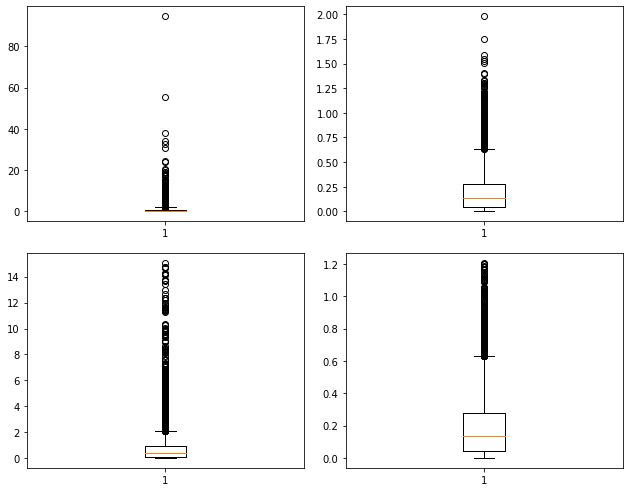


Bot users theshold 2.140219746194975, 0


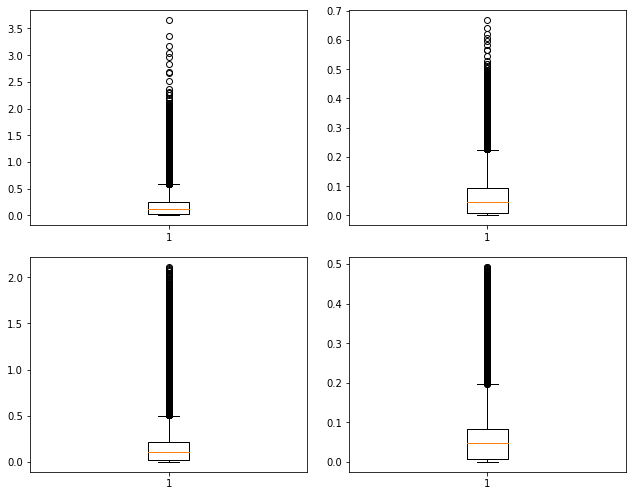

In [ ]:
reals, bots = fix_outliers_log(col, upp_real=0.9965, low_real=-1, upp_bot=0.9975, low_bot=-1)
# reals, bots = fix_outliers_boxplot_log(col)

users.loc[reals.index.tolist(), col] = reals
users.loc[bots.index.tolist(), col] = bots

# Average text length

In [ ]:
col = "avg_len"
get_stats(col)

Mean: 67.60922611531797
Median: 64.9786200894143
Mode: [64.0]
Standard deviation: 16.089357557998493
Median absolute deviation: 7.407264838424922
1st quantile: 59.035273861045184
3rd quantile: 76.70449781360112
Minimum: 3.0
Maximum: 245.0



avg_len all users normal scale:


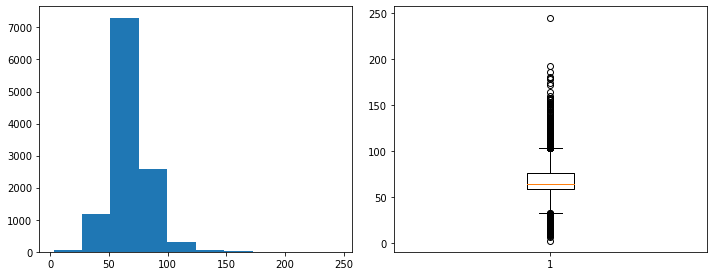


avg_len all users log scale:


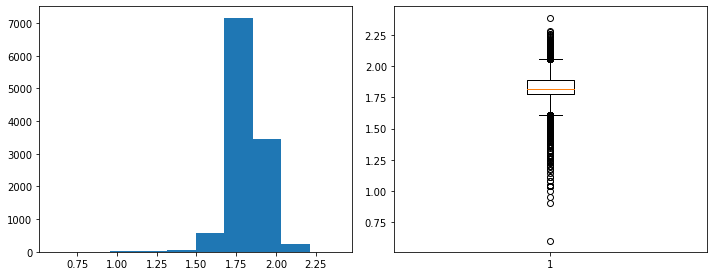


avg_len real users normal scale:


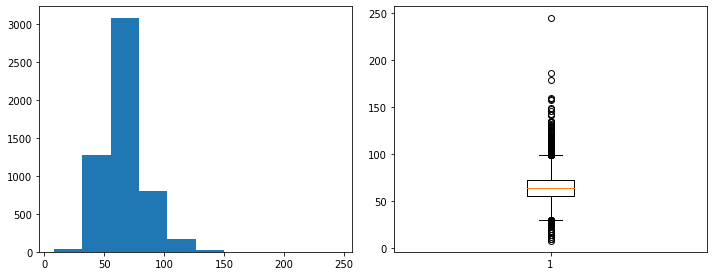


avg_len real users log scale:


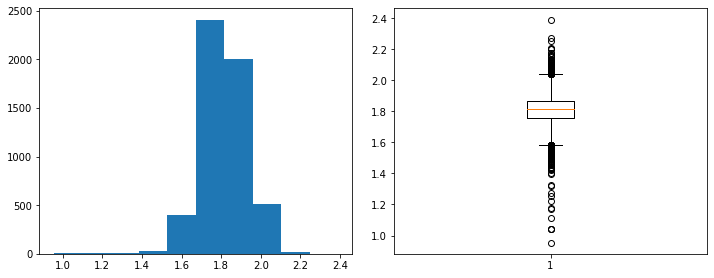


avg_len bot users normal scale:


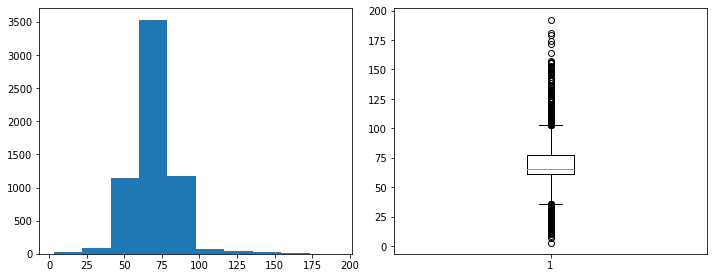


avg_len bot users log scale:


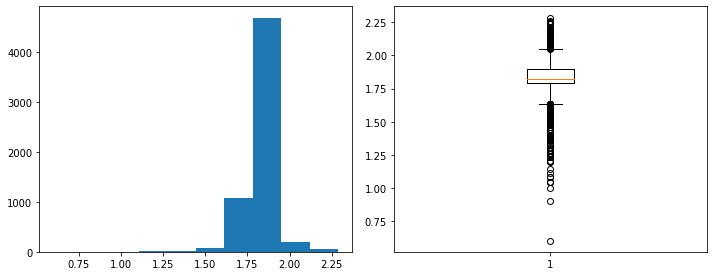

In [ ]:
visualize_distribution(col)



Real users theshold log scale 98.57892745927916, 30.195650268279906


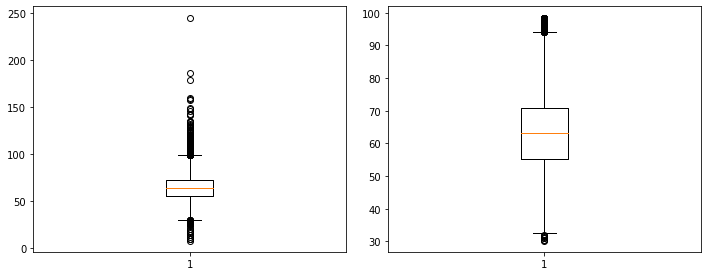



Real users theshold log scale 102.81539397179976, 35.82422515538168


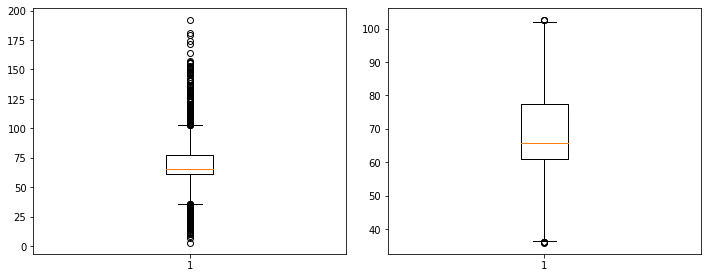

In [ ]:
# reals, bots = fix_outliers(col, upp_real=0.99, low_real=0.01, upp_bot=0.995, low_bot=0.01)
reals, bots = fix_outliers_boxplot(col)
# reals, bots = fix_outliers_sigma(col, 3, 3)

users.loc[reals.index.tolist(), col] = reals
users.loc[bots.index.tolist(), col] = bots

# Average number of special characters in text

In [ ]:
col = "avg_spc_len"
get_stats(col)

Mean: 7.0706450273568375
Median: 4.598510696812026
Mode: [4.0]
Standard deviation: 11.500584395305609
Median absolute deviation: 1.028892927406171
1st quantile: 3.6875
3rd quantile: 6.286308084297806
Minimum: 0.0
Maximum: 215.0



avg_spc_len all users normal scale:


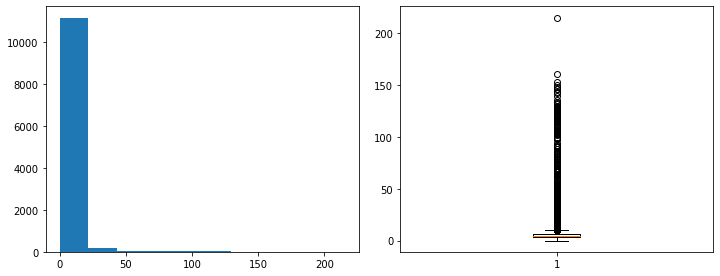


avg_spc_len all users log scale:


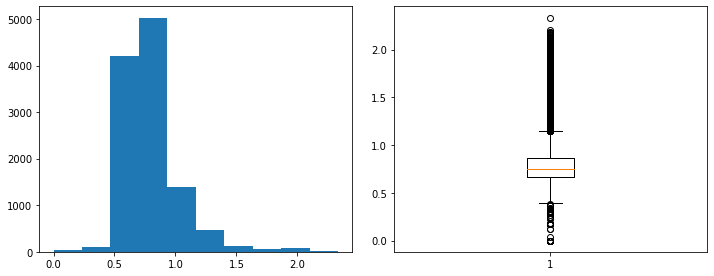


avg_spc_len real users normal scale:


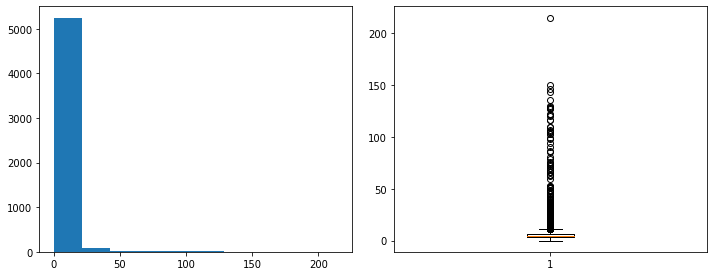


avg_spc_len real users log scale:


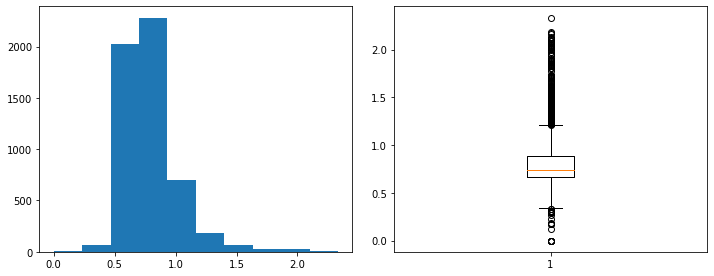


avg_spc_len bot users normal scale:


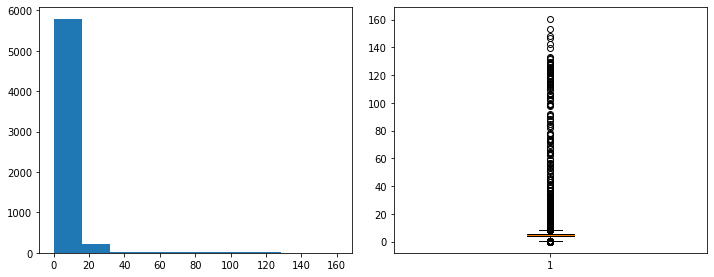


avg_spc_len bot users log scale:


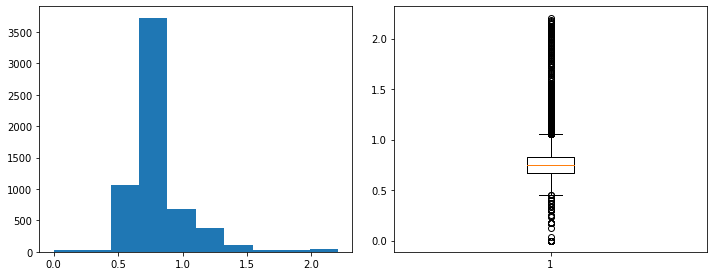

In [ ]:
visualize_distribution(col)



Real users theshold log scale 1.2130531966231626, 0.33599923831045203
Real users theshold normal scale 15.33251992273048, 1.1677003029843487


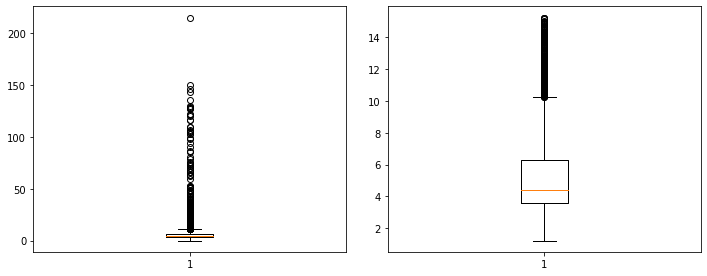

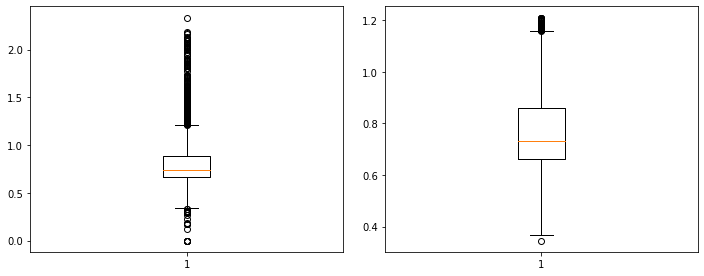



Bot users theshold log scale 1.0535985072719476, 0.44721794919935
Bot users theshold normal scale 10.313539754983877, 1.8003863313506496


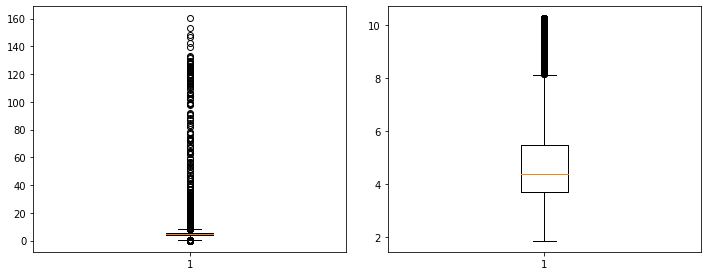

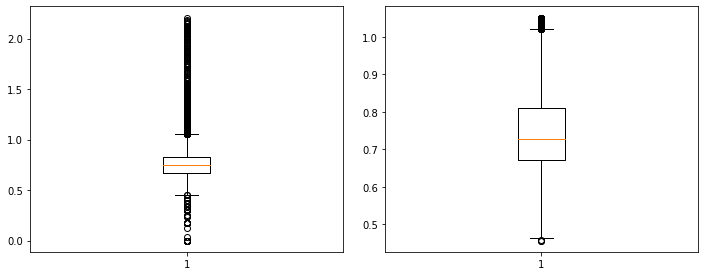

In [ ]:
# reals, bots = fix_outliers_log(col, upp_real=0.999, low_real=0.02, upp_bot=-1, low_bot=0.02)
reals, bots = fix_outliers_boxplot_log(col)
# reals, bots = fix_outliers_log_sigma(col, 2, 2)

users.loc[reals.index.tolist(), col] = reals
users.loc[bots.index.tolist(), col] = bots

# Engagement sum

In [ ]:
# col = "engagement_sum"
# get_stats(col)

In [ ]:
# visualize_distribution(col)

In [ ]:
# 1 reals, bots = fix_outliers_log(col, upp_real=-1, low_real = 0.01, upp_bot=-1, low_bot=0.025)
# 1 users.loc[reals.index.tolist(), col] = reals
# 1 users.loc[bots.index.tolist(), col] = bots

# Engagement average

In [ ]:
# col = "engagement_avg"
# get_stats(col)

In [ ]:
# visualize_distribution(col)

In [ ]:
# 1 reals, bots = fix_outliers_log(col, upp_real=0.999, low_real = -1, upp_bot=0.9995, low_bot=-1)
# 1 users.loc[reals.index.tolist(), col] = reals
# 1 users.loc[bots.index.tolist(), col] = bots

# Engagement standard deviation

In [ ]:
# col = "engagement_std"
# get_stats(col)

In [ ]:
# visualize_distribution(col)

# Engagement per day

In [ ]:
# col = "engagement_per_day"
# get_stats(col)

In [ ]:
# visualize_distribution(col)

# Days of activity

In [ ]:
# col = "days"
# get_stats(col)

In [ ]:
# visualize_distribution(col)

In [ ]:
# # reals, bots = fix_outliers(col, upp_real=-1, low_real=-1, upp_bot=0.9925, low_bot=-1)
# reals, bots = fix_outliers_boxplot(col)
# # users.loc[reals.index.tolist(), col] = reals
# # users.loc[bots.index.tolist(), col] = bots

# Correlation matrix #

In [ ]:
selected_cols = users.columns[5:]
corr = users[selected_cols].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

<ipython-input-173-589619e7aecf>:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,statuses_count,num_tweets,retweet_count_total,reply_count_total,favorite_count_total,num_hashtags_total,num_urls_total,num_mentions_total,retweet_count_avg,reply_count_avg,favorite_count_avg,num_hashtags_avg,num_urls_avg,num_mentions_avg,retweet_count_std,reply_count_std,favorite_count_std,num_hashtags_std,num_urls_std,num_mentions_std,retweet_count_entropy,reply_count_entropy,favorite_count_entropy,num_hashtags_entropy,num_urls_entropy,num_mentions_entropy,tweets_per_day,retweet_count_per_day,reply_count_per_day,favorite_count_per_day,num_hashtags_per_day,num_urls_per_day,num_mentions_per_day,avg_len,avg_spc_len
statuses_count,1.00,0.45,0.42,0.31,0.28,0.45,0.45,0.45,0.01,0.07,0.07,-0.04,-0.03,0.01,0.10,0.02,0.19,0.08,0.02,0.09,0.26,0.08,0.10,0.07,0.02,0.08,0.13,0.12,0.10,0.13,0.19,0.19,0.20,-0.06,0.05
num_tweets,0.45,1.00,0.93,0.40,0.63,1.00,1.00,1.00,0.03,0.18,0.18,-0.10,-0.07,0.05,0.26,0.06,0.31,0.21,0.06,0.24,0.66,0.21,0.24,0.17,0.06,0.20,0.42,0.38,0.25,0.41,0.56,0.56,0.57,0.17,0.06
retweet_count_total,0.42,0.93,1.00,0.37,0.59,0.93,0.93,0.93,0.14,0.16,0.17,-0.09,-0.06,0.06,0.40,0.06,0.29,0.20,0.06,0.23,0.63,0.19,0.22,0.16,0.06,0.20,0.39,0.41,0.23,0.39,0.51,0.52,0.53,0.16,0.07
reply_count_total,0.31,0.40,0.37,1.00,0.27,0.40,0.39,0.40,0.02,0.09,0.10,-0.04,-0.03,0.02,0.11,0.01,0.26,0.09,0.02,0.10,0.27,0.20,0.11,0.08,0.02,0.09,0.20,0.19,0.17,0.23,0.27,0.27,0.27,-0.05,0.02
favorite_count_total,0.28,0.63,0.59,0.27,1.00,0.62,0.63,0.63,0.02,0.14,0.62,-0.06,-0.04,0.03,0.17,0.05,0.18,0.14,0.04,0.15,0.42,0.15,0.18,0.11,0.04,0.13,0.28,0.26,0.20,0.61,0.37,0.37,0.37,0.10,0.03
num_hashtags_total,0.45,1.00,0.93,0.40,0.62,1.00,0.99,1.00,0.03,0.18,0.18,-0.07,-0.07,0.06,0.26,0.06,0.32,0.24,0.06,0.24,0.66,0.21,0.24,0.20,0.07,0.21,0.41,0.38,0.25,0.41,0.56,0.56,0.57,0.17,0.06
num_urls_total,0.45,1.00,0.93,0.39,0.63,0.99,1.00,1.00,0.03,0.18,0.18,-0.10,-0.05,0.05,0.26,0.06,0.31,0.21,0.08,0.24,0.66,0.21,0.24,0.18,0.09,0.20,0.41,0.38,0.25,0.41,0.56,0.56,0.57,0.17,0.06
num_mentions_total,0.45,1.00,0.93,0.40,0.63,1.00,1.00,1.00,0.03,0.18,0.18,-0.10,-0.07,0.07,0.26,0.06,0.31,0.21,0.06,0.25,0.66,0.21,0.24,0.18,0.06,0.22,0.41,0.38,0.25,0.41,0.56,0.56,0.57,0.17,0.06
retweet_count_avg,0.01,0.03,0.14,0.02,0.02,0.03,0.03,0.03,1.00,0.01,0.01,-0.02,-0.03,0.04,0.69,-0.00,0.01,-0.00,-0.02,0.03,0.12,0.02,-0.01,-0.02,-0.02,0.03,0.01,0.07,0.01,0.02,0.02,0.01,0.02,0.01,-0.01
reply_count_avg,0.07,0.18,0.16,0.09,0.14,0.18,0.18,0.18,0.01,1.00,0.10,-0.02,-0.01,0.02,0.06,0.29,0.11,0.04,0.01,0.05,0.13,0.22,0.06,0.04,0.01,0.04,0.07,0.07,0.58,0.11,0.10,0.10,0.10,0.04,0.02


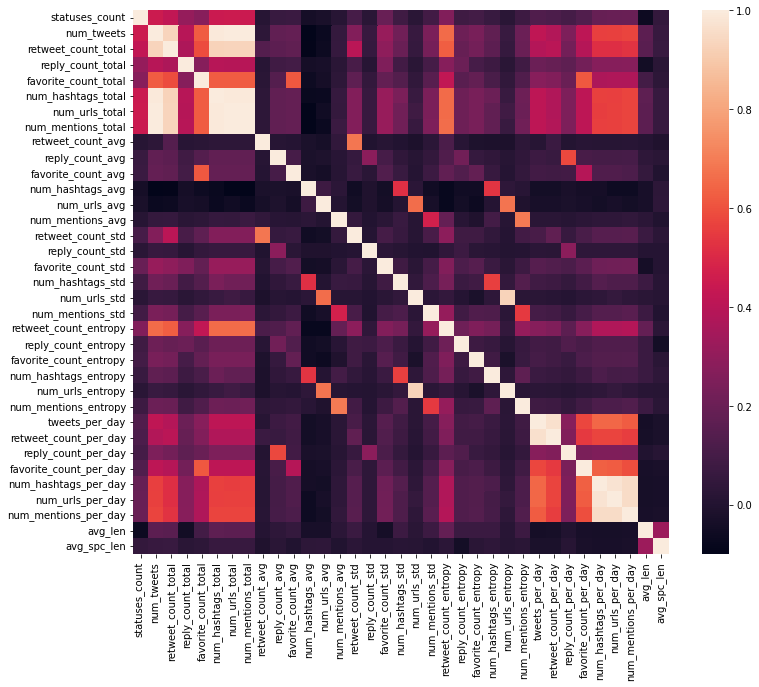

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, ax=ax)

In [ ]:
for col_1 in corr.columns:
  for col_2 in corr.index:
    if col_1 != col_2:
      c = corr.loc[col_2, col_1]
      if c > 0.8:
        print(f"{col_1} - {col_2}")

num_tweets - retweet_count_total
num_tweets - num_hashtags_total
num_tweets - num_urls_total
num_tweets - num_mentions_total
retweet_count_total - num_tweets
retweet_count_total - num_hashtags_total
retweet_count_total - num_urls_total
retweet_count_total - num_mentions_total
num_hashtags_total - num_tweets
num_hashtags_total - retweet_count_total
num_hashtags_total - num_urls_total
num_hashtags_total - num_mentions_total
num_urls_total - num_tweets
num_urls_total - retweet_count_total
num_urls_total - num_hashtags_total
num_urls_total - num_mentions_total
num_mentions_total - num_tweets
num_mentions_total - retweet_count_total
num_mentions_total - num_hashtags_total
num_mentions_total - num_urls_total
num_urls_std - num_urls_entropy
num_urls_entropy - num_urls_std
tweets_per_day - retweet_count_per_day
retweet_count_per_day - tweets_per_day
num_hashtags_per_day - num_urls_per_day
num_hashtags_per_day - num_mentions_per_day
num_urls_per_day - num_hashtags_per_day
num_urls_per_day - num

In [ ]:
columns = users.columns.tolist()


columns_to_drop = [
    'num_tweets',
    'num_mentions_total',
    'num_urls_total',
    'retweet_count_total',
    'num_urls_entropy',
    'num_urls_per_day',
    'num_mentions_per_day',
    'tweets_per_day'
]

selected_columns = [col for col in columns if col not in columns_to_drop]

 
corr = users[selected_columns[5:]].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

<ipython-input-176-650746ebb878>:19: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,statuses_count,reply_count_total,favorite_count_total,num_hashtags_total,retweet_count_avg,reply_count_avg,favorite_count_avg,num_hashtags_avg,num_urls_avg,num_mentions_avg,retweet_count_std,reply_count_std,favorite_count_std,num_hashtags_std,num_urls_std,num_mentions_std,retweet_count_entropy,reply_count_entropy,favorite_count_entropy,num_hashtags_entropy,num_mentions_entropy,retweet_count_per_day,reply_count_per_day,favorite_count_per_day,num_hashtags_per_day,avg_len,avg_spc_len
statuses_count,1.00,0.31,0.28,0.45,0.01,0.07,0.07,-0.04,-0.03,0.01,0.10,0.02,0.19,0.08,0.02,0.09,0.26,0.08,0.10,0.07,0.08,0.12,0.10,0.13,0.19,-0.06,0.05
reply_count_total,0.31,1.00,0.27,0.40,0.02,0.09,0.10,-0.04,-0.03,0.02,0.11,0.01,0.26,0.09,0.02,0.10,0.27,0.20,0.11,0.08,0.09,0.19,0.17,0.23,0.27,-0.05,0.02
favorite_count_total,0.28,0.27,1.00,0.62,0.02,0.14,0.62,-0.06,-0.04,0.03,0.17,0.05,0.18,0.14,0.04,0.15,0.42,0.15,0.18,0.11,0.13,0.26,0.20,0.61,0.37,0.10,0.03
num_hashtags_total,0.45,0.40,0.62,1.00,0.03,0.18,0.18,-0.07,-0.07,0.06,0.26,0.06,0.32,0.24,0.06,0.24,0.66,0.21,0.24,0.20,0.21,0.38,0.25,0.41,0.56,0.17,0.06
retweet_count_avg,0.01,0.02,0.02,0.03,1.00,0.01,0.01,-0.02,-0.03,0.04,0.69,-0.00,0.01,-0.00,-0.02,0.03,0.12,0.02,-0.01,-0.02,0.03,0.07,0.01,0.02,0.02,0.01,-0.01
reply_count_avg,0.07,0.09,0.14,0.18,0.01,1.00,0.10,-0.02,-0.01,0.02,0.06,0.29,0.11,0.04,0.01,0.05,0.13,0.22,0.06,0.04,0.04,0.07,0.58,0.11,0.10,0.04,0.02
favorite_count_avg,0.07,0.10,0.62,0.18,0.01,0.10,1.00,-0.03,-0.04,0.01,0.06,0.02,0.13,0.07,0.01,0.07,0.18,0.13,0.18,0.06,0.05,0.09,0.09,0.39,0.13,0.05,-0.00
num_hashtags_avg,-0.04,-0.04,-0.06,-0.07,-0.02,-0.02,-0.03,1.00,0.08,0.03,-0.05,-0.01,-0.04,0.52,0.03,-0.05,-0.08,-0.05,-0.05,0.54,0.02,-0.04,-0.02,-0.04,-0.04,-0.03,0.03
num_urls_avg,-0.03,-0.03,-0.04,-0.07,-0.03,-0.01,-0.04,0.08,1.00,0.00,-0.04,-0.01,-0.04,0.01,0.66,-0.03,-0.08,-0.04,-0.06,0.01,-0.01,-0.03,-0.02,-0.03,-0.04,-0.03,0.03
num_mentions_avg,0.01,0.02,0.03,0.06,0.04,0.02,0.01,0.03,0.00,1.00,0.05,0.00,0.02,0.07,0.01,0.47,0.18,0.02,-0.01,0.09,0.69,0.02,0.01,0.03,0.04,0.03,-0.00


# Remove correlated features

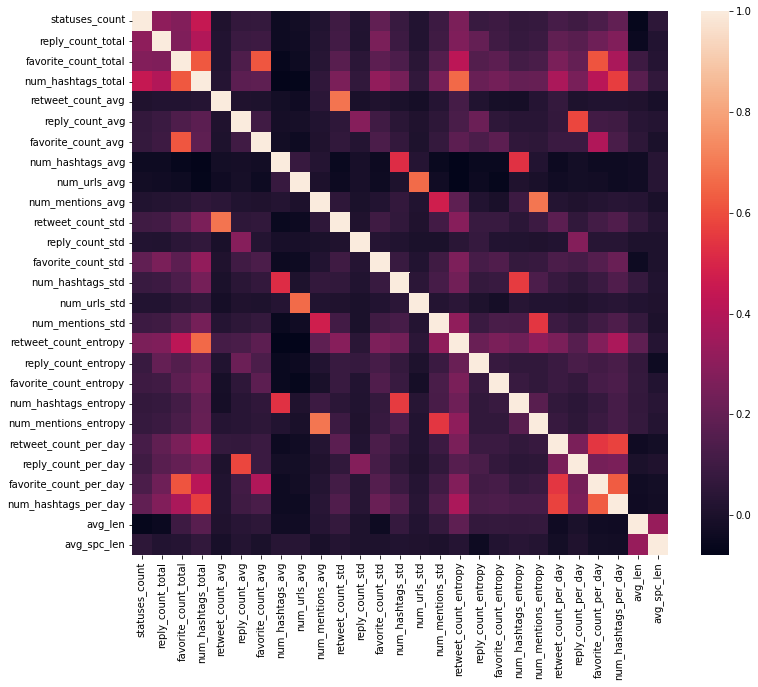

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, ax=ax)

# Prepare dataset with uncorrelated features # 

In [ ]:
clustering_users = users[selected_columns]

In [ ]:
%cd "/content/drive/Shareddrives/DM_Project"
users.to_csv("./dataset/users_extended_clean.csv", index=False)
clustering_users.to_csv("./dataset/users_clustering.csv", index=False)

/content/drive/Shareddrives/DM_Project
